In [3]:
import sys
sys.path.append("..")

In [5]:
import os

# prevent JAX from preallocating all GPU memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# data loading
import pandas as pd
import numpy as np

# plotting
#import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# pyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive
from numpyro.handlers import condition, trace
from numpyro.contrib.control_flow import scan, cond

numpyro.set_host_device_count(4)

# jax
import jax
import jax.numpy as jnp
import jax.random as random

if any([d.platform == "gpu" for d in jax.devices()]):
    numpyro.set_platform("gpu")

from jax.lib import xla_bridge
print(f"current XLA device: {xla_bridge.get_backend().platform}")

import weathergen as wx
import wxsbi

C:\Users\jw1301\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


current XLA device: cpu


In [6]:
# enable autoreload of source files
%load_ext autoreload
%autoreload 2

Here we auto-download the E-OBS basin data, if necessary.

# Data

In [9]:
basin_id = 6340800
basin_info = pd.read_csv("../data/eobs-basins/basins_info.csv")
name_map = wx.data.data_var_name_map(prec="pre", Tair_mean="tavg", Tair_min="tmin", Tair_max="tmax")
basin_data_all = wx.data.load_time_series_csv("../data/eobs-basins/eobs_basins_averaged_all.csv", name_map)


In [10]:
basin_data = basin_data_all.loc[basin_data_all.id == basin_id].drop(columns=basin_data_all.columns[0])

In [11]:
basin_info[basin_info.id == basin_id]

id  wmo_reg  sub_reg  river    station country     lat    lon  \
531  6340800        6     6401  SPREE  SPREMBERG      DE  51.577  14.37   

       area  altitude_station  ...  r_volume_yr  r_height_yr      clay  \
531  2092.0             91.52  ...     0.505018   241.404161  0.142248   

         sand  mineral_bulk_density  altitude_basin    forest  impervious  \
531  0.526502              0.012846      206.270072  0.386012    0.024523   

     pervious     slope  
531  0.589464  2.507489  

[1 rows x 32 columns]

In [12]:
basin_data_train = basin_data["1950":"1980"]

Tair_freqs = [1/356.25, 2/365.25]
prec_freqs = [1/365.25, 2/365.25, 3/365.25]


# Model

In [14]:
from weathergen.wgen.wgen_gamlss import *

In [15]:
import pandas as pd

from abc import ABC

import jax
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.handlers import mask

class WGEN_GAMLSS(ABC):

    def get_initial_states(self, obs_or_shape: dict | tuple[int, int], order=1, dropna=True):
        if isinstance(obs_or_shape, tuple):
            # default to batch_size = 1 and one time step
            return jnp.zeros((*obs_or_shape, order, 2))
        # initialize from observations
        obs = obs_or_shape
        prec_state = jnp.expand_dims(obs["prec"], axis=[-1, -2])
        Tavg_state = jnp.expand_dims(obs["Tavg"], axis=[-1, -2])
        Trange_state = jnp.expand_dims(obs["Trange"], axis=[-1, -2])
        state = jnp.concat([prec_state, Tavg_state, Trange_state], axis=-2)
        # concatenate lagged states
        timelen = state.shape[1]
        return jnp.concat([state[:, i : timelen - order + i, :, :] for i in range(order)], axis=-1)

    def get_obs(self, data: pd.DataFrame):
        """Returns the observations"""

        prec_obs = data["prec"]
        Tavg_obs = data["Tair_mean"]
        Trange_obs = data["Tair_max"] - data["Tair_min"]
        Tskew_obs = (Tavg_obs - data["Tair_min"]) / Trange_obs
        return {
            "prec": jnp.array(prec_obs.values).reshape((1, -1)),
            "Tavg": jnp.array(Tavg_obs.values).reshape((1, -1)),
            "Trange": jnp.array(Trange_obs.values).reshape((1, -1)),
            "Tskew": jnp.array(Tskew_obs.values).reshape((1, -1)),
        }

    def prior(
        self,
        predictors,
        initial_states,
        pred_effect_scale=jnp.ones(1),
        Tskew_scaled_dispersion_mean=1.0,
        Tair_freqs=[1 / 365.25],
        prec_freqs=[1 / 365.25],
        **kwargs,
    ):
        """Improved WGEN-GLM which generates daily weather variables according to the following procedure:
            1) Tavg(t) | Tavg(t-1), ...,Tavg(t-n)
            2) prec | prec(t-1), ..., prec(t-n), Tavg(t-1), ...,Tavg(t-n)
            3) Trange | prec, Tavg
            4) Tskew | prec, Tavg

            Mean daily air temperature is modelled as Student-T distribution with variable degrees of freedom.
            Precipitation is modelled as a bernoulli-Gamma mixture distribution.
            Daily air temperature range is modelled as a Gamma distribution.
            Daily air temperature skewness is modeled as a Beta distribution.

            Each of these observable variables are parameterized as GLMs defined over some set of linear predictors.

        Args:
            num_predictors (int, optional): number of exogeneous predictors. Defaults to 1.
            Tavg_dof_mean (float, optional): if not None, specifies the prior mean of the DoF parameter for a Student-t likelihood. Defaults to None, i.e. Gaussian likelihood.
            pred_effect_scale (float, optional): standard deviation of the predictor effect prior. Defaults to 1.0.
            Tskew_scaled_dispersion_mean (float, optional): prior mean of the Tskew dispersion parameter. Defaults to 1.0.
            Tair_freqs (list, optional): frequencies for air temperature seasonal effects. Defaults to the annual cycle: [1/365.25].
            prec_freqs (list, optional): frequencies for precipitation seasonal effects. Defaults to the annual cycle: [1/365.25].

        Returns:
            _type_: _description_
        """
        num_predictors = predictors.shape[-1]
        order = initial_states.shape[-1]
        assert num_predictors > 0, "number of predictors must be greater than zero"

        # mean air temperature
        tair_mean_step = wgen_glm_v5_Tair_mean(
            num_predictors,
            pred_effect_scale,
            freqs=Tair_freqs,
            order=order,
            **kwargs,
        )
        # precipitation
        precip_step = wgen_glm_v5_precip(num_predictors, pred_effect_scale, freqs=prec_freqs, order=order, **kwargs)
        # air temperature range and skew
        tair_range_skew_step = wgen_glm_v5_Tair_range_skew(
            num_predictors,
            pred_effect_scale,
            Tskew_scaled_dispersion_mean,
            freqs=Tair_freqs,
            order=order,
            **kwargs,
        )

        def step(state, inputs, obs={"prec": None, "Tavg": None, "Trange": None, "Tskew": None}):
            assert state.shape[0] == inputs.shape[0], "state and input batch dimensions do not match"
            assert state.shape[2] == order, f"state lag dimension does not match order={order}"
            # unpack state and input tensors;
            # state is assumed to have shape (batch, vars, lag)
            prec_prev = state[:, 0, :]
            Tavg_prev = state[:, 1, :]
            Trange_prev = state[:, 2, :]
            # i, year, month, doy = inputs[:, :4].T
            # predictors = inputs[:, 4:]
            # mean daily air temperature
            Tavg = tair_mean_step(Tavg_prev, inputs, obs["Tavg"])  # Tavg_loc, Tavg_seasonal_anomaly
            Tavg_for_precip = Tavg.reshape((-1, 1))  # Tavg_seasonal_anomaly.reshape((-1, 1))
            # precipitation
            prec = precip_step((prec_prev, Tavg_for_precip), inputs, obs["prec"])
            # air temperature range and skew
            Trange, Tskew, Tmin, Tmax = tair_range_skew_step(
                (Tavg, prec, Trange_prev), inputs, obs["Trange"], obs["Tskew"]
            )
            newstate = jnp.expand_dims(jnp.stack([prec, Tavg, Trange]).T, axis=-1)
            return jnp.concat([state[:, :, 1:], newstate], axis=-1), (prec, Tmin, Tavg, Tmax)

        return step


def wgen_glm_v5_Tair_mean(
    num_predictors: int = 1,
    pred_effect_scale=jnp.ones(1),
    freqs=[1 / 365.25, 2 / 365.2],
    order=1,
    Tavg_lag_in_scale=False,
    **kwargs,
):
    seasonal_dims = 2 * len(freqs)

    # Location
    Tavg_loc_lag_effects = numpyro.sample(
        "Tavg_loc_lag", dist.MultivariateNormal(jnp.zeros(order), 0.2 * jnp.eye(order))
    )
    Tavg_loc_seasonal_effects = numpyro.sample(
        "Tavg_loc_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    Tavg_loc_seasonal_lag_interaction_effects = numpyro.sample(
        "Tavg_loc_seasonal_lag_interaction",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims * order), jnp.eye(seasonal_dims * order)),
    )
    Tavg_loc_pred_effects = numpyro.sample(
        "Tavg_loc_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    Tavg_loc_effects = jnp.concat(
        [
            Tavg_loc_seasonal_effects,
            Tavg_loc_lag_effects,
            Tavg_loc_seasonal_lag_interaction_effects,
            Tavg_loc_pred_effects,
        ],
        axis=-1,
    )

    ## Scale
    Tavg_scale_seasonal_effects = numpyro.sample(
        "Tavg_loc_scale_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    Tavg_scale_pred_effects = numpyro.sample(
        "Tavg_loc_scale_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    if Tavg_lag_in_scale:
        Tavg_scale_lag_effects = numpyro.sample(
            "Tavg_scale_lag", dist.MultivariateNormal(jnp.zeros(order), 0.2 * jnp.eye(order))
        )
        Tavg_scale_effects = jnp.concat(
            [Tavg_scale_seasonal_effects, Tavg_scale_lag_effects, Tavg_scale_pred_effects], axis=-1
        )
    else:
        Tavg_scale_effects = jnp.concat([Tavg_scale_seasonal_effects, Tavg_scale_pred_effects], axis=-1)

    def step(state, inputs, Tavg_obs=None):
        Tavg_prev = state
        i, year, month, doy = inputs[:, :4].T
        predictors = inputs[:, 4:]

        ff_t = utils.fourier_feats(i, freqs, intercept=False) * jnp.ones((Tavg_prev.shape[0], 1))
        seasonal_lag_interactions = jnp.concat([ff_t * Tavg_prev[:, i : (i + 1)] for i in range(order)], axis=1)

        Tavg_loc_features = jnp.concat([ff_t, Tavg_prev, seasonal_lag_interactions, predictors], axis=1)

        if Tavg_lag_in_scale:
            Tavg_scale_features = jnp.concat([ff_t, jnp.log(jnp.square(Tavg_prev)), predictors], axis=1)
        else:
            Tavg_scale_features = jnp.concat([ff_t, predictors], axis=1)

        Tavg_loc = numpyro.deterministic(
            "Tavg_loc",
            jnp.sum(Tavg_loc_features * Tavg_loc_effects, axis=1),
        )
        Tavg_scale = numpyro.deterministic(
            "Tavg_scale",
            jnp.exp(jnp.sum(Tavg_scale_features * Tavg_scale_effects, axis=1)),
        )

        # Sample Tavg
        Tavg_mask = jnp.isfinite(Tavg_obs) if Tavg_obs is not None else True
        with mask(mask=Tavg_mask):
            Tavg = numpyro.sample("Tavg", dist.Normal(Tavg_loc, Tavg_scale), obs=Tavg_obs)

        Tavg_sample_seasonal_anomaly = numpyro.deterministic(
            "Tavg_sample_seasonal_anomaly", Tavg - jnp.sum(Tavg_loc_seasonal_effects * ff_t, axis=1)
        )
        return Tavg  # , Tavg_loc, Tavg_sample_seasonal_anomaly

    return step


def wgen_glm_v5_precip(
    num_predictors: int = 1,
    pred_effect_scale=jnp.ones(1),
    freqs=[1 / 365.25],
    order=1,
    **kwargs,
):
    seasonal_dims = 2 * len(freqs)

    # Occurrence
    precip_occ_seasonal_effects = numpyro.sample(
        "precip_occ_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    precip_occ_lag_effects = numpyro.sample(
        "precip_occ_lag",
        dist.MultivariateNormal(jnp.zeros(2 * order), 0.2 * jnp.eye(2 * order)),
    )
    precip_occ_lag_seasonal_interaction_effects = numpyro.sample(
        "precip_occ_lag_seasonal_interaction",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims * order * 2), 0.2 * jnp.eye(seasonal_dims * order * 2)),
    )
    precip_occ_Tavg_effects = numpyro.sample("precip_occ_Tavg", dist.MultivariateNormal(jnp.zeros(1), 0.1 * jnp.eye(1)))
    precip_occ_Tavg_seasonal_interaction_effects = numpyro.sample(
        "precip_occ_Tavg_seasonal_interaction", dist.MultivariateNormal(jnp.zeros(2), 0.1 * jnp.eye(2))
    )
    precip_occ_pred_effects = numpyro.sample(
        "precip_occ_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    precip_occ_all_effects = jnp.concat(
        [
            precip_occ_seasonal_effects,
            precip_occ_lag_effects,
            precip_occ_lag_seasonal_interaction_effects,
            precip_occ_Tavg_effects,
            precip_occ_Tavg_seasonal_interaction_effects,
            precip_occ_pred_effects,
        ],
        axis=-1,
    )

    # Amounts: location
    precip_loc_seasonal_effects = numpyro.sample(
        "precip_loc_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    precip_loc_Tavg_effects = numpyro.sample("precip_loc_Tavg", dist.MultivariateNormal(jnp.zeros(1), 0.1 * jnp.eye(1)))
    precip_loc_Tavg_seasonal_interaction_effects = numpyro.sample(
        "precip_loc_Tavg_seasonal_interaction", dist.MultivariateNormal(jnp.zeros(2), 0.1 * jnp.eye(2))
    )
    precip_loc_lag_effects = numpyro.sample(
        "precip_loc_lag",
        dist.MultivariateNormal(jnp.zeros(order), 0.2 * jnp.eye(order)),
    )
    precip_loc_lag_seasonal_interaction_effects = numpyro.sample(
        "precip_loc_lag_seasonal_interaction",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims * order), 0.2 * jnp.eye(seasonal_dims * order)),
    )
    precip_loc_pred_effects = numpyro.sample(
        "precip_loc_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    precip_loc_all_effects = jnp.concat(
        [
            precip_loc_seasonal_effects,
            precip_loc_lag_effects,
            precip_loc_lag_seasonal_interaction_effects,
            precip_loc_Tavg_effects,
            precip_loc_Tavg_seasonal_interaction_effects,
            precip_loc_pred_effects,
        ],
        axis=-1,
    )
    # Amounts shape
    precip_shape_seasonal_effects = numpyro.sample(
        "precip_shape_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    precip_shape_pred_effects = numpyro.sample(
        "precip_shape_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    precip_shape_all_effects = jnp.concat(
        [
            precip_shape_seasonal_effects,
            precip_shape_pred_effects,
        ],
        axis=-1,
    )

    def step(state, inputs, prec_obs=None):
        prec_prev, Tavg = state
        i, year, month, doy = inputs[:, :4].T
        predictors = inputs[:, 4:]

        Tavg = jnp.sign(Tavg) * jnp.log(jnp.square(Tavg)) / 2

        prev_dry = 1 - jnp.sign(prec_prev)
        log_prec_prev = jnp.log(1 + prec_prev)

        ff_t = utils.fourier_feats(i, freqs, intercept=False) * jnp.ones((prec_prev.shape[0], 1))

        # Seasonal interactions
        seasonal_lag_interactions_amounts = jnp.concat(
            [ff_t * log_prec_prev[:, i : (i + 1)] for i in range(order)], axis=1
        )
        seasonal_lag_interactions_occ = jnp.concat([ff_t * prev_dry[:, i : (i + 1)] for i in range(order)], axis=1)
        seasonal_Tavg_interactions = (
            utils.fourier_feats(i, freqs=[1 / 365.25], intercept=False) * jnp.ones((prec_prev.shape[0], 1)) * Tavg
        )

        prec_occ_features = jnp.concat(
            [
                ff_t,
                prev_dry,
                log_prec_prev,
                seasonal_lag_interactions_occ,
                seasonal_lag_interactions_amounts,
                Tavg,
                seasonal_Tavg_interactions,
                predictors,
            ],
            axis=1,
        )
        prec_mean_features = jnp.concat(
            [
                ff_t,
                log_prec_prev,
                seasonal_lag_interactions_amounts,
                Tavg,
                seasonal_Tavg_interactions,
                predictors,
            ],
            axis=1,
        )
        prec_shape_features = jnp.concat([ff_t, predictors], axis=1)

        # Parameters
        p_wet = numpyro.deterministic(
            "p_wet", jax.nn.sigmoid(jnp.sum(prec_occ_features * precip_occ_all_effects, axis=1))
        )
        precip_gamma_loc = jnp.exp(jnp.sum(prec_mean_features * precip_loc_all_effects, axis=1))
        precip_gamma_shape = numpyro.deterministic(
            "precip_gamma_shape", jnp.exp(jnp.sum(prec_shape_features * precip_shape_all_effects, axis=1))
        )
        precip_gamma_rate = numpyro.deterministic("precip_gamma_rate", precip_gamma_shape / precip_gamma_loc)

        # Sample precipication from bernoulli-gamma with prob p_wet
        prec_occ_obs = prec_obs > 0.0 if prec_obs is not None else None
        prec_mask = prec_occ_obs if prec_occ_obs is not None else True
        with mask(mask=jnp.isfinite(prec_obs) if prec_obs is not None else True):
            prec_occ = numpyro.sample("prec_occ", dist.Bernoulli(p_wet), obs=prec_occ_obs)
        with mask(mask=prec_mask):
            prec_amount = numpyro.sample(
                "prec_amount",
                dist.Gamma(precip_gamma_shape, precip_gamma_rate),
                obs=prec_obs,
            )
        prec = numpyro.deterministic("prec", jnp.where(prec_occ, prec_amount, 0.0))
        return prec

    return step


def wgen_glm_v5_Tair_range_skew(
    num_predictors: int = 1,
    pred_effect_scale=1.0,
    Tskew_scaled_dispersion_mean=1.0,
    freqs=[1 / 365.25],
    order=1,
    Trange_max=22.0,
    **kwargs,
):
    ## Trange alpha
    freqs = [
        1 / 365.25,
        2 / 365.25,
    ]  # 3/365.25]
    seasonal_dims = 2 * len(freqs)
    Trange_alpha_seasonal_effects = numpyro.sample(
        "Trange_alpha_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    Trange_alpha_Trange_prev_effects = numpyro.sample(
        "Trange_alpha_Trange_prev", dist.MultivariateNormal(jnp.zeros(order), 0.1 * jnp.eye(order))
    )
    Trange_alpha_pred_effects = numpyro.sample(
        "Trange_alpha_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    Trange_alpha_seasonal_lag_interaction_effects = numpyro.sample(
        "Trange_alpha_seasonal_lag_interaction",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims * order), 0.2 * jnp.eye(seasonal_dims * order)),
    )
    Trange_alpha_all_effects = jnp.concat(
        [
            Trange_alpha_seasonal_effects,
            Trange_alpha_Trange_prev_effects,
            Trange_alpha_seasonal_lag_interaction_effects,
            Trange_alpha_pred_effects,
        ],
        axis=-1,
    )
    ## Trange beta
    Trange_beta_seasonal_effects = numpyro.sample(
        "Trange_beta_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    Trange_beta_Trange_prev = numpyro.sample(
        "Trange_beta_Trange_prev", dist.MultivariateNormal(jnp.zeros(order), 0.2 * jnp.eye(order))
    )
    Trange_beta_pred_effects = numpyro.sample(
        "Trange_beta_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    Trange_beta_seasonal_lag_interaction_effects = numpyro.sample(
        "Trange_beta_seasonal_lag_interaction",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims * order), 0.2 * jnp.eye(seasonal_dims * order)),
    )
    Trange_beta_all_effects = jnp.concat(
        [
            Trange_beta_seasonal_effects,
            Trange_beta_Trange_prev,
            Trange_beta_seasonal_lag_interaction_effects,
            Trange_beta_pred_effects,
        ],
        axis=-1,
    )

    ## Tskew alpha
    Tskew_alpha_seasonal_effects = numpyro.sample(
        "Tskew_alpha_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    Tskew_alpha_Tavg_effects = numpyro.sample(
        "Tskew_alpha_Tavg", dist.MultivariateNormal(jnp.zeros(1), 0.1 * jnp.eye(1))
    )
    Tskew_alpha_pred_effects = numpyro.sample(
        "Tskew_alpha_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    Tskew_alpha_all_effects = jnp.concat(
        [
            Tskew_alpha_seasonal_effects,
            Tskew_alpha_Tavg_effects,
            Tskew_alpha_pred_effects,
        ],
        axis=-1,
    )
    ## Tskew beta
    Tskew_beta_seasonal_effects = numpyro.sample(
        "Tskew_beta_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    Tskew_beta_Tavg_effects = numpyro.sample("Tskew_beta_Tavg", dist.MultivariateNormal(jnp.zeros(1), 0.1 * jnp.eye(1)))
    Tskew_beta_pred_effects = numpyro.sample(
        "Tskew_beta_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    Tskew_beta_all_effects = jnp.concat(
        [
            Tskew_beta_seasonal_effects,
            Tskew_beta_Tavg_effects,
            Tskew_beta_pred_effects,
        ],
        axis=-1,
    )

    def step(state, inputs, Trange_obs=None, Tskew_obs=None):

        Trange_obs_scaled = Trange_obs
        if Trange_obs is not None:
            # Rescale to [0, 1]
            Trange_obs_scaled = Trange_obs / Trange_max

        Tavg, prec, Trange_prev = state
        Trange_prev_scaled = Trange_prev / Trange_max
        i, year, month, doy = inputs[:, :4].T
        predictors = inputs[:, 4:]
        ff_t = utils.fourier_feats(i, freqs, intercept=False) * jnp.ones((Tavg.shape[0], 1))

        # Features
        Trange_features = jnp.concat(
            [
                ff_t,
                jnp.log(Trange_prev_scaled),
                jnp.concat([ff_t * Trange_prev_scaled[:, i : (i + 1)] for i in range(order)], axis=1),
                predictors,
            ],
            axis=1,
        )
        Tskew_features = jnp.concat([ff_t, Tavg.reshape((-1, 1)), predictors], axis=1)

        # Parameters Trange and Tskew
        Trange_alpha = jnp.exp(
            jnp.sum(Trange_features * Trange_alpha_all_effects, axis=1)
        )  # jax.scipy.special.expit *100
        Trange_beta = jnp.exp(jnp.sum(Trange_features * Trange_beta_all_effects, axis=1))  # *100

        Tskew_alpha = jnp.exp(jnp.sum(Tskew_features * Tskew_alpha_all_effects, axis=1))
        Tskew_beta = jnp.exp(jnp.sum(Tskew_features * Tskew_beta_all_effects, axis=1))

        # Sample
        Trange_mask = jnp.isfinite(Trange_obs) if Trange_obs is not None else True
        with mask(mask=Trange_mask):
            Trange_scaled = numpyro.sample(
                "Trange_scaled",
                dist.Beta(Trange_alpha, Trange_beta),
                obs=Trange_obs_scaled,
            )
            Trange = numpyro.deterministic("Trange", Trange_scaled * Trange_max)

        Tskew_mask = jnp.isfinite(Tskew_obs) if Tskew_obs is not None else True
        with mask(mask=Tskew_mask):
            Tskew = numpyro.sample(
                "Tskew",
                dist.Beta(Tskew_alpha, Tskew_beta),
                obs=Tskew_obs,
            )

        # calculate min and max from range and skew
        Tmin = numpyro.deterministic("Tmin", Tavg - Tskew * Trange)
        Tmax = numpyro.deterministic("Tmax", Tmin + Trange)
        return Trange, Tskew, Tmin, Tmax

    return step


In [16]:
#wgen = wx.WGEN(basin_data_train, model = wx.wgen_glm_v2, order = 2, Tair_freqs=Tair_freqs, prec_freqs=prec_freqs)
#wgen = wx.WGEN(basin_data_train, order = 2, Tair_freqs=Tair_freqs, prec_freqs=prec_freqs)
wgen = wx.WGEN(basin_data_train, model = WGEN_GAMLSS(), order = 2, Tair_freqs=[1/365.25, 2/365.25], prec_freqs=[1/365.25, 2/365.25])

In [17]:
wgen.initial_states.shape

(1, 11321, 3, 2)

Run variational inference for parameter estimates:

In [19]:
from numpyro.infer import SVI, TraceGraph_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoMultivariateNormal

num_iter = 50_000
prng = random.PRNGKey(1234)
guide = AutoMultivariateNormal(wgen.step, init_loc_fn=numpyro.infer.init_to_median)
svi_result = wgen.fit(num_iter, guide, subsample_time=1000, rng=prng)

100%|██████████| 50000/50000 [02:13<00:00, 375.00it/s, init loss: 412717.4062, avg. loss [47501-50000]: 28595.6737]


Get posterior samples:

In [21]:
posterior_sampler = Predictive(guide, params=svi_result.params, num_samples=100)
posterior_params = posterior_sampler(prng)
{k: v.mean(axis=0) for k,v in posterior_params.items() if k != "_auto_latent"}

{'Tavg_loc_lag': Array([-0.19764814,  0.9538096 ], dtype=float32),
 'Tavg_loc_pred': Array([2.398603], dtype=float32),
 'Tavg_loc_scale_pred': Array([0.79891247], dtype=float32),
 'Tavg_loc_scale_seasonal': Array([ 0.08220787, -0.01758923, -0.01478404,  0.04059773], dtype=float32),
 'Tavg_loc_seasonal': Array([-0.82781744,  0.16022445, -2.8345146 ,  0.22919525], dtype=float32),
 'Tavg_loc_seasonal_lag_interaction': Array([-0.00972907,  0.00190808, -0.03636055, -0.00216361,  0.04068361,
         0.00813558,  0.10666931,  0.005878  ], dtype=float32),
 'Trange_alpha_Trange_prev': Array([-0.00331521,  0.06602173], dtype=float32),
 'Trange_alpha_pred': Array([1.5269383], dtype=float32),
 'Trange_alpha_seasonal': Array([-0.0025383 ,  0.05841029,  0.16809437,  0.05800278], dtype=float32),
 'Trange_alpha_seasonal_lag_interaction': Array([-0.0361576 ,  0.01078807, -0.10422897, -0.02001565, -0.07563651,
        -0.15259765, -0.482323  , -0.08416206], dtype=float32),
 'Trange_beta_Trange_prev': A

Get predictive distributions and run simulations

In [23]:
svi_predictive = Predictive(wgen.simulate, posterior_samples=posterior_params, parallel=True)
svi_preds = svi_predictive(prng)

In [24]:
obs = wgen.obs

In [25]:
from weathergen.plotting import *

## Model diagnostics

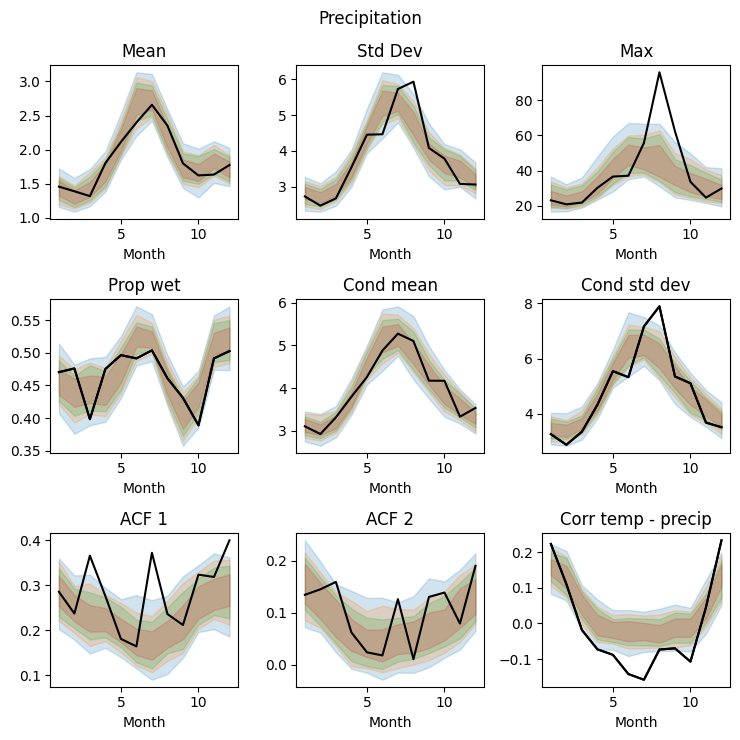

In [130]:
fig = plt.figure(layout="tight", figsize=(7.5, 7.5))
fig.suptitle("Precipitation")

gs = GridSpec(3, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[1])
get_max_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[2])

# Row 2
ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_prop_wet_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[0])
get_cond_mean_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[1])
get_cond_std_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[2])

# Row 3
ax_row_3 = [fig.add_subplot(gs[2, i]) for i in range(3)]
get_acf_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_3[0], lag=1)
get_acf_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_3[1], lag=2)
get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_3[2])


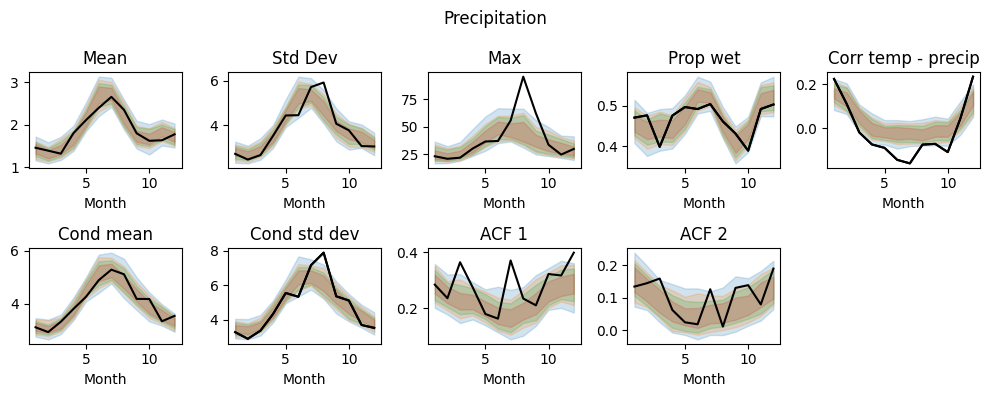

In [526]:
fig = plt.figure(layout="tight", figsize=(10, 4))
fig.suptitle("Precipitation")

gs = GridSpec(2, 5, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(5)]
get_mean_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[1])
get_max_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[2])
get_prop_wet_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[3])
get_temp_precip_cor_plot(obs["Tavg"], svi_preds["Tavg"], obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_1[4])



# Row 2
ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(5)]
get_cond_mean_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[0])
get_cond_std_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[1])
get_acf_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[2], lag=1)
get_acf_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax=ax_row_2[3], lag=2)
ax_row_2[4].axis("off")

plt.savefig("plots/pr_paper.png", dpi = 300)

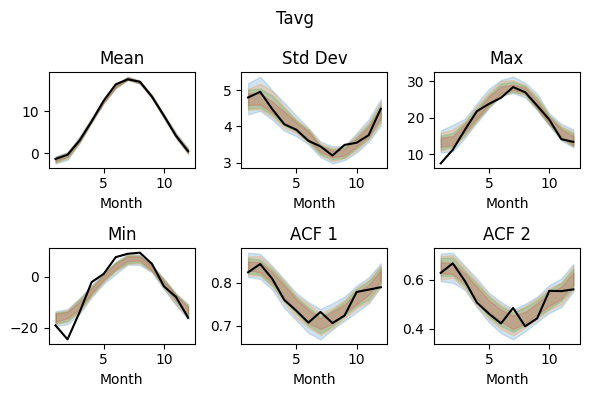

In [530]:
fig = plt.figure(layout="tight", figsize=(6, 4))
fig.suptitle("Tavg")

gs = GridSpec(2, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_1[1])
get_max_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_1[2])

# Row 2
ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_min_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_2[0])
get_acf_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_2[1], lag=1)
get_acf_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax=ax_row_2[2], lag=2)

plt.savefig("plots/tavg_paper.png", dpi = 300)

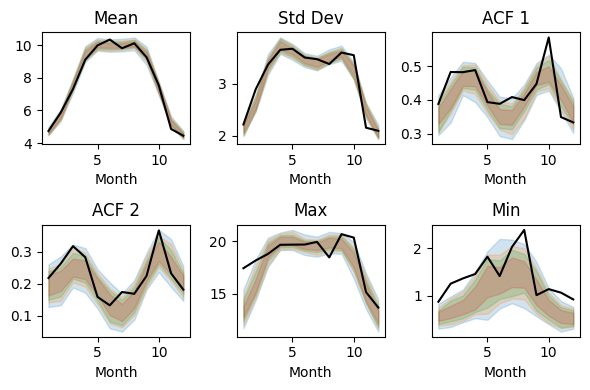

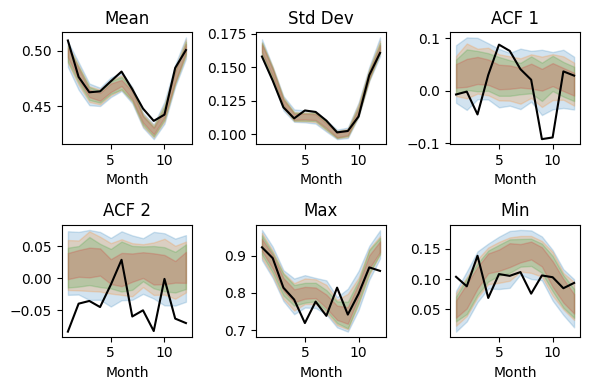

In [563]:
fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Trange")

gs = GridSpec(2, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index, ax=ax_row_1[1])
get_acf_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index, ax=ax_row_1[2], lag=1)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_acf_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index, ax=ax_row_2[0], lag=2)
get_max_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index, ax=ax_row_2[1])
get_min_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index, ax=ax_row_2[2])

plt.savefig("plots/trange_paper.png", dpi = 300)


fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Tskew")
gs = GridSpec(2, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, ax=ax_row_1[1])
get_acf_plot(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, ax=ax_row_1[2], lag=1)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_acf_plot(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, ax=ax_row_2[0], lag=2)
get_max_plot(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, ax=ax_row_2[1])
get_min_plot(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, ax=ax_row_2[2])

plt.savefig("plots/tskew_paper.png", dpi = 300)

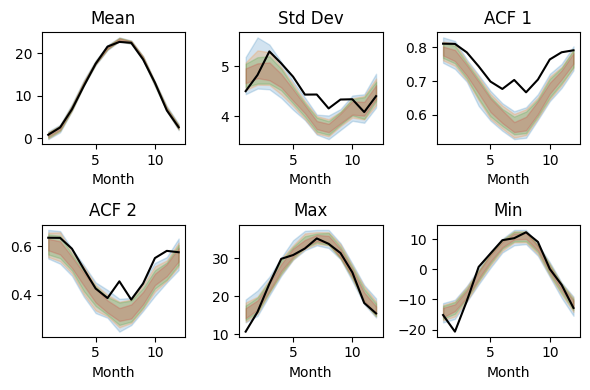

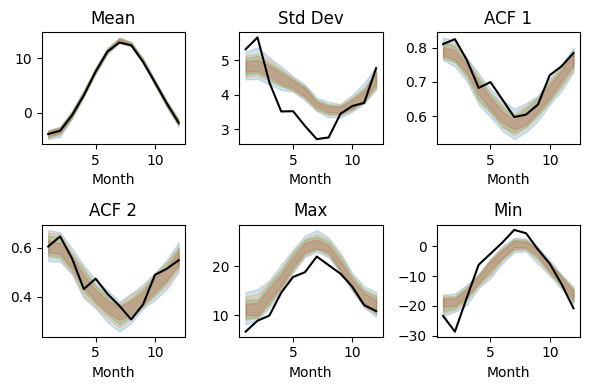

In [565]:
fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Tmax")

gs = GridSpec(2, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tmax"], svi_preds["Tmax"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["Tmax"], svi_preds["Tmax"], basin_data_train.index, ax=ax_row_1[1])
get_acf_plot(obs["Tmax"], svi_preds["Tmax"], basin_data_train.index, ax=ax_row_1[2], lag=1)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_acf_plot(obs["Tmax"], svi_preds["Tmax"], basin_data_train.index, ax=ax_row_2[0], lag=2)
get_max_plot(obs["Tmax"], svi_preds["Tmax"], basin_data_train.index, ax=ax_row_2[1])
get_min_plot(obs["Tmax"], svi_preds["Tmax"], basin_data_train.index, ax=ax_row_2[2])

plt.savefig("plots/tmax_paper.png", dpi = 300)


fig = plt.figure(layout="tight", figsize=(6, 4))
#fig.suptitle("Tmin")
gs = GridSpec(2, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["Tmin"], svi_preds["Tmin"], basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["Tmin"], svi_preds["Tmin"], basin_data_train.index, ax=ax_row_1[1])
get_acf_plot(obs["Tmin"], svi_preds["Tmin"], basin_data_train.index, ax=ax_row_1[2], lag=1)

ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_acf_plot(obs["Tmin"], svi_preds["Tmin"], basin_data_train.index, ax=ax_row_2[0], lag=2)
get_max_plot(obs["Tmin"], svi_preds["Tmin"], basin_data_train.index, ax=ax_row_2[1])
get_min_plot(obs["Tmin"], svi_preds["Tmin"], basin_data_train.index, ax=ax_row_2[2])

plt.savefig("plots/tmin_paper.png", dpi = 300)

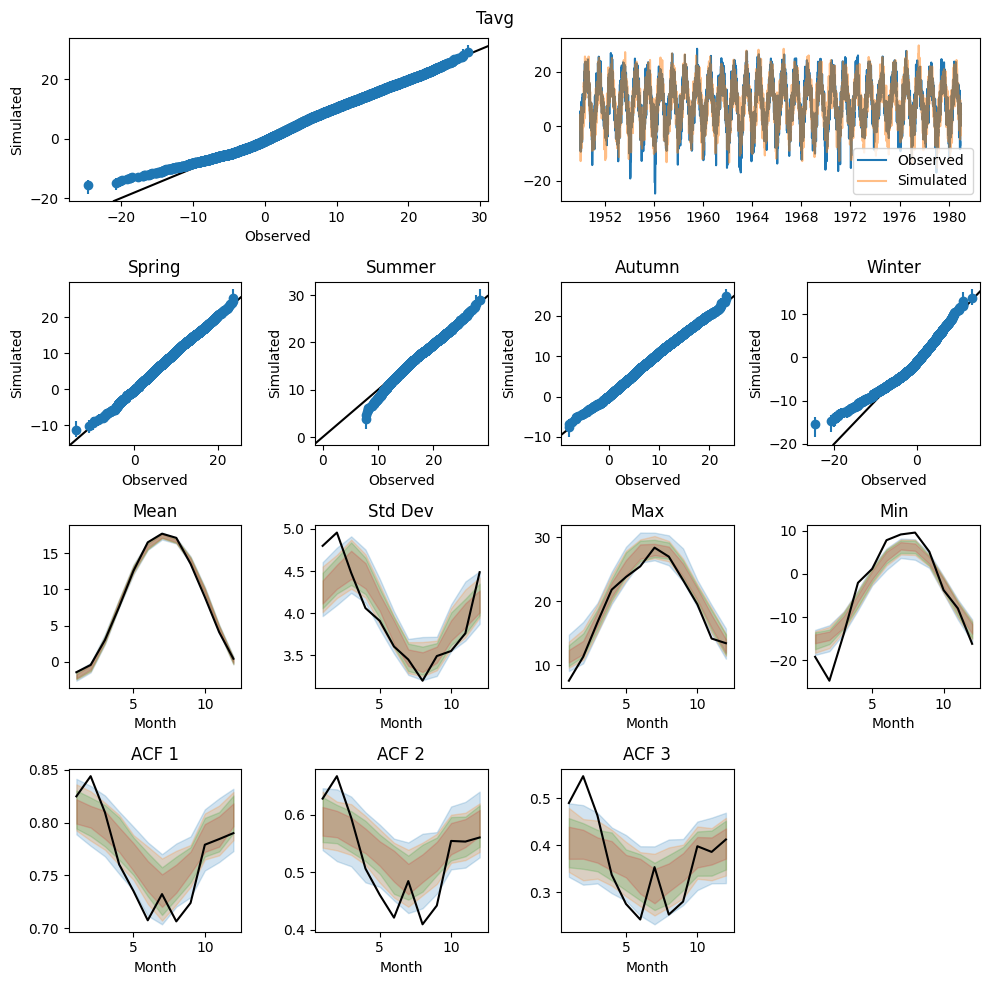

In [26]:
Tavg_overview(obs, svi_preds, basin_data_train)
#plt.savefig("plots/wgen_v5_Tavg.png")

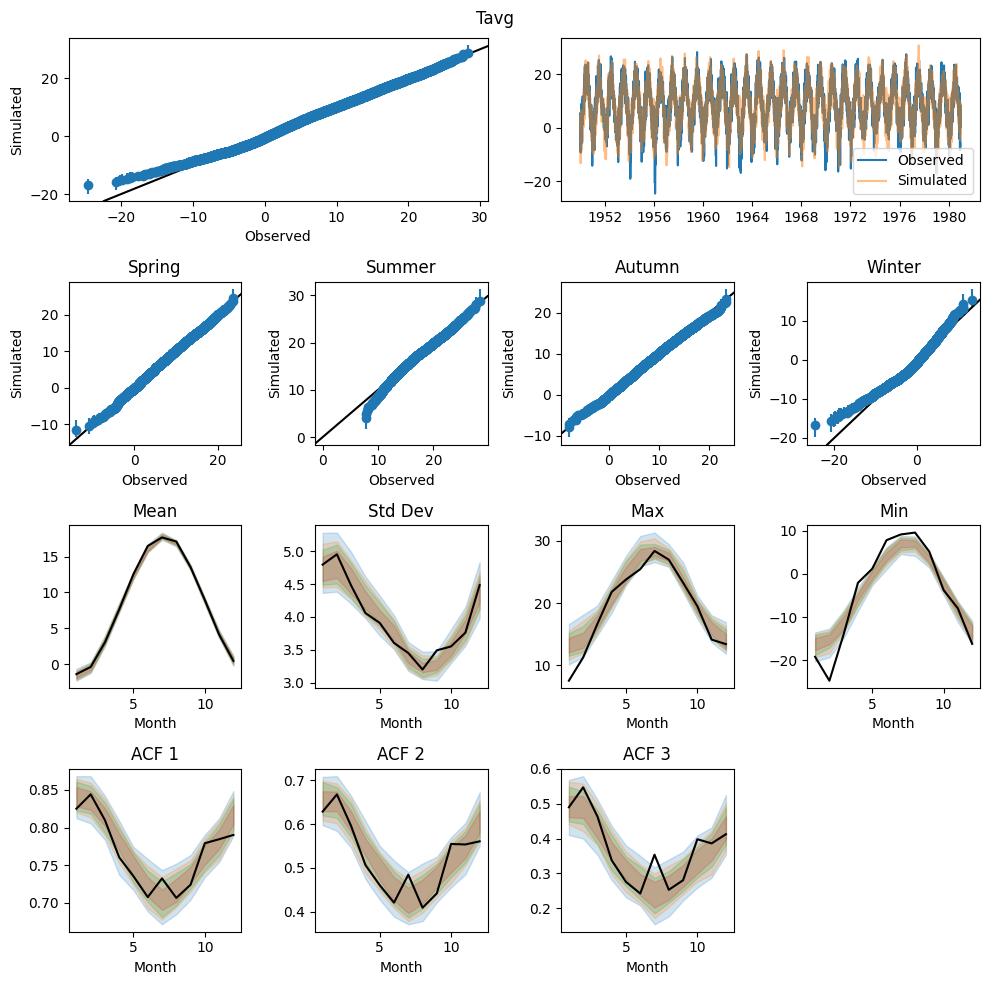

In [46]:
Tavg_overview(obs, svi_preds, basin_data_train)
#plt.savefig("plots/wgen_v5_Tavg.png")

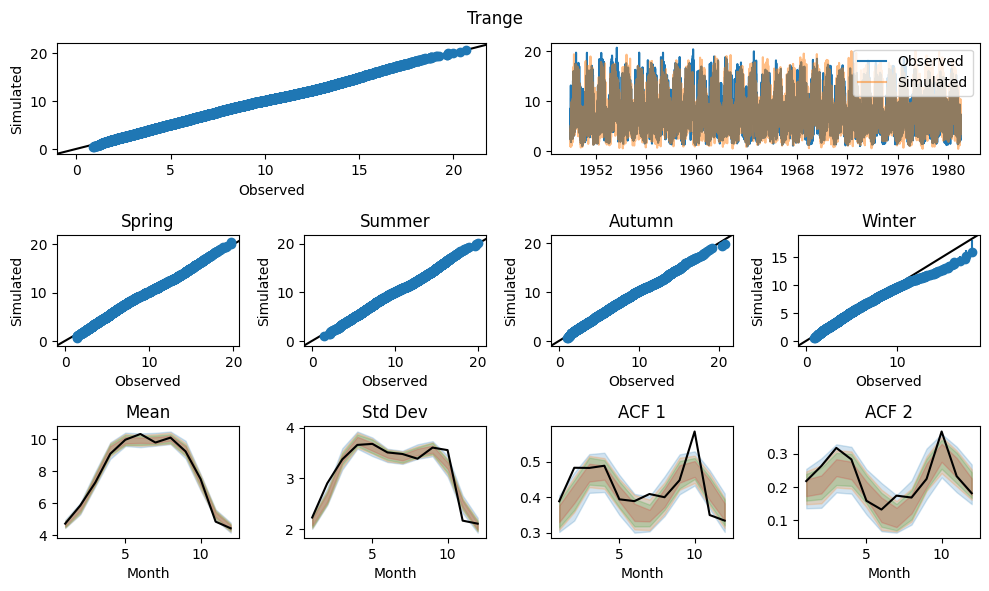

In [47]:
Trange_overview(obs, svi_preds, basin_data_train)
#plt.savefig("plots/wgen_v5_Trange.png")

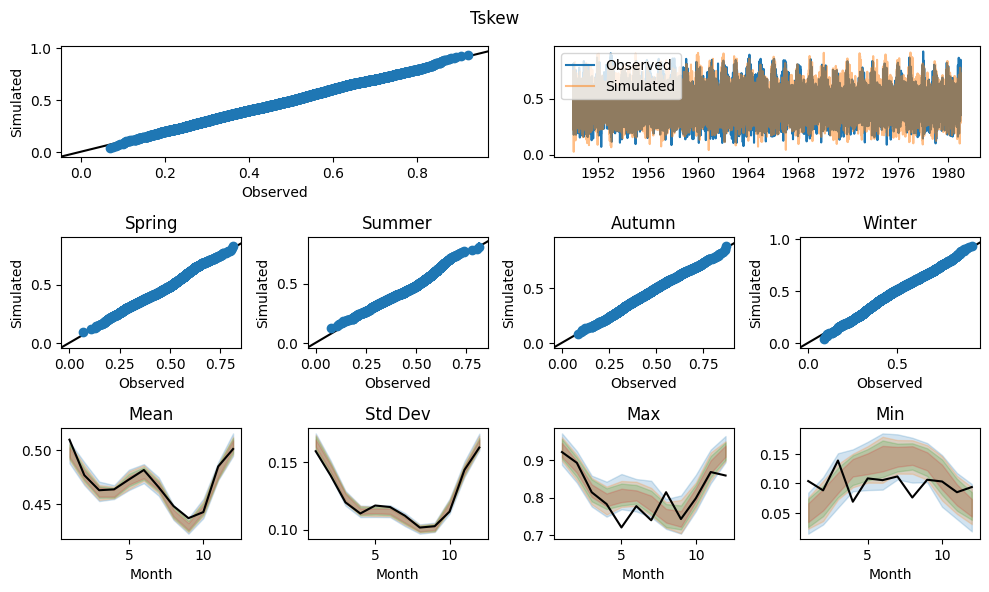

In [48]:
Tskew_overview(obs, svi_preds, basin_data_train)
#plt.savefig("plots/wgen_v5_Tskew.png")

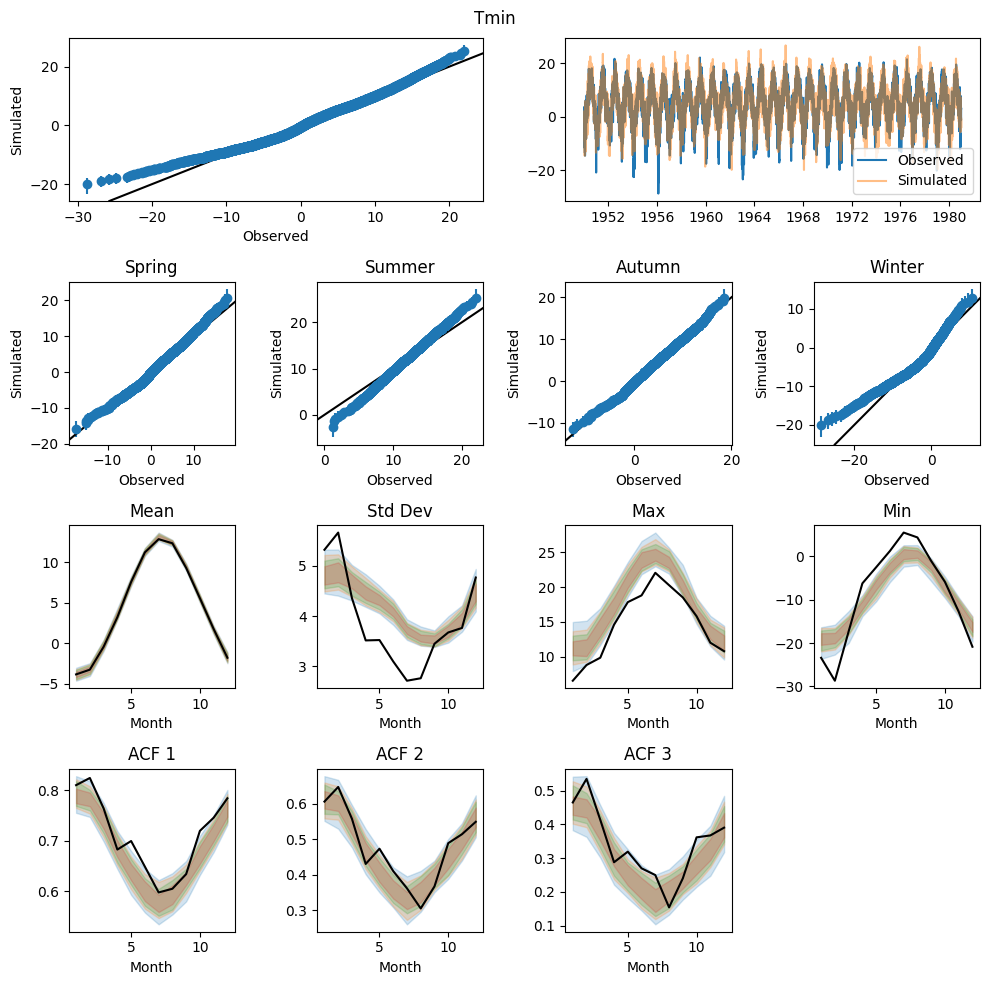

In [49]:
Tmin_overview(obs, svi_preds, basin_data_train)
#plt.savefig("plots/wgen_v5_Tmin.png")

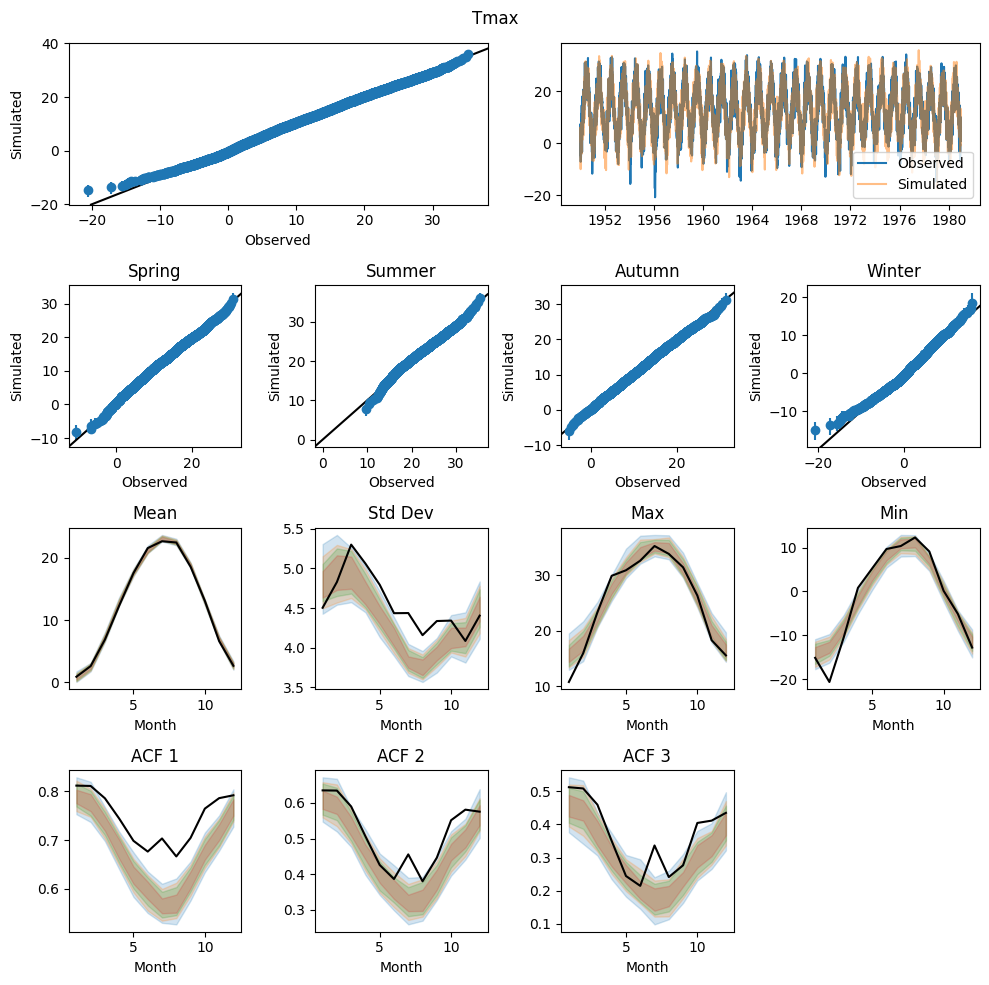

In [50]:
Tmax_overview(obs, svi_preds, basin_data_train)
#plt.savefig("plots/wgen_v5_Tmax.png")

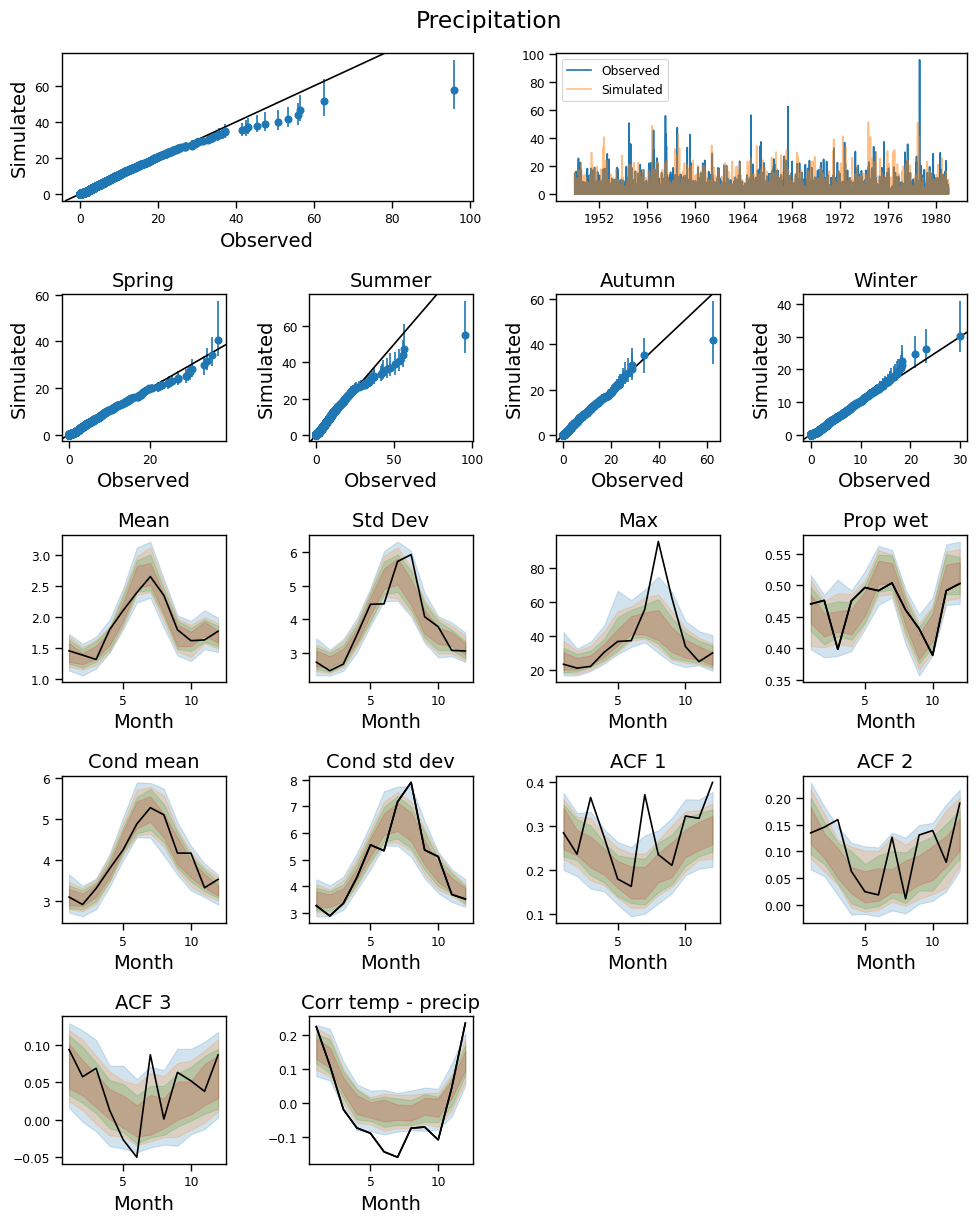

In [522]:
prec_overview(obs, svi_preds, basin_data_train)
plt.savefig("plots/wgen_v5_prec.png")

# SBI

In [28]:
import torch
from jax2torch.jax2torch import jax2torch, j2t, t2j
from sbi.inference import SNPE, SNLE, simulate_for_sbi
from sbi.utils.user_input_checks import process_prior, process_simulator

torch.manual_seed(1234)

In [29]:
def run_sbi(wgen, svi_result, observable_fct, obs_target, scale_factor = 2.5, parameter_mask = None, num_samples = 2000, num_rounds = 10):
    """
    Run SBI on a weather generator to calibrate it to a set of target statistics.

    Args:
        wgen: A WGEN object including a weather generator.
        svi_result: The result of an SVI fit through wgen.fit.
        observable_fct: A function taking as input arrays of realizations of ts, precip, Tmin, Tavg, Tmax and outputting summary statistics.
        obs_target: A vector of target summary statistics.
        scale_factor: Scaling amount for the posterior to obtain the SBI prior.
        parameter_mask: A mask to keep certain parameters from being scaled up. Helps with the SBI fit.
        
    Returns:
        tuple[array,array | None]: outputs, observable

    """
    sim, sim_prior = wgen.simulator(observable=observable_fct, rng_seed=1234) # Generate simulator and prior
    wgen_sbi = jax2torch(sim) # Convert to torch for sbi

    print("Sampling...")

    fitted_posterior = guide.get_posterior(svi_result.params)

    # Sample from mean of fitted posterior
    summary_stats_samples_from_mean_fitted_posterior = wgen_sbi(j2t(fitted_posterior.mean).unsqueeze(0).expand(num_samples, -1))

    # Sample from fitted posterior
    proposal_fitted_posterior = torch.distributions.MultivariateNormal(j2t(fitted_posterior.mean), j2t(fitted_posterior.covariance_matrix))
    samples_from_fitted_posterior = proposal_fitted_posterior.sample((num_samples,))
    summary_stats_samples_from_fitted_posterior = wgen_sbi(samples_from_fitted_posterior)

    # Sample from scaled up posterior (proposal for SBI)
    if parameter_mask is None:
        parameter_mask = 1.
    sbi_proposal = torch.distributions.MultivariateNormal(j2t(fitted_posterior.mean), j2t(jnp.diag(fitted_posterior.covariance_matrix)*jnp.eye(len(fitted_posterior.mean)) + parameter_mask*(scale_factor**2 - 1)*jnp.eye(len(fitted_posterior.mean))* jnp.diag(fitted_posterior.covariance_matrix)))
    samples_from_sbi_proposal = sbi_proposal.sample((num_samples,))
    summary_stats_samples_from_sbi_proposal = wgen_sbi(samples_from_sbi_proposal)

    # Plot fitted posterior and SBI proposal as well as targets
    fig, axs = plt.subplots(1, obs_target.shape[0], figsize = (obs_target.shape[0]*5, 5))
    for i in range(obs_stats.shape[0]):
        axs[i].hist(summary_stats_samples_from_fitted_posterior[:, i].numpy(), bins = 20, density = True, alpha = 0.5, label = "Fitted posterior")
        axs[i].hist(summary_stats_samples_from_sbi_proposal[:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Scaled-up posterior")
        axs[i].legend(loc = "upper right")
        axs[i].axvline(obs_target[i,:].flatten(), c= "black")
    plt.show()

    print("Running SBI...")

    # Run SBI
    sbi_alg = SNPE(sbi_proposal)
    num_simulations = 1000
    proposal = sbi_proposal
    for i in range(num_rounds):
        theta, x = simulate_for_sbi(wgen_sbi, proposal=proposal, num_simulations=num_simulations, simulation_batch_size=500)
        sbi_alg.append_simulations(theta, x, proposal, exclude_invalid_x=True)
        density_estimator = sbi_alg.train()
        sbi_posterior = sbi_alg.build_posterior(density_estimator).set_default_x(j2t(obs_target.squeeze()))
        proposal = sbi_posterior

    print("Sampling SBI posterior and point estimate...")

    # Sample from SBI posterior
    samples_from_sbi_posterior = sbi_posterior.sample((num_samples,))
    summary_stats_samples_from_sbi_posterior = wgen_sbi(samples_from_sbi_posterior)

    # Plot
    fig, axs = plt.subplots(1, obs_target.shape[0], figsize = (obs_target.shape[0]*5, 5))
    for i in range(obs_stats.shape[0]):
        axs[i].hist(summary_stats_samples_from_fitted_posterior[:, i].numpy(), bins = 20, density = True, alpha = 0.5, label = "Fitted posterior")
        axs[i].hist(summary_stats_samples_from_sbi_proposal[:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Scaled-up posterior")
        axs[i].hist(summary_stats_samples_from_sbi_posterior[:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "After SBI")
        axs[i].legend(loc = "upper right")
        axs[i].axvline(obs_target[i,:].flatten(), c= "black")
    plt.show()

    # Get point estimate 
    diff = summary_stats_samples_from_sbi_posterior-j2t(obs_target).swapaxes(-1, -2)
    diff = torch.norm(diff / summary_stats_samples_from_sbi_posterior.std(dim = 1).unsqueeze(1), dim = 1)
    min_diff_parameter = samples_from_sbi_posterior[torch.argmin(diff), :]
    summary_stats_samples_from_sbi_posterior_min_diff = wgen_sbi(min_diff_parameter.unsqueeze(0).expand(num_samples, -1))

    # Dict to return
    samples_summary_stats = {
        "mean_fitted_posterior": summary_stats_samples_from_mean_fitted_posterior,
        "fitted_posterior": summary_stats_samples_from_fitted_posterior, 
        "sbi_proposal": summary_stats_samples_from_sbi_proposal,
        "sbi_posterior": summary_stats_samples_from_sbi_posterior,
        "sbi_posterior_point_estimate": summary_stats_samples_from_sbi_posterior_min_diff
    }

    # Get realizations from weather generator
    simulator_get_obs, _ = wgen.simulator(rng_seed=1234)
    simulator_get_obs = jax2torch(simulator_get_obs)
    
    samples_obs = {
        "mean_fitted_posterior": simulator_get_obs(j2t(fitted_posterior.mean).unsqueeze(0).expand(100, -1)),
        "fitted_posterior": simulator_get_obs(proposal_fitted_posterior.sample((100,))),
        "sbi_posterior": simulator_get_obs(sbi_posterior.sample((100,))),
        "sbi_posterior_point_estimate": simulator_get_obs(min_diff_parameter.unsqueeze(0).expand(100, -1))
    }

    return sbi_posterior, samples_summary_stats, samples_obs


In [30]:
def check_if_list_in_string(l, x):
    for elem in l:
        if elem in x:
            return True
    return False
    
def get_parameter_mask(posterior_params, ignore_elems):
    """
    posterior_params: obtained through:
    posterior_sampler = Predictive(guide, params=svi_result.params, num_samples=100)
    posterior_params = posterior_sampler(prng)

    ignore_elems: elements to ignore, tested with `in` operator, so can be e.g. "Trange", "Tskew".
    """
    posterior_params_without_auto_latent = {k: e for k, e in posterior_params.items() if k != "_auto_latent"}
    ignore_list = [n for n in posterior_params_without_auto_latent.keys() if check_if_list_in_string(ignore_elems,n)]# or "precip_occ" in n]
    parameter_mask = np.concatenate([np.ones_like(v.mean(axis=0)) if k in ignore_list else np.zeros_like(v.mean(axis=0)) for k,v in posterior_params_without_auto_latent.items()])
    parameter_mask = jnp.array(parameter_mask)
    return parameter_mask
    


In [31]:
# Get parameter mask of parameters to ignore
posterior_sampler = Predictive(guide, params=svi_result.params, num_samples=100)
posterior_params = posterior_sampler(prng)


## Case study 1 (Tavg, pr, dry days const.):

Trend in tavg, precip, dry days constant:

In [99]:
def case_study_1(ts, precip, Tmin, Tavg, Tmax):
    pmean = jnp.mean(precip, axis = 0)
    pavgwet = jnp.mean(precip > 0, axis = 0)
    Tavgmean = jnp.mean(Tavg, axis = 0)
    return jnp.stack([pmean, pavgwet, Tavgmean])

In [403]:
obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = case_study_1(wgen.timestamps[0,:,:], obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[1.8636943],
       [0.4654244],
       [8.347303 ]], dtype=float32)

In [404]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.2)
obs_stats_target = obs_stats_target.at[2].add(3.5)
obs_stats_target

Array([[ 2.2364333],
       [ 0.4654244],
       [11.847303 ]], dtype=float32)

Sampling...


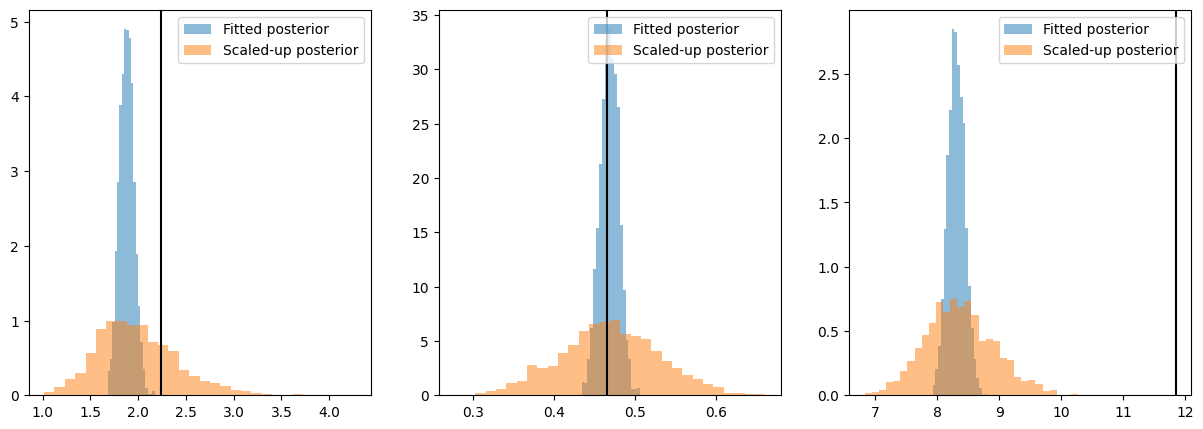

Running SBI...


Running 1000 simulations.: 100%|██████████| 1000/1000 [01:11<00:00, 13.99it/s]


 Neural network successfully converged after 58 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:11<00:00, 14.04it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 87 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:08<00:00, 14.58it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 39 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:10<00:00, 14.16it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:11<00:00, 13.96it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:09<00:00, 14.40it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:18<00:00, 12.70it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:08<00:00, 14.68it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 56 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:13<00:00, 13.64it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:19<00:00, 12.64it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.Sampling SBI posterior and point estimate...


Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:02<00:00, 762.04it/s]


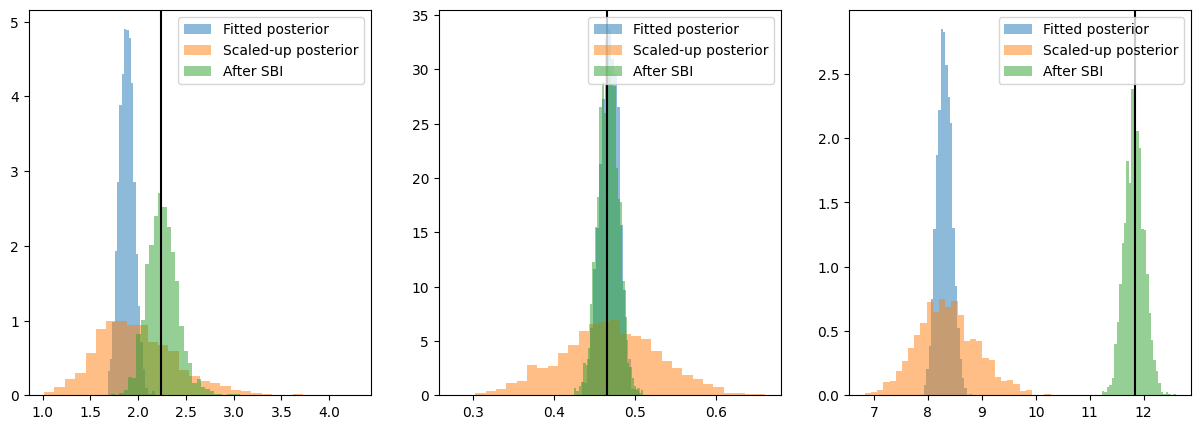

Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 135.41it/s]


In [407]:
parameter_mask = get_parameter_mask(posterior_params, ["Trange", "Tskew"])

sbi_posterior, samples_summary_stats, samples_obs = run_sbi(wgen, svi_result, observable_fct = case_study_1, obs_target = obs_stats_target, scale_factor = 2., parameter_mask = parameter_mask, num_samples = 2000, num_rounds = 10)


In [408]:
torch.save(samples_summary_stats, "sbi_results/case_study_1_samples_summary_stats.pt")
torch.save(samples_obs, "sbi_results/case_study_1_samples_obs.pt")


## Case study 2 (seasonal Tavg, pr, dry days const)

In [113]:
def case_study_2(ts, precip, Tmin, Tavg, Tmax):
    """
    ts: [1, timesteps, 4], 4: index, year, month, doy
    precip, Tmin, Tavg, Tmax: [timesteps, realizations]
    Returns: [summary_stats, realizations]
    """
    winter = jnp.isin(ts[:, :, 2], jnp.array([12, 1, 2])).T
    spring = jnp.isin(ts[:, :, 2], jnp.array([3, 4, 5])).T
    summer = jnp.isin(ts[:, :, 2], jnp.array([6, 7, 8])).T
    autumn = jnp.isin(ts[:, :, 2], jnp.array([9, 10, 11])).T

    pmean_winter = jnp.nanmean(jnp.where(winter, precip, jnp.nan), axis = 0)
    pmean_spring = jnp.nanmean(jnp.where(spring, precip, jnp.nan), axis = 0)
    pmean_summer = jnp.nanmean(jnp.where(summer, precip, jnp.nan), axis = 0)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, precip, jnp.nan), axis = 0)

    wet = (precip > 0)
    pavgwet_winter = jnp.nanmean(jnp.where(winter, wet, jnp.nan), axis = 0)
    pavgwet_spring = jnp.nanmean(jnp.where(spring, wet, jnp.nan), axis = 0)
    pavgwet_summer = jnp.nanmean(jnp.where(summer, wet, jnp.nan), axis = 0)
    pavgwet_autumn = jnp.nanmean(jnp.where(autumn, wet, jnp.nan), axis = 0)
    
    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = 0)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = 0)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = 0)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = 0)

    #icy_days = jnp.mean(Tmax < 0, axis = 0)
    #heavy_rain = jnp.mean(precip > 20, axis = 0)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, pavgwet_winter, pavgwet_spring, pavgwet_summer, pavgwet_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn])#, icy_days])

obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = case_study_2(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[ 1.5461818 ],
       [ 1.7449532 ],
       [ 2.4704154 ],
       [ 1.6852754 ],
       [ 0.48320228],
       [ 0.45652175],
       [ 0.48527348],
       [ 0.43672457],
       [-0.46448863],
       [ 7.7378182 ],
       [17.098232  ],
       [ 8.8563385 ]], dtype=float32)

In [29]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[8].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[9].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[10].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[11].add(4.5) # Tavg autumn

#obs_stats_target = obs_stats_target.at[12].add(-0.06) # icy days

obs_stats_target

Array([[ 2.0100362 ],
       [ 2.268439  ],
       [ 2.4704154 ],
       [ 1.9380667 ],
       [ 0.48320228],
       [ 0.45652175],
       [ 0.48527348],
       [ 0.43672457],
       [ 2.9355116 ],
       [10.337818  ],
       [20.198233  ],
       [13.3563385 ]], dtype=float32)

Run SBI:

Sampling...


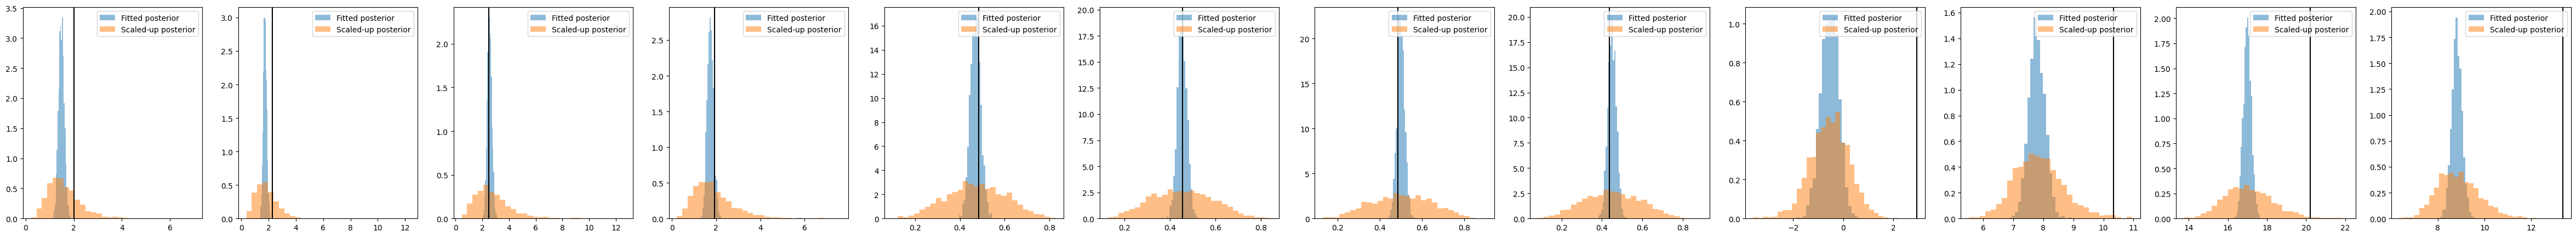

Running SBI...


Running 1000 simulations.: 100%|██████████| 1000/1000 [01:09<00:00, 14.46it/s]


 Neural network successfully converged after 74 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:15<00:00, 13.30it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 46 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:20<00:00, 12.39it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:38<00:00, 10.14it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 49 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:26<00:00, 11.63it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:16<00:00, 13.08it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:22<00:00, 12.15it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 43 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:18<00:00, 12.75it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 42 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:26<00:00, 11.52it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 45 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:15<00:00, 13.25it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 60 epochs.Sampling SBI posterior and point estimate...


Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:02<00:00, 751.03it/s]


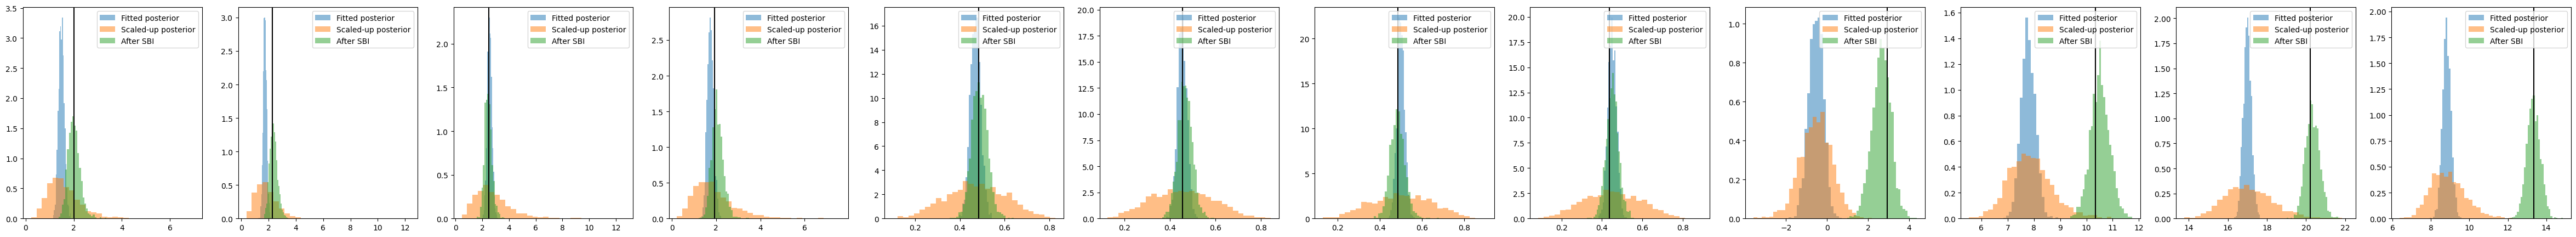

Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 138.04it/s]


In [31]:
parameter_mask = get_parameter_mask(posterior_params, ["Trange", "Tskew"])

sbi_posterior, samples_summary_stats, samples_obs = run_sbi(wgen, svi_result, observable_fct = case_study_2, obs_target = obs_stats_target, scale_factor = 2.5, parameter_mask = parameter_mask, num_samples = 2000, num_rounds = 10)


In [143]:
torch.save(samples_summary_stats, "sbi_results/case_study_2_samples_summary_stats.pt")
torch.save(samples_obs, "sbi_results/case_study_2_samples_obs.pt")


## Case study 3 (seasonal Tavg, pr)

In [115]:
def case_study_3(ts, precip, Tmin, Tavg, Tmax):
    """
    ts: [1, timesteps, 4], 4: index, year, month, doy
    precip, Tmin, Tavg, Tmax: [timesteps, realizations]
    Returns: [summary_stats, realizations]
    """
    winter = jnp.isin(ts[:, :, 2], jnp.array([12, 1, 2])).T
    spring = jnp.isin(ts[:, :, 2], jnp.array([3, 4, 5])).T
    summer = jnp.isin(ts[:, :, 2], jnp.array([6, 7, 8])).T
    autumn = jnp.isin(ts[:, :, 2], jnp.array([9, 10, 11])).T

    pmean_winter = jnp.nanmean(jnp.where(winter, precip, jnp.nan), axis = 0)
    pmean_spring = jnp.nanmean(jnp.where(spring, precip, jnp.nan), axis = 0)
    pmean_summer = jnp.nanmean(jnp.where(summer, precip, jnp.nan), axis = 0)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, precip, jnp.nan), axis = 0)
    
    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = 0)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = 0)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = 0)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = 0)

    #icy_days = jnp.mean(Tmax < 0, axis = 0)
    #heavy_rain = jnp.mean(precip > 20, axis = 0)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn])#, icy_days])

obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = case_study_3(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[ 1.5461818 ],
       [ 1.7449532 ],
       [ 2.4704154 ],
       [ 1.6852754 ],
       [-0.46448863],
       [ 7.7378182 ],
       [17.098232  ],
       [ 8.8563385 ]], dtype=float32)

In [410]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn

#obs_stats_target = obs_stats_target.at[12].add(-0.06) # icy days

obs_stats_target

Array([[ 2.0100362],
       [ 2.268439 ],
       [ 2.4704154],
       [ 1.9380667],
       [ 2.9355116],
       [10.337818 ],
       [20.198233 ],
       [13.3563385]], dtype=float32)

Run SBI:

Sampling...


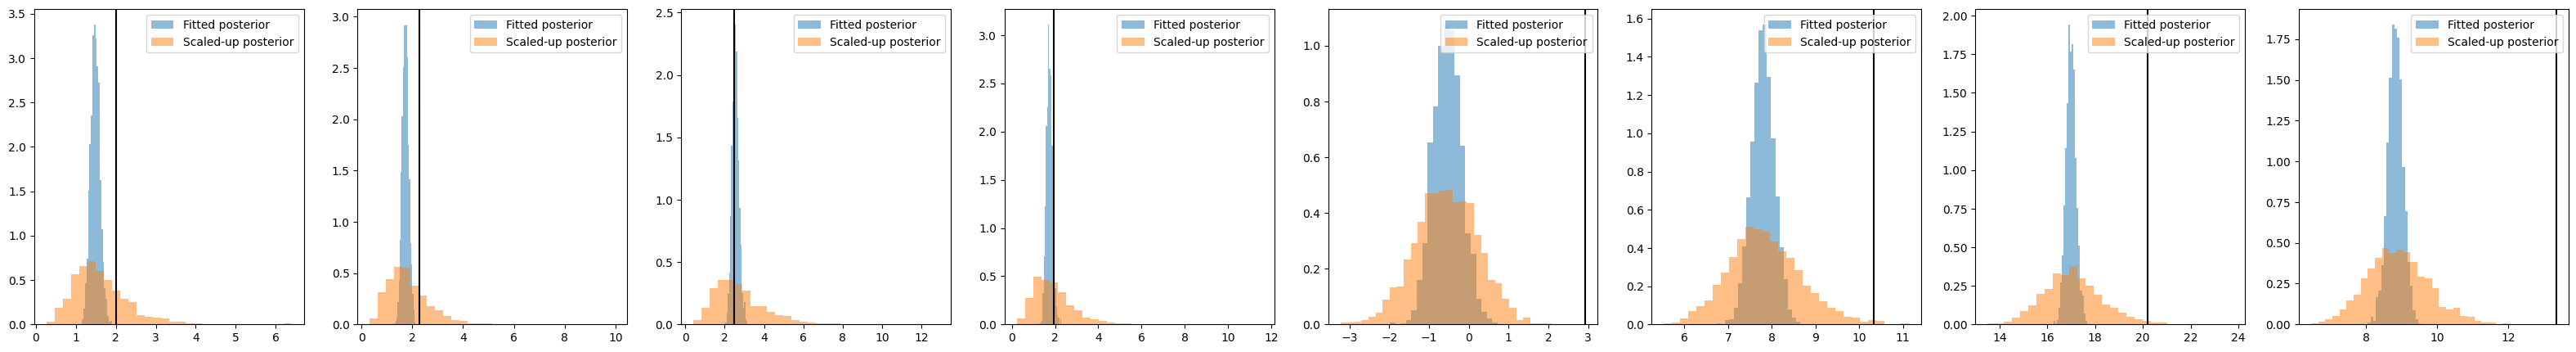

Running SBI...


Running 1000 simulations.: 100%|██████████| 1000/1000 [01:13<00:00, 13.68it/s]


 Neural network successfully converged after 74 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:13<00:00, 13.70it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 72 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:15<00:00, 13.28it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 89 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:19<00:00, 12.63it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:26<00:00, 11.62it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:16<00:00, 13.09it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 59 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:22<00:00, 12.09it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 45 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:17<00:00, 12.96it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:08<00:00, 14.61it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:09<00:00, 14.32it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 42 epochs.Sampling SBI posterior and point estimate...


Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:03<00:00, 613.63it/s]


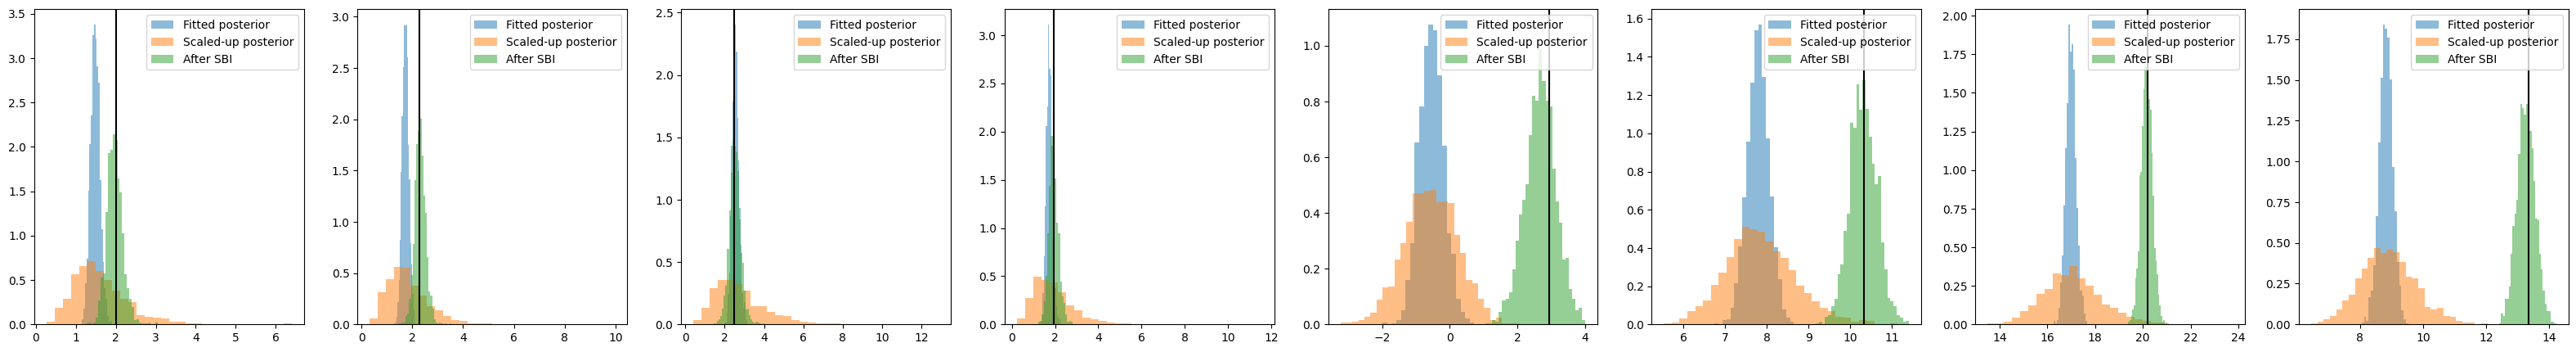

Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 124.78it/s]


In [412]:
parameter_mask = get_parameter_mask(posterior_params, ["Trange", "Tskew"])

sbi_posterior, samples_summary_stats, samples_obs = run_sbi(wgen, svi_result, observable_fct = case_study_3, obs_target = obs_stats_target, scale_factor = 2.5, parameter_mask = parameter_mask, num_samples = 2000, num_rounds = 10)


In [413]:
torch.save(samples_summary_stats, "sbi_results/case_study_3_samples_summary_stats.pt")
torch.save(samples_obs, "sbi_results/case_study_3_samples_obs.pt")

## Case study 4 (seasonal Tavg, pr, 95th percentile)

In [117]:
def case_study_4(ts, precip, Tmin, Tavg, Tmax):
    """
    ts: [1, timesteps, 4], 4: index, year, month, doy
    precip, Tmin, Tavg, Tmax: [timesteps, realizations]
    Returns: [summary_stats, realizations]
    """
    winter = jnp.isin(ts[:, :, 2], jnp.array([12, 1, 2])).T
    spring = jnp.isin(ts[:, :, 2], jnp.array([3, 4, 5])).T
    summer = jnp.isin(ts[:, :, 2], jnp.array([6, 7, 8])).T
    autumn = jnp.isin(ts[:, :, 2], jnp.array([9, 10, 11])).T

    pmean_winter = jnp.nanmean(jnp.where(winter, precip, jnp.nan), axis = 0)
    pmean_spring = jnp.nanmean(jnp.where(spring, precip, jnp.nan), axis = 0)
    pmean_summer = jnp.nanmean(jnp.where(summer, precip, jnp.nan), axis = 0)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, precip, jnp.nan), axis = 0)

    wet = (precip > 0)
    pavgwet_winter = jnp.nanmean(jnp.where(winter, wet, jnp.nan), axis = 0)
    pavgwet_spring = jnp.nanmean(jnp.where(spring, wet, jnp.nan), axis = 0)
    pavgwet_summer = jnp.nanmean(jnp.where(summer, wet, jnp.nan), axis = 0)
    pavgwet_autumn = jnp.nanmean(jnp.where(autumn, wet, jnp.nan), axis = 0)
    
    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = 0)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = 0)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = 0)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = 0)

    p95 = jnp.nanquantile(jnp.where(precip > 0, precip, jnp.nan), 0.95, axis = 0)

    #icy_days = jnp.mean(Tmax < 0, axis = 0)
    #heavy_rain = jnp.mean(precip > 20, axis = 0)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, pavgwet_winter, pavgwet_spring, pavgwet_summer, pavgwet_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn, p95])#, icy_days])

obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = case_study_4(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[ 1.5461818 ],
       [ 1.7449532 ],
       [ 2.4704154 ],
       [ 1.6852754 ],
       [ 0.48320228],
       [ 0.45652175],
       [ 0.48527348],
       [ 0.43672457],
       [-0.46448863],
       [ 7.7378182 ],
       [17.098232  ],
       [ 8.8563385 ],
       [12.940038  ]], dtype=float32)

In [426]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[8].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[9].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[10].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[11].add(4.5) # Tavg autumn

obs_stats_target = obs_stats_target.at[-1].mul(1.4) # Tavg autumn

#obs_stats_target = obs_stats_target.at[12].add(-0.06) # icy days

obs_stats_target

Array([[ 2.0100362 ],
       [ 2.268439  ],
       [ 2.4704154 ],
       [ 1.9380667 ],
       [ 0.48320228],
       [ 0.45652175],
       [ 0.48527348],
       [ 0.43672457],
       [ 2.9355116 ],
       [10.337818  ],
       [20.198233  ],
       [13.3563385 ],
       [18.116053  ]], dtype=float32)

Run SBI:

Sampling...


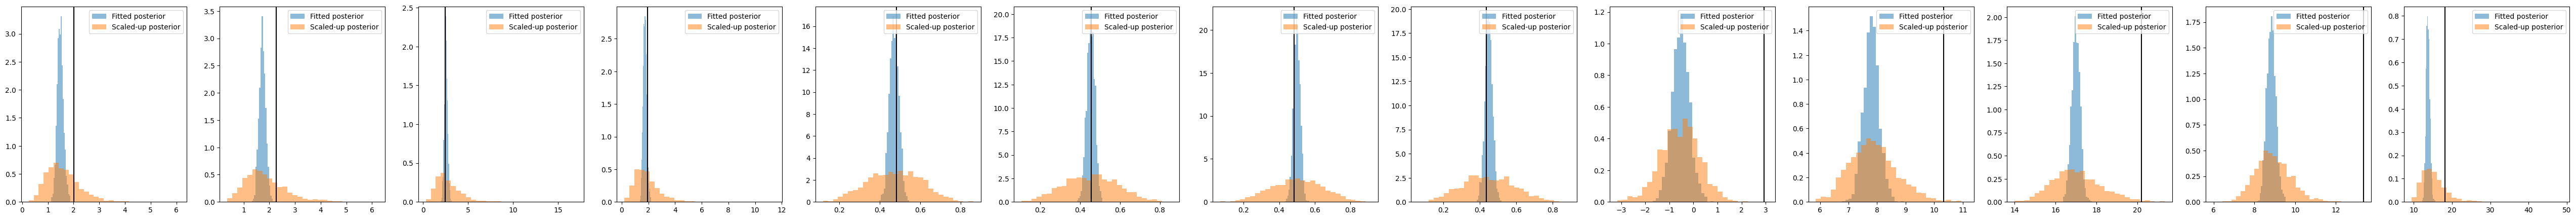

Running SBI...


Running 1000 simulations.: 100%|██████████| 1000/1000 [02:00<00:00,  8.29it/s]


 Neural network successfully converged after 81 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:36<00:00, 10.31it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:29<00:00, 11.23it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:15<00:00, 13.16it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 61 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:17<00:00, 12.94it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:13<00:00, 13.56it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:21<00:00, 12.29it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 49 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:31<00:00, 10.97it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:27<00:00, 11.48it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 34 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:23<00:00, 12.02it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.Sampling SBI posterior and point estimate...


Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:03<00:00, 579.72it/s]


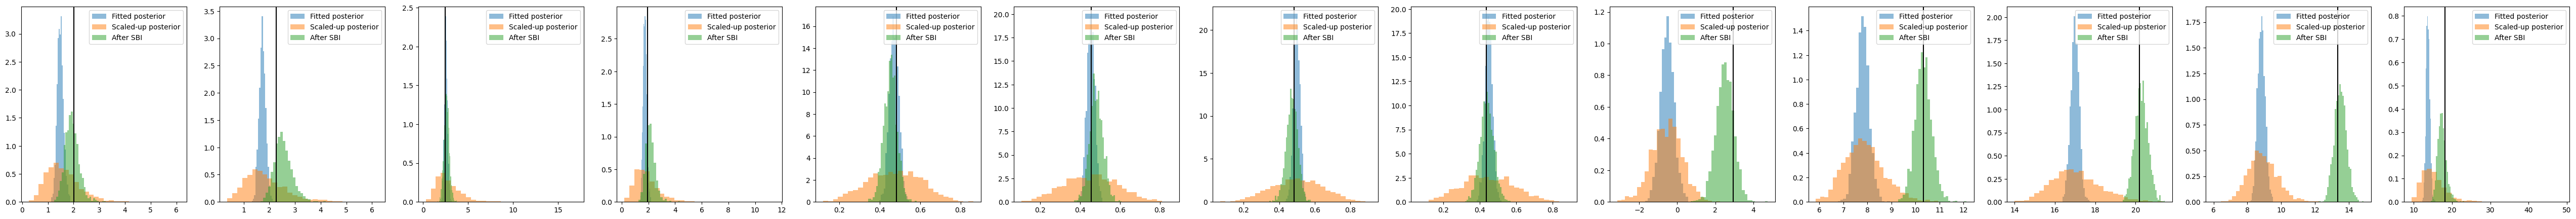

Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 165.74it/s]


In [429]:
parameter_mask = get_parameter_mask(posterior_params, ["Trange", "Tskew"])

sbi_posterior, samples_summary_stats, samples_obs = run_sbi(wgen, svi_result, observable_fct = case_study_4, obs_target = obs_stats_target, scale_factor = 2.5, parameter_mask = parameter_mask, num_samples = 2000, num_rounds = 10)


In [430]:
torch.save(samples_summary_stats, "sbi_results/case_study_4_samples_summary_stats.pt")
torch.save(samples_obs, "sbi_results/case_study_4_samples_obs.pt")


## Case study 5 (Tavg, pr, heavy rain, icy days, tropical night, Trange)

In [119]:
def case_study_5(ts, precip, Tmin, Tavg, Tmax):
    """
    ts: [1, timesteps, 4], 4: index, year, month, doy
    precip, Tmin, Tavg, Tmax: [timesteps, realizations]
    Returns: [summary_stats, realizations]
    """

    Tavgmean = jnp.mean(Tavg, axis = 0)
    
    pmean = jnp.mean(precip, axis = 0)
    heavy_rain = jnp.mean(precip > 20, axis = 0)

    icy_days = jnp.mean(Tmax < 0, axis = 0)
    tropical_nights = jnp.mean(Tmin > 20, axis = 0)

    Trangemean = jnp.mean(Tmax - Tmin, axis = 0)

    return jnp.stack([Tavgmean, pmean, heavy_rain, icy_days, tropical_nights, Trangemean])

obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = case_study_5(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[8.3473034e+00],
       [1.8636943e+00],
       [7.5951605e-03],
       [8.3811715e-02],
       [5.2989495e-04],
       [7.7874007e+00]], dtype=float32)

In [433]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].add(3.1) # Tavg 
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean 
obs_stats_target = obs_stats_target.at[2].mul(2.) # heavy_rain
obs_stats_target = obs_stats_target.at[3].set(0.01) # icy_days: 3 per year
obs_stats_target = obs_stats_target.at[4].set(0.08) # tropical_nights: 30 per year
obs_stats_target = obs_stats_target.at[5].mul(1.2) # Trangemean

obs_stats_target

Array([[1.1447304e+01],
       [2.4228024e+00],
       [1.5190321e-02],
       [9.9999998e-03],
       [7.9999998e-02],
       [9.3448811e+00]], dtype=float32)

Run SBI:

Sampling...


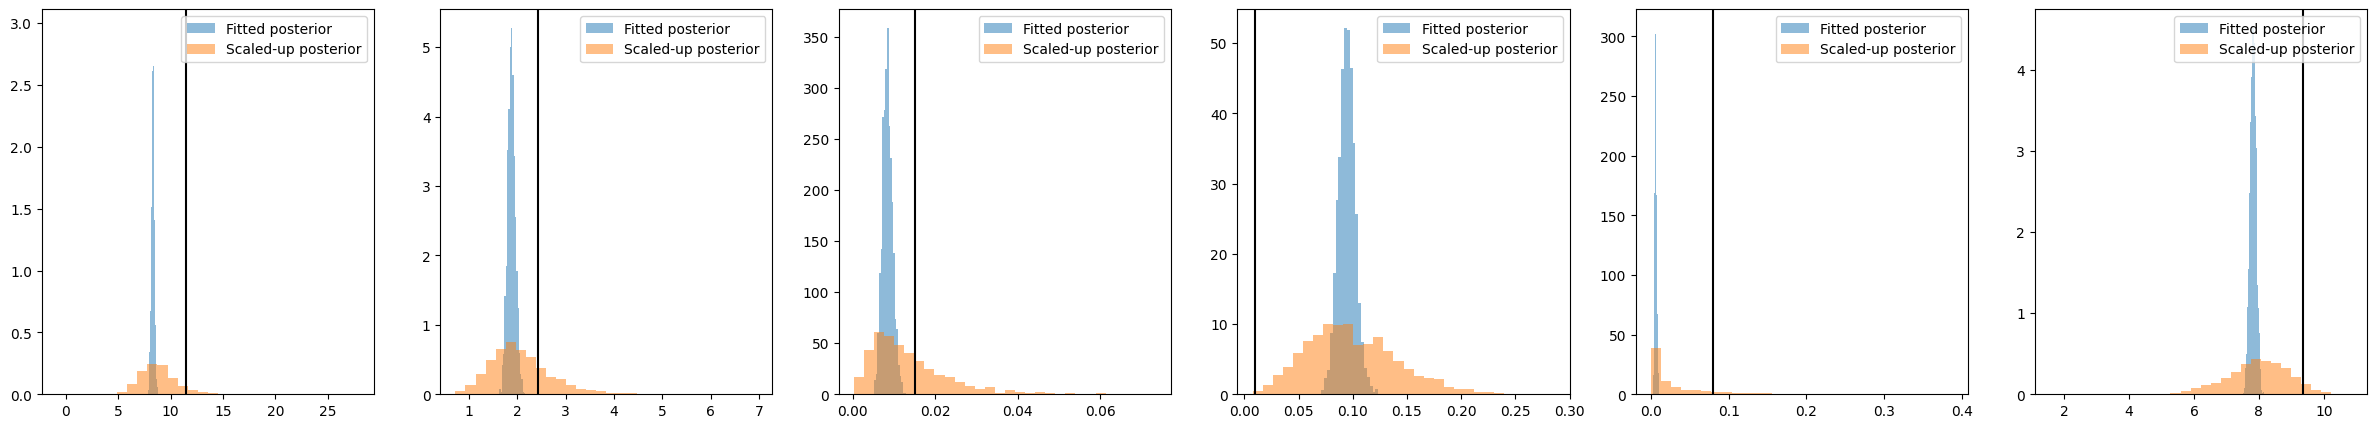

Running SBI...


Running 1000 simulations.: 100%|██████████| 1000/1000 [01:52<00:00,  8.86it/s]


 Neural network successfully converged after 57 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:13<00:00,  7.51it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:09<00:00, 14.41it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 74 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:06<00:00, 14.94it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:10<00:00, 14.22it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 44 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:22<00:00, 12.06it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:15<00:00, 13.29it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:17<00:00, 12.94it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:14<00:00, 13.39it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 45 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:14<00:00, 13.40it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 44 epochs.Sampling SBI posterior and point estimate...


Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:02<00:00, 735.72it/s]


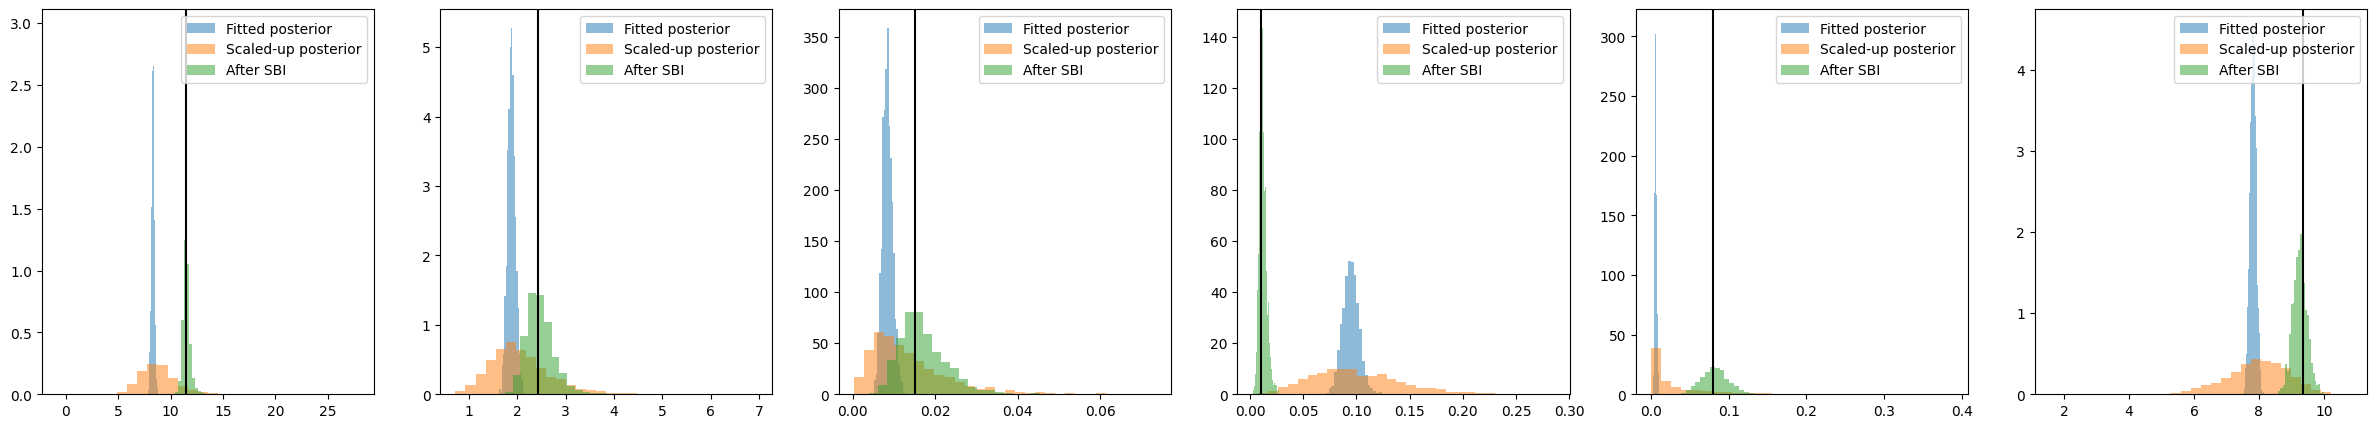

Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 155.60it/s]


In [435]:
sbi_posterior, samples_summary_stats, samples_obs = run_sbi(wgen, svi_result, observable_fct = case_study_5, obs_target = obs_stats_target, scale_factor = 2.5, parameter_mask = None, num_samples = 2000, num_rounds = 10)


In [436]:
torch.save(samples_summary_stats, "sbi_results/case_study_5_samples_summary_stats.pt")
torch.save(samples_obs, "sbi_results/case_study_5_samples_obs.pt")


In [467]:
samples_obs["mean_fitted_posterior"].shape

torch.Size([100, 11323, 4])

## Case study 6 (seasonal Tavg, pr, monthly dry days const)

In [32]:
def case_study_6(ts, precip, Tmin, Tavg, Tmax):
    """
    ts: [1, timesteps, 4], 4: index, year, month, doy
    precip, Tmin, Tavg, Tmax: [timesteps, realizations]
    Returns: [summary_stats, realizations]
    """
    winter = jnp.isin(ts[:, :, 2], jnp.array([12, 1, 2])).T
    spring = jnp.isin(ts[:, :, 2], jnp.array([3, 4, 5])).T
    summer = jnp.isin(ts[:, :, 2], jnp.array([6, 7, 8])).T
    autumn = jnp.isin(ts[:, :, 2], jnp.array([9, 10, 11])).T

    pmean_winter = jnp.nanmean(jnp.where(winter, precip, jnp.nan), axis = 0)
    pmean_spring = jnp.nanmean(jnp.where(spring, precip, jnp.nan), axis = 0)
    pmean_summer = jnp.nanmean(jnp.where(summer, precip, jnp.nan), axis = 0)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, precip, jnp.nan), axis = 0)

    wet = (precip > 0)
    
    monthly_pavg_wet = []
    for i in range(1, 13):
        month = (ts[:, :, 2] == i).T
        pavgwet_month = jnp.nanmean(jnp.where(month, wet, jnp.nan), axis = 0)
        monthly_pavg_wet.append(pavgwet_month)
    
    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = 0)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = 0)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = 0)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = 0)

    #icy_days = jnp.mean(Tmax < 0, axis = 0)
    #heavy_rain = jnp.mean(precip > 20, axis = 0)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn, *monthly_pavg_wet])#, icy_days])

obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = case_study_6(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[ 1.5461818 ],
       [ 1.7449532 ],
       [ 2.4704154 ],
       [ 1.6852754 ],
       [-0.46448863],
       [ 7.7378182 ],
       [17.098232  ],
       [ 8.8563385 ],
       [ 0.47034338],
       [ 0.4760274 ],
       [ 0.39854318],
       [ 0.4752688 ],
       [ 0.49635795],
       [ 0.49139786],
       [ 0.503642  ],
       [ 0.46097815],
       [ 0.4311828 ],
       [ 0.38917795],
       [ 0.49139786],
       [ 0.50260144]], dtype=float32)

In [33]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn

obs_stats_target

Array([[ 2.0100362 ],
       [ 2.268439  ],
       [ 2.4704154 ],
       [ 1.9380667 ],
       [ 2.9355116 ],
       [10.337818  ],
       [20.198233  ],
       [13.3563385 ],
       [ 0.47034338],
       [ 0.4760274 ],
       [ 0.39854318],
       [ 0.4752688 ],
       [ 0.49635795],
       [ 0.49139786],
       [ 0.503642  ],
       [ 0.46097815],
       [ 0.4311828 ],
       [ 0.38917795],
       [ 0.49139786],
       [ 0.50260144]], dtype=float32)

Run SBI:

Sampling...


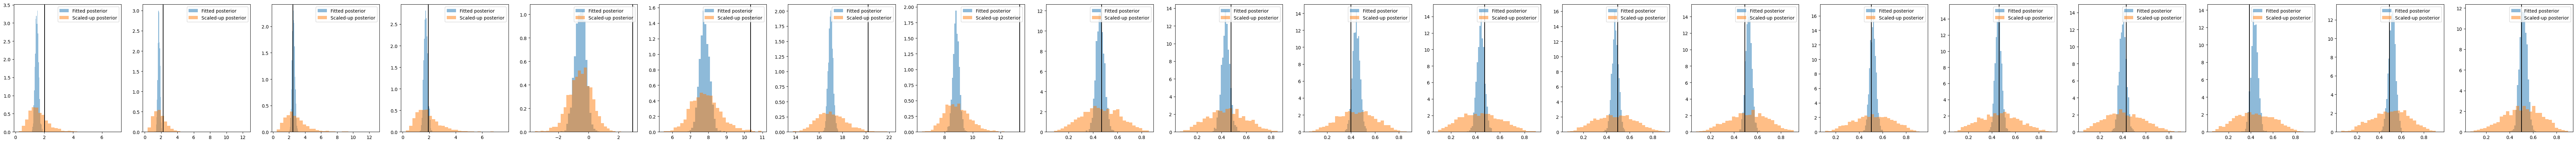

Running SBI...


Running 1000 simulations.: 100%|██████████| 1000/1000 [01:05<00:00, 15.38it/s]


 Neural network successfully converged after 84 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:00<00:00, 16.57it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:00<00:00, 16.47it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 48 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:00<00:00, 16.51it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 64 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:02<00:00, 16.08it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 53 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:06<00:00, 14.98it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 71 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:24<00:00, 11.85it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 43 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:22<00:00, 12.16it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:13<00:00, 13.53it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:17<00:00, 12.91it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.Sampling SBI posterior and point estimate...


Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:04<00:00, 478.31it/s]


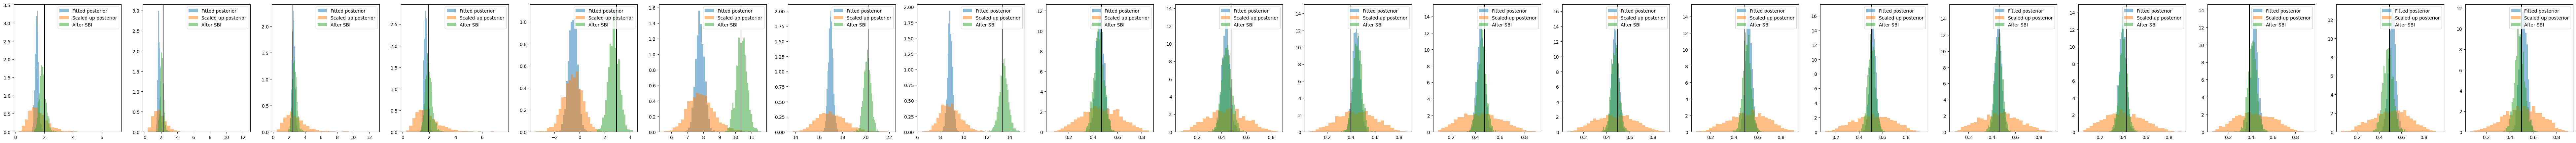

Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 139.86it/s]


In [35]:
parameter_mask = get_parameter_mask(posterior_params, ["Trange", "Tskew"])

sbi_posterior, samples_summary_stats, samples_obs = run_sbi(wgen, svi_result, observable_fct = case_study_6, obs_target = obs_stats_target, scale_factor = 2.5, parameter_mask = parameter_mask, num_samples = 2000, num_rounds = 10)


In [36]:
torch.save(samples_summary_stats, "sbi_results/case_study_6_samples_summary_stats.pt")
torch.save(samples_obs, "sbi_results/case_study_6_samples_obs.pt")


## Case study 7 (seasonal Tavg, pr, overall dry days const, tight prior)

In [38]:
def case_study_7(ts, precip, Tmin, Tavg, Tmax):
    """
    ts: [1, timesteps, 4], 4: index, year, month, doy
    precip, Tmin, Tavg, Tmax: [timesteps, realizations]
    Returns: [summary_stats, realizations]
    """
    winter = jnp.isin(ts[:, :, 2], jnp.array([12, 1, 2])).T
    spring = jnp.isin(ts[:, :, 2], jnp.array([3, 4, 5])).T
    summer = jnp.isin(ts[:, :, 2], jnp.array([6, 7, 8])).T
    autumn = jnp.isin(ts[:, :, 2], jnp.array([9, 10, 11])).T

    pmean_winter = jnp.nanmean(jnp.where(winter, precip, jnp.nan), axis = 0)
    pmean_spring = jnp.nanmean(jnp.where(spring, precip, jnp.nan), axis = 0)
    pmean_summer = jnp.nanmean(jnp.where(summer, precip, jnp.nan), axis = 0)
    pmean_autumn = jnp.nanmean(jnp.where(autumn, precip, jnp.nan), axis = 0)

    wet = (precip > 0)
    pavg_wet = jnp.nanmean(wet, axis = 0)
    
    Tavg_winter = jnp.nanmean(jnp.where(winter, Tavg, jnp.nan), axis = 0)
    Tavg_spring = jnp.nanmean(jnp.where(spring, Tavg, jnp.nan), axis = 0)
    Tavg_summer = jnp.nanmean(jnp.where(summer, Tavg, jnp.nan), axis = 0)
    Tavg_autumn = jnp.nanmean(jnp.where(autumn, Tavg, jnp.nan), axis = 0)

    #icy_days = jnp.mean(Tmax < 0, axis = 0)
    #heavy_rain = jnp.mean(precip > 20, axis = 0)

    return jnp.stack([pmean_winter, pmean_spring, pmean_summer, pmean_autumn, Tavg_winter, Tavg_spring, Tavg_summer, Tavg_autumn, pavg_wet])#, icy_days])

obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = case_study_7(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[ 1.5461818 ],
       [ 1.7449532 ],
       [ 2.4704154 ],
       [ 1.6852754 ],
       [-0.46448863],
       [ 7.7378182 ],
       [17.098232  ],
       [ 8.8563385 ],
       [ 0.4654244 ]], dtype=float32)

In [39]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn

obs_stats_target

Array([[ 2.0100362],
       [ 2.268439 ],
       [ 2.4704154],
       [ 1.9380667],
       [ 2.9355116],
       [10.337818 ],
       [20.198233 ],
       [13.3563385],
       [ 0.4654244]], dtype=float32)

Run SBI:

Sampling...


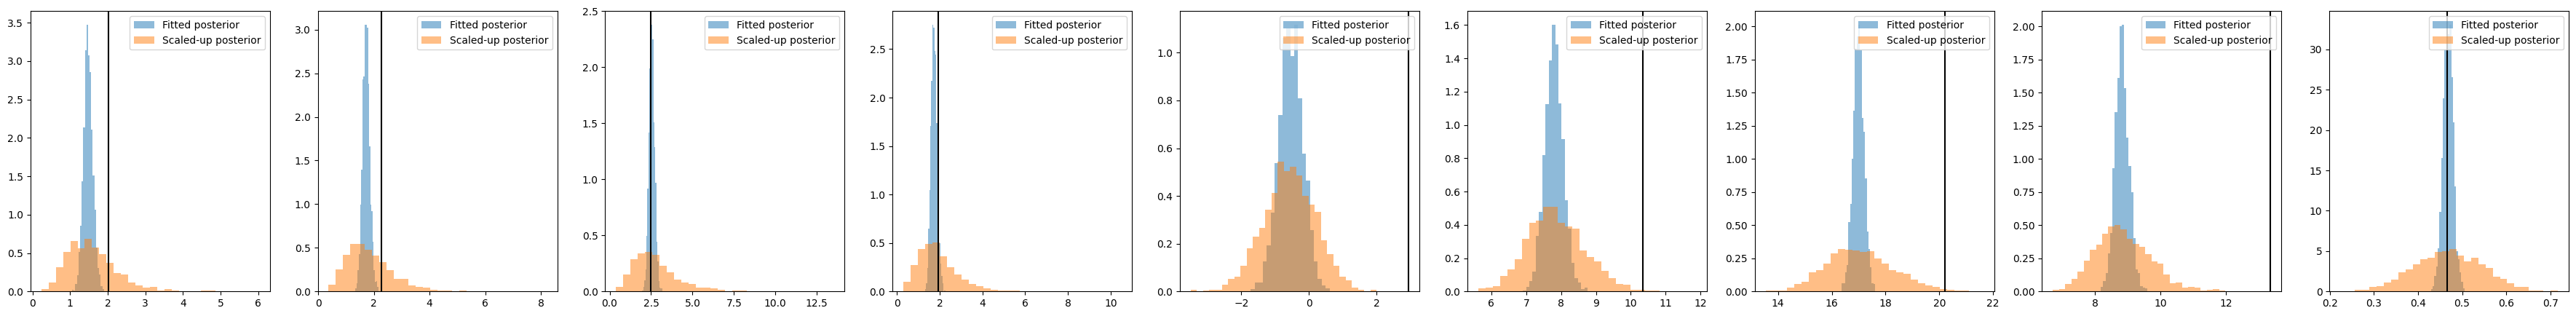

Running SBI...


Running 1000 simulations.: 100%|██████████| 1000/1000 [01:19<00:00, 12.63it/s]


 Neural network successfully converged after 81 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:20<00:00, 12.45it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 42 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:17<00:00, 12.92it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 52 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:10<00:00, 14.21it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 46 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:01<00:00, 16.31it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:59<00:00, 16.81it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:59<00:00, 16.93it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 63 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:59<00:00, 16.89it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:06<00:00, 15.04it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:13<00:00, 13.56it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.Sampling SBI posterior and point estimate...


Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:02<00:00, 837.31it/s]


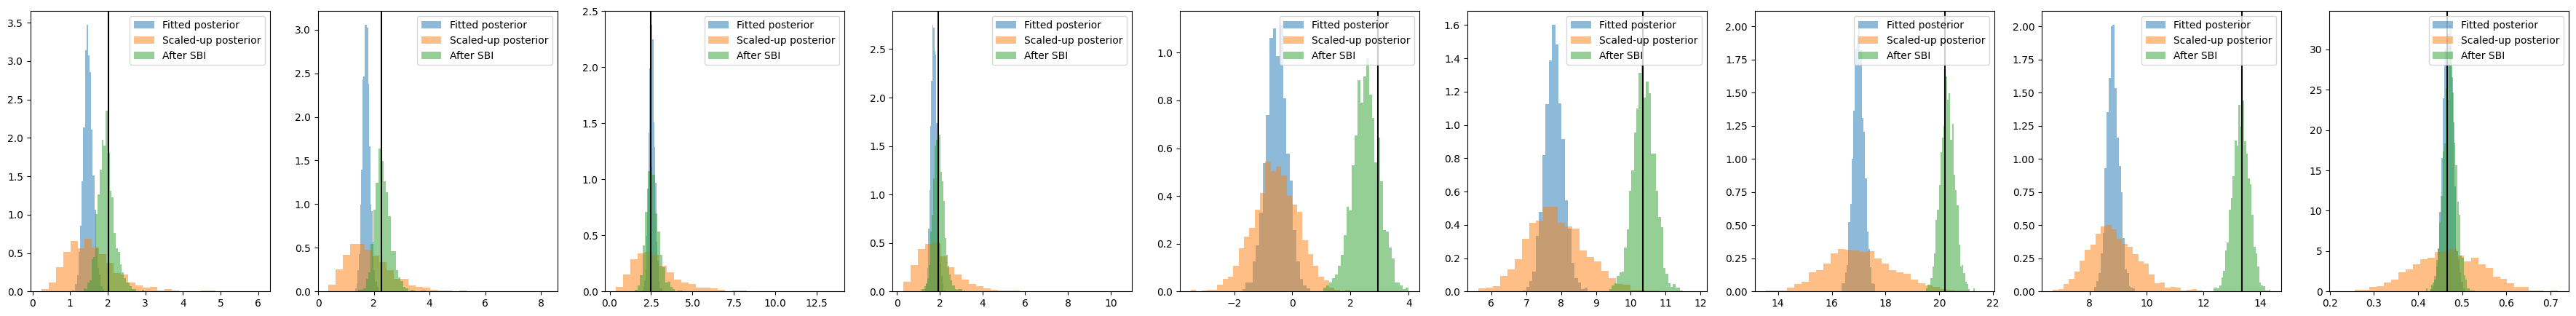

Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 216.68it/s]


In [41]:
parameter_mask = get_parameter_mask(posterior_params, ["Trange", "Tskew", "precip_occ_"])

sbi_posterior, samples_summary_stats, samples_obs = run_sbi(wgen, svi_result, observable_fct = case_study_7, obs_target = obs_stats_target, scale_factor = 2.5, parameter_mask = parameter_mask, num_samples = 2000, num_rounds = 10)


In [42]:
torch.save(samples_summary_stats, "sbi_results/case_study_7_samples_summary_stats.pt")
torch.save(samples_obs, "sbi_results/case_study_7_samples_obs.pt")


## Case study 8 (like 8 but no dry day prior):

Trend in tavg, precip, dry days constant:

In [291]:
def case_study_1(ts, precip, Tmin, Tavg, Tmax):
    pmean = jnp.mean(precip, axis = 0)
    pavgwet = jnp.mean(precip > 0, axis = 0)
    Tavgmean = jnp.mean(Tavg, axis = 0)
    return jnp.stack([pmean, pavgwet, Tavgmean])

In [293]:
obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = case_study_1(wgen.timestamps[0,:,:], obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[1.8636943],
       [0.4654244],
       [8.347303 ]], dtype=float32)

In [295]:
obs_stats_target = obs_stats
obs_stats_target = obs_stats_target.at[0].mul(1.2)
obs_stats_target = obs_stats_target.at[2].add(3.5)
obs_stats_target

Array([[ 2.2364333],
       [ 0.4654244],
       [11.847303 ]], dtype=float32)

Sampling...


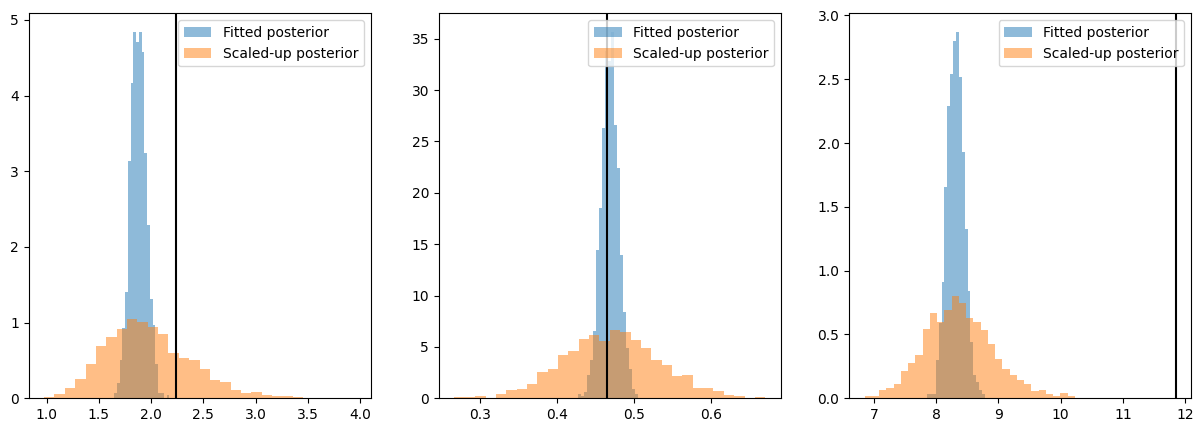

Running SBI...


Running 1000 simulations.: 100%|██████████| 1000/1000 [01:07<00:00, 14.72it/s]


 Neural network successfully converged after 65 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:12<00:00, 13.85it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 72 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:06<00:00, 14.95it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:05<00:00, 15.35it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 58 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:04<00:00, 15.47it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 40 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:16<00:00, 13.09it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:16<00:00, 13.05it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 34 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:04<00:00, 15.53it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:10<00:00, 14.26it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:01<00:00, 16.24it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.Sampling SBI posterior and point estimate...


Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:02<00:00, 746.17it/s]


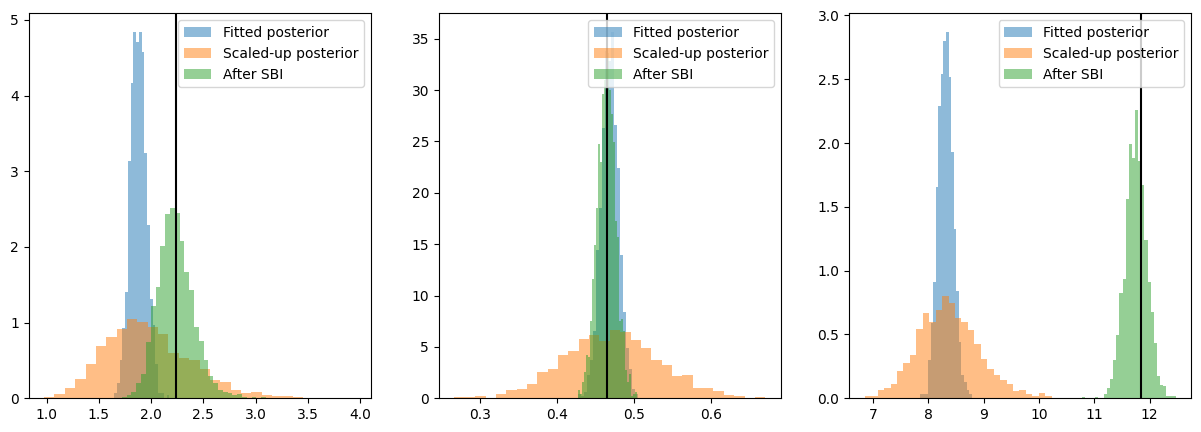

Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 211.54it/s]


In [296]:
parameter_mask = get_parameter_mask(posterior_params, ["Trange", "Tskew", "precip_occ_"])

sbi_posterior, samples_summary_stats, samples_obs = run_sbi(wgen, svi_result, observable_fct = case_study_1, obs_target = obs_stats_target, scale_factor = 2., parameter_mask = parameter_mask, num_samples = 2000, num_rounds = 10)


In [298]:
torch.save(samples_summary_stats, "sbi_results/case_study_8_samples_summary_stats.pt")
torch.save(samples_obs, "sbi_results/case_study_8_samples_obs.pt")


In [301]:
obs_hist = t2j(samples_obs["mean_fitted_posterior"])
obs_fut = t2j(samples_obs["sbi_posterior_point_estimate"])

pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

Text(0.5, 1.0, 'Average temperature')

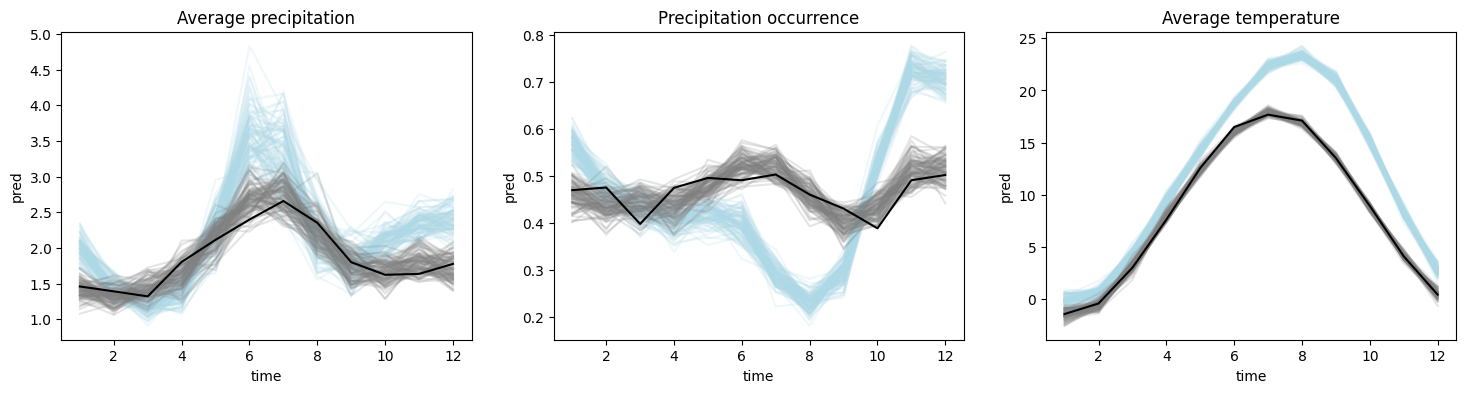

In [304]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
#add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation")

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1])
#add_seasonal_targets(obs_stats_target[4:9], axs[1])
axs[1].set_title("Precipitation occurrence")

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
#add_seasonal_targets(obs_stats_target[8:], axs[2])
axs[2].set_title("Average temperature")


#plt.savefig("plots/case_study_3a_ensemble.png", dpi = 300)

# Analysis

In [70]:
def make_line_plots(fut, hist, obs, time, target = None, ax = None):
    if ax is None:
        fig, ax = plt.subplots(figsize = (6,4))
        
    df_preds = pd.DataFrame(fut.squeeze().T)
    df_preds["time"] = time
    df_preds = df_preds.melt(id_vars="time", value_name="pred")
    df_preds = df_preds.groupby([df_preds.time.dt.month, df_preds.variable]).mean().drop(columns="time").reset_index()
    sns.lineplot(df_preds, x = "time", y = "pred", units = "variable", estimator = None, color = "lightblue", alpha = 0.2, ax = ax)
    
    df_preds = pd.DataFrame(hist.squeeze().T)
    df_preds["time"] = time
    df_preds = df_preds.melt(id_vars="time", value_name="pred")
    df_preds = df_preds.groupby([df_preds.time.dt.month, df_preds.variable]).mean().drop(columns="time").reset_index()
    sns.lineplot(df_preds, x = "time", y = "pred", units = "variable", estimator = None, color = "grey", alpha = 0.2, ax = ax)
    
    df_obs = pd.DataFrame({"obs": obs.squeeze(), "time": basin_data_train.index})
    df_obs = df_obs.groupby(df_obs.time.dt.month)["obs"].mean().reset_index()
    sns.lineplot(df_obs, x="time", y="obs", color = "black", ax = ax)

    if target is not None:
        ax.axhline(target, color = "lightblue", linestyle = "dashed")

def add_seasonal_targets(targets, ax):
    ax.hlines(y = targets[0], xmin = 1, xmax = 2.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[1], xmin = 2.5, xmax = 5.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[2], xmin = 5.5, xmax = 8.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[3], xmin = 8.5, xmax = 11.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[0], xmin = 11.5, xmax = 12, color = "darkblue", linestyle = "dashed")


## Case study 1

In [97]:
samples_summary_stats = torch.load("sbi_results/case_study_1_samples_summary_stats.pt")
samples_obs = torch.load("sbi_results/case_study_1_samples_obs.pt")

In [101]:
obs_stats_target = case_study_1(wgen.timestamps[0,:,:], obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats_target = obs_stats_target.at[0].mul(1.2)
obs_stats_target = obs_stats_target.at[2].add(3.5)


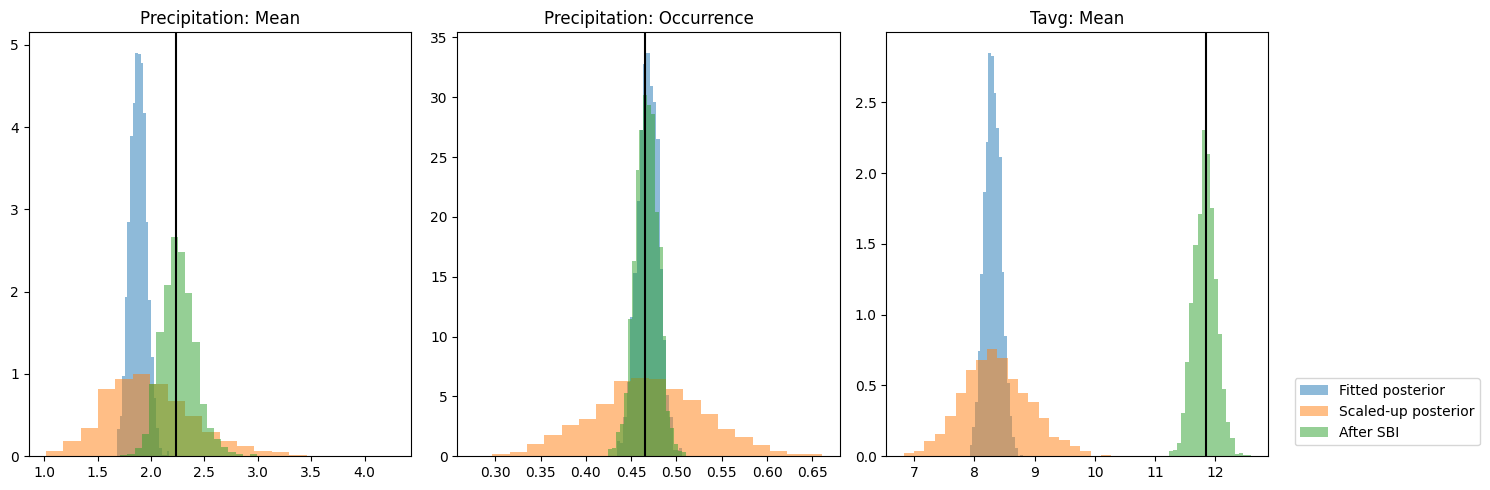

In [606]:
# Plot
titles = ["Precipitation: Mean", "Precipitation: Occurrence", "Tavg: Mean"]
fig, axs = plt.subplots(1, obs_stats_target.shape[0], figsize = (obs_stats_target.shape[0]*5, 5), layout="tight")
for i in range(obs_stats_target.shape[0]):
    axs[i].hist(samples_summary_stats["fitted_posterior"][:, i].numpy(), bins = 20, density = True, alpha = 0.5, label = "Fitted posterior")
    axs[i].hist(samples_summary_stats["sbi_proposal"][:, i].numpy(), bins = 20, density = True, alpha = 0.5, label = "Scaled-up posterior")
    axs[i].hist(samples_summary_stats["sbi_posterior"][:, i].numpy(), bins = 20, density = True, alpha = 0.5, label = "After SBI")
    axs[i].set_title(titles[i])
    axs[i].axvline(obs_stats_target[i,:].flatten(), c= "black")
axs[-1].legend(bbox_to_anchor = (1.05, 0.2))
plt.savefig("plots/case_study_1.png", dpi = 300)


In [103]:
obs_hist = samples_obs["mean_fitted_posterior"]
obs_fut = samples_obs["sbi_posterior_point_estimate"]

pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

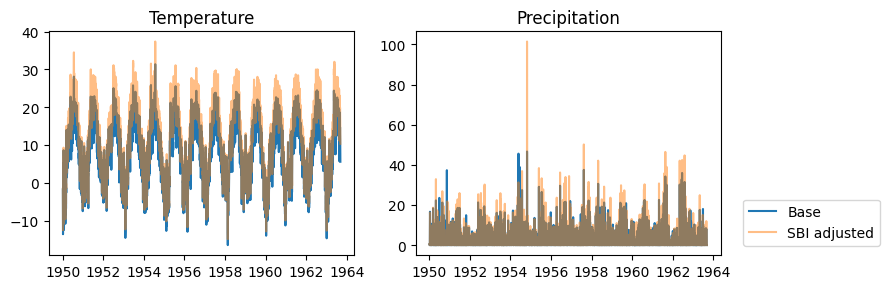

In [616]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 3), layout = "tight")

ax1.plot(basin_data_train.index[:5000], tavg_hist[0, :5000], label = "Base")
ax1.plot(basin_data_train.index[:5000], tavg_fut[0, :5000], alpha = 0.5, label = "SBI adjusted")
ax1.set_title("Temperature")

ax2.plot(basin_data_train.index[:5000], pr_hist[0, :5000], label = "Base")
ax2.plot(basin_data_train.index[:5000], pr_fut[0, :5000], alpha = 0.5, label = "SBI adjusted")
ax2.legend(bbox_to_anchor = (1.05, 0.28))
ax2.set_title("Precipitation")

plt.savefig("plots/case_study_1_temp_precip.png")

In [636]:
obs_stats_target

Array([[ 2.2364333],
       [ 0.4654244],
       [11.847303 ]], dtype=float32)

In [646]:
case_study_1(jnp.expand_dims(wgen.timestamps[0,:,:], 0), *t2j(obs_fut.swapaxes(-1, 0))).std(axis = 1)


Array([0.06650788, 0.00709333, 0.09607991], dtype=float32)

In [644]:
case_study_1(jnp.expand_dims(wgen.timestamps[0,:,:], 0), *t2j(obs_hist.swapaxes(-1, 0))).std(axis = 1)


Array([0.04911849, 0.00675225, 0.08744124], dtype=float32)

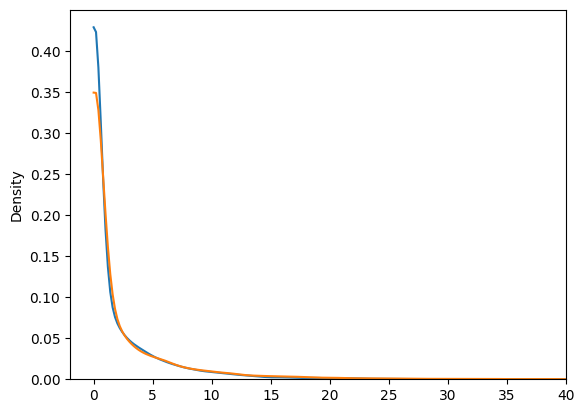

(array([  2.,  12.,  28.,  53., 123., 205., 328., 461., 567., 629., 659.,
        661., 588., 568., 524., 484., 504., 597., 643., 766., 798., 746.,
        620., 388., 227.,  97.,  30.,  11.,   3.,   1.]),
 array([-14.92252254, -13.17900753, -11.43549252,  -9.6919775 ,
         -7.94846249,  -6.20494747,  -4.46143246,  -2.71791768,
         -0.97440267,   0.76911229,   2.51262736,   4.25614214,
          5.99965715,   7.74317217,   9.48668766,  11.23020172,
         12.97371674,  14.71723175,  16.46074677,  18.20426178,
         19.94777679,  21.69129181,  23.43480682,  25.17832184,
         26.92183685,  28.66535187,  30.40886688,  32.1523819 ,
         33.89589691,  35.63941193,  37.38292694]),
 <BarContainer object of 30 artists>)

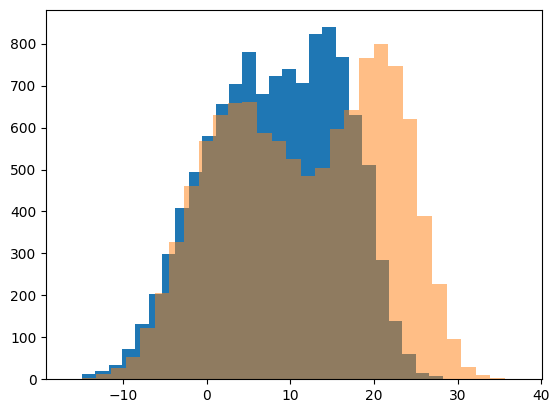

In [702]:
sns.kdeplot(pr_hist[0, :], clip = (0, 40))
sns.kdeplot(pr_fut[0, :], clip = (0, 40))
plt.xlim(-2, 40)
plt.show()

plt.hist(tavg_hist[0, :], bins = 30)
plt.hist(tavg_fut[0, :], bins = 30, alpha = 0.5)


In [744]:
case_study_5(jnp.expand_dims(wgen.timestamps[0,:,:], 0), *t2j(obs_fut.swapaxes(-1, 0))).mean(axis = 1)

Array([11.746672  ,  2.1887789 ,  0.01535812,  0.06555507,  0.08479732,
        7.91583   ], dtype=float32)

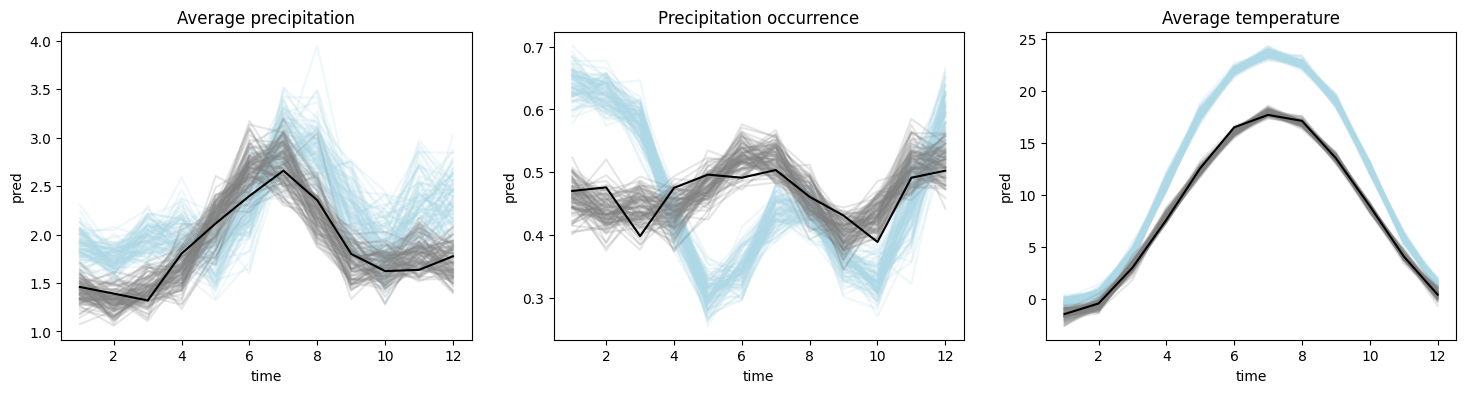

In [109]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
#add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation")

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1])
#add_seasonal_targets(obs_stats_target[4:9], axs[1])
axs[1].set_title("Precipitation occurrence")

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
#add_seasonal_targets(obs_stats_target[8:], axs[2])
axs[2].set_title("Average temperature")

plt.savefig("plots/case_study_1_summary_plots.png")

## Case study 2 (5)

In [1049]:
samples_summary_stats = torch.load("sbi_results/case_study_5_samples_summary_stats.pt")
samples_obs = torch.load("sbi_results/case_study_5_samples_obs.pt")

In [1050]:
obs_stats_target = case_study_5(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats_target = obs_stats_target.at[0].add(3.1) # Tavg 
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean 
obs_stats_target = obs_stats_target.at[2].mul(2.) # heavy_rain
obs_stats_target = obs_stats_target.at[3].set(0.01) # icy_days: 3 per year
obs_stats_target = obs_stats_target.at[4].set(0.08) # tropical_nights: 30 per year
obs_stats_target = obs_stats_target.at[5].mul(1.2) # Trangemean



Case study 5:

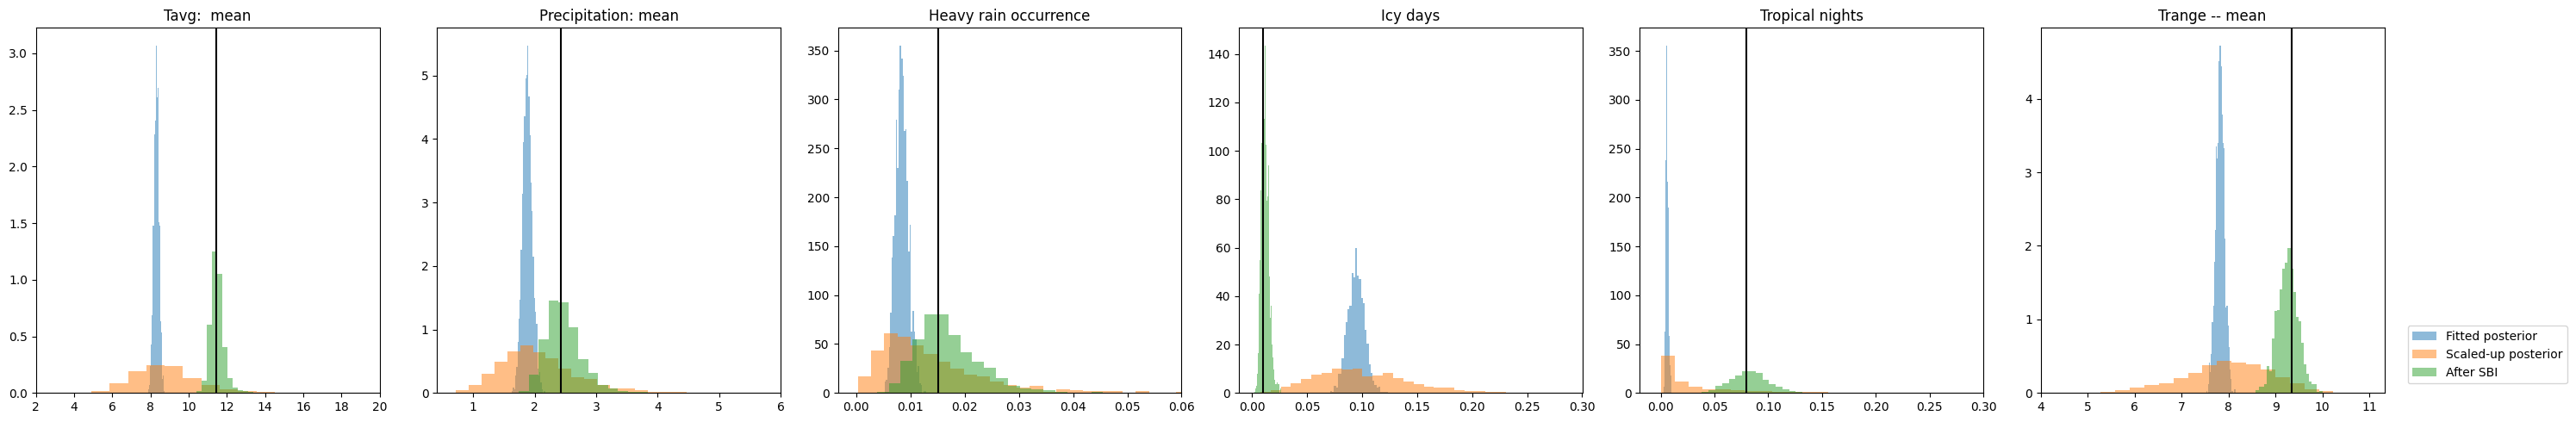

In [740]:
# Plot
titles = ["Tavg:  mean", "Precipitation: mean", "Heavy rain occurrence", "Icy days", "Tropical nights", "Trange -- mean"]
left_xlims = [2, None, None, None, None, 4]
right_xlims = [20, 6, 0.06, None, 0.30, None]

fig, axs = plt.subplots(1, obs_stats_target.shape[0], figsize = (obs_stats_target.shape[0]*5, 5), layout = "tight")
for i in range(obs_stats_target.shape[0]):
    axs[i].hist(samples_summary_stats["fitted_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Fitted posterior")
    axs[i].hist(samples_summary_stats["sbi_proposal"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Scaled-up posterior")
    axs[i].hist(samples_summary_stats["sbi_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "After SBI")
    #axs[i].legend(loc = "upper right")
    axs[i].set_title(titles[i])
    axs[i].axvline(obs_stats_target[i,:].flatten(), c= "black")
    axs[i].set_xlim(left = left_xlims[i], right = right_xlims[i])
axs[-1].legend(bbox_to_anchor = (1.05, 0.2))
#plt.savefig("plots/case_study_2.png", dpi = 300)

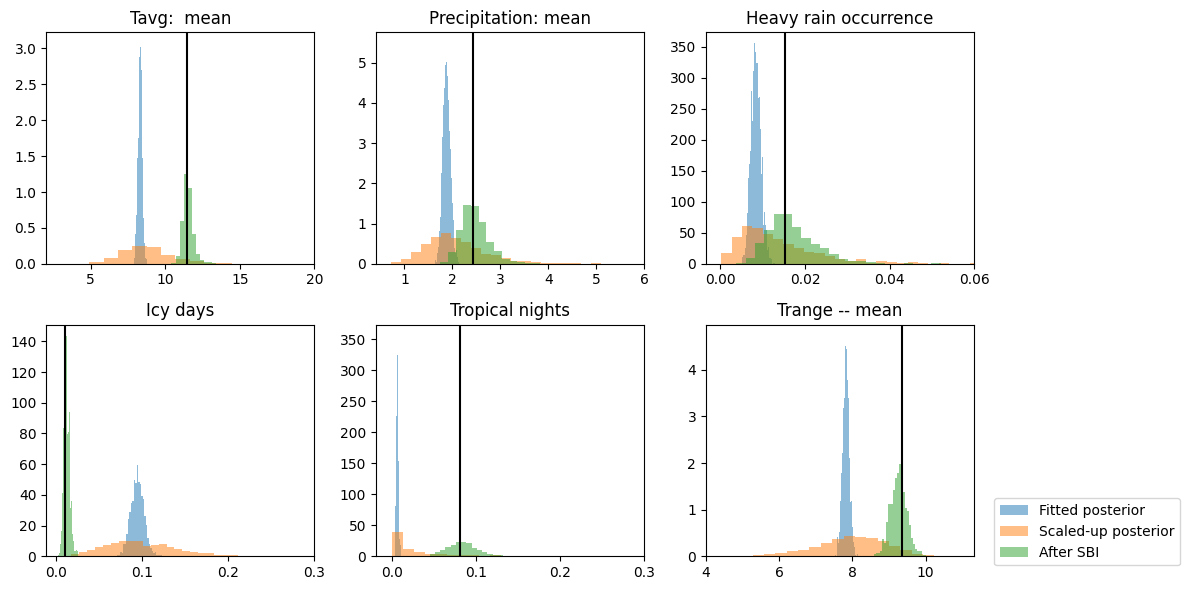

In [933]:
# Plot
titles = ["Tavg:  mean", "Precipitation: mean", "Heavy rain occurrence", "Icy days", "Tropical nights", "Trange -- mean"]
left_xlims = [2, None, None, None, None, 4]
right_xlims = [20, 6, 0.06, None, 0.30, None]

fig, axs = plt.subplots(2, 3, figsize = (12, 6), layout = "tight")
axs = axs.ravel()
for i in range(obs_stats.shape[0]):
    axs[i].hist(samples_summary_stats["fitted_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Fitted posterior")
    axs[i].hist(samples_summary_stats["sbi_proposal"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Scaled-up posterior")
    axs[i].hist(samples_summary_stats["sbi_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "After SBI")
    #axs[i].legend(loc = "upper right")
    axs[i].set_title(titles[i])
    axs[i].axvline(obs_stats_target[i,:].flatten(), c= "black")
    axs[i].set_xlim(left = left_xlims[i], right = right_xlims[i])
axs[-1].legend(bbox_to_anchor = (1.05, 0.28))
plt.savefig("plots/case_study_2.png", dpi = 300)

In [1053]:
obs_hist = t2j(samples_obs["mean_fitted_posterior"])
obs_fut = t2j(samples_obs["sbi_posterior_point_estimate"])

In [1055]:
pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0].T, obs_hist[:, :, 1].T, obs_hist[:, :, 2].T, obs_hist[:, :, 3].T
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0].T, obs_fut[:, :, 1].T, obs_fut[:, :, 2].T, obs_fut[:, :, 3].T

In [481]:
tavg_hist.shape

(100, 11323)

In [1059]:
obs_hist = t2j(samples_obs["mean_fitted_posterior"])
obs_fut = t2j(samples_obs["sbi_posterior_point_estimate"])

pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

Text(0.5, 1.0, 'Precipitation')

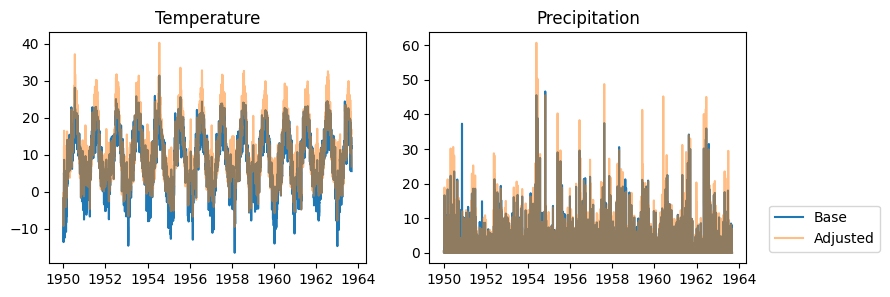

In [900]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 3))

ax1.plot(basin_data_train.index[:5000], tavg_hist[0, :5000], label = "Base")
ax1.plot(basin_data_train.index[:5000], tavg_fut[0, :5000], alpha = 0.5, label = "Adjusted")
ax1.set_title("Temperature")

ax2.plot(basin_data_train.index[:5000], pr_hist[0, :5000], label = "Base")
ax2.plot(basin_data_train.index[:5000], pr_fut[0, :5000], alpha = 0.5, label = "Adjusted")
ax2.legend(bbox_to_anchor = (1.05, 0.28))
ax2.set_title("Precipitation")

Text(0.5, 1.0, 'Maximum temperature')

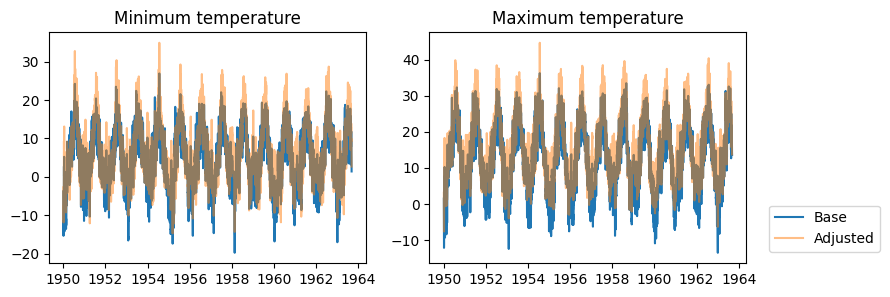

In [904]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 3))

ax1.plot(basin_data_train.index[:5000], tmin_hist[0, :5000], label = "Base")
ax1.plot(basin_data_train.index[:5000], tmin_fut[0, :5000], alpha = 0.5, label = "Adjusted")
ax1.set_title("Minimum temperature")

ax2.plot(basin_data_train.index[:5000], tmax_hist[0, :5000], label = "Base")
ax2.plot(basin_data_train.index[:5000], tmax_fut[0, :5000], alpha = 0.5, label = "Adjusted")
ax2.legend(bbox_to_anchor = (1.05, 0.28))
ax2.set_title("Maximum temperature")


NameError: name 'trange_fut' is not defined

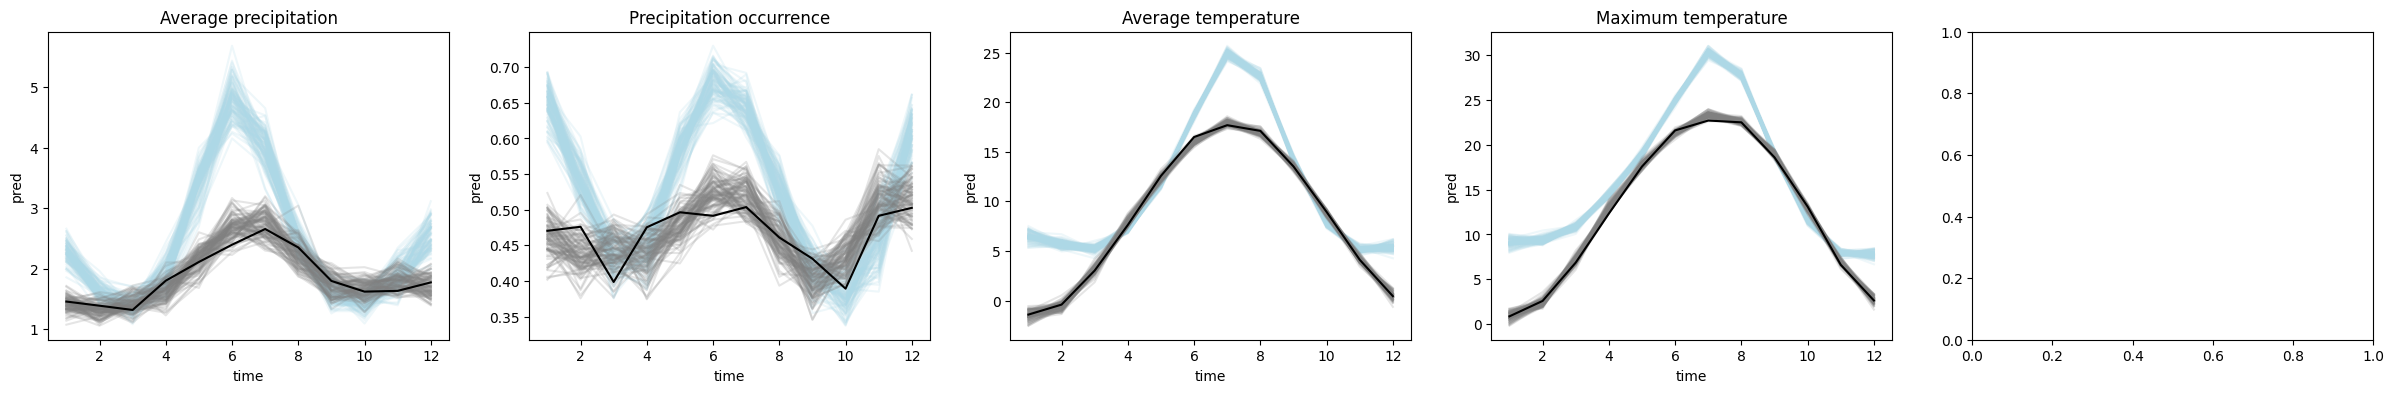

In [1073]:
fig, axs = plt.subplots(1,5, figsize = (30,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
#add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation")

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1])
#add_seasonal_targets(obs_stats_target[4:9], axs[1])
axs[1].set_title("Precipitation occurrence")

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
#add_seasonal_targets(obs_stats_target[8:], axs[2])
axs[2].set_title("Average temperature")


make_line_plots(tmax_fut, tmax_hist, obs["Tmax"], basin_data_train.index, ax = axs[3])
#add_seasonal_targets(obs_stats_target[8:], axs[2])
axs[3].set_title("Maximum temperature")

make_line_plots(trange_fut, trange_hist, obs["Trange"], basin_data_train.index, ax = axs[4])
#add_seasonal_targets(obs_stats_target[8:], axs[2])
axs[4].set_title("Minimum temperature")


In [1075]:
trange_fut = tmax_fut - tmin_fut
trange_hist = tmax_hist - tmin_hist
tskew_fut = (tavg_fut - tmin_fut)/trange_fut
tskew_hist = (tavg_hist - tmin_hist)/trange_hist

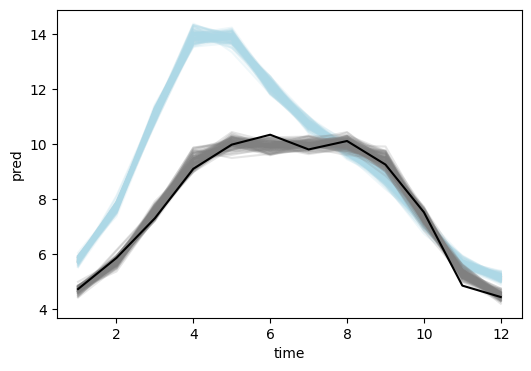

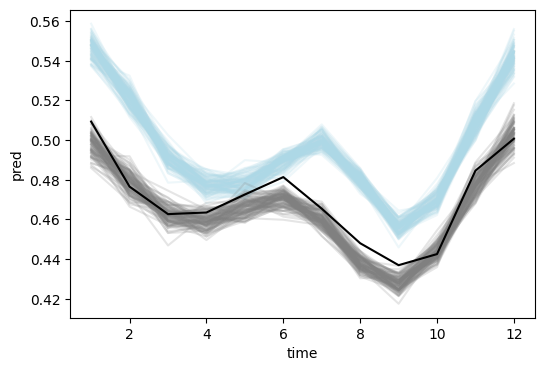

In [1081]:
make_line_plots(trange_fut, trange_hist, obs["Trange"], basin_data_train.index)
make_line_plots(tskew_fut, tskew_hist, obs["Tskew"], basin_data_train.index)


## Case study 3 (2,3)

### Overview part a)

In [221]:
samples_summary_stats = torch.load("sbi_results/case_study_2_samples_summary_stats.pt")
samples_obs = torch.load("sbi_results/case_study_2_samples_obs.pt")

In [224]:
obs_stats_target = case_study_2(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[8].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[9].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[10].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[11].add(4.5) # Tavg autumn

#obs_stats_target = obs_stats_target.at[12].add(-0.06) # icy days

obs_stats_target

Array([[ 2.0100362 ],
       [ 2.268439  ],
       [ 2.4704154 ],
       [ 1.9380667 ],
       [ 0.48320228],
       [ 0.45652175],
       [ 0.48527348],
       [ 0.43672457],
       [ 2.9355116 ],
       [10.337818  ],
       [20.198233  ],
       [13.3563385 ]], dtype=float32)

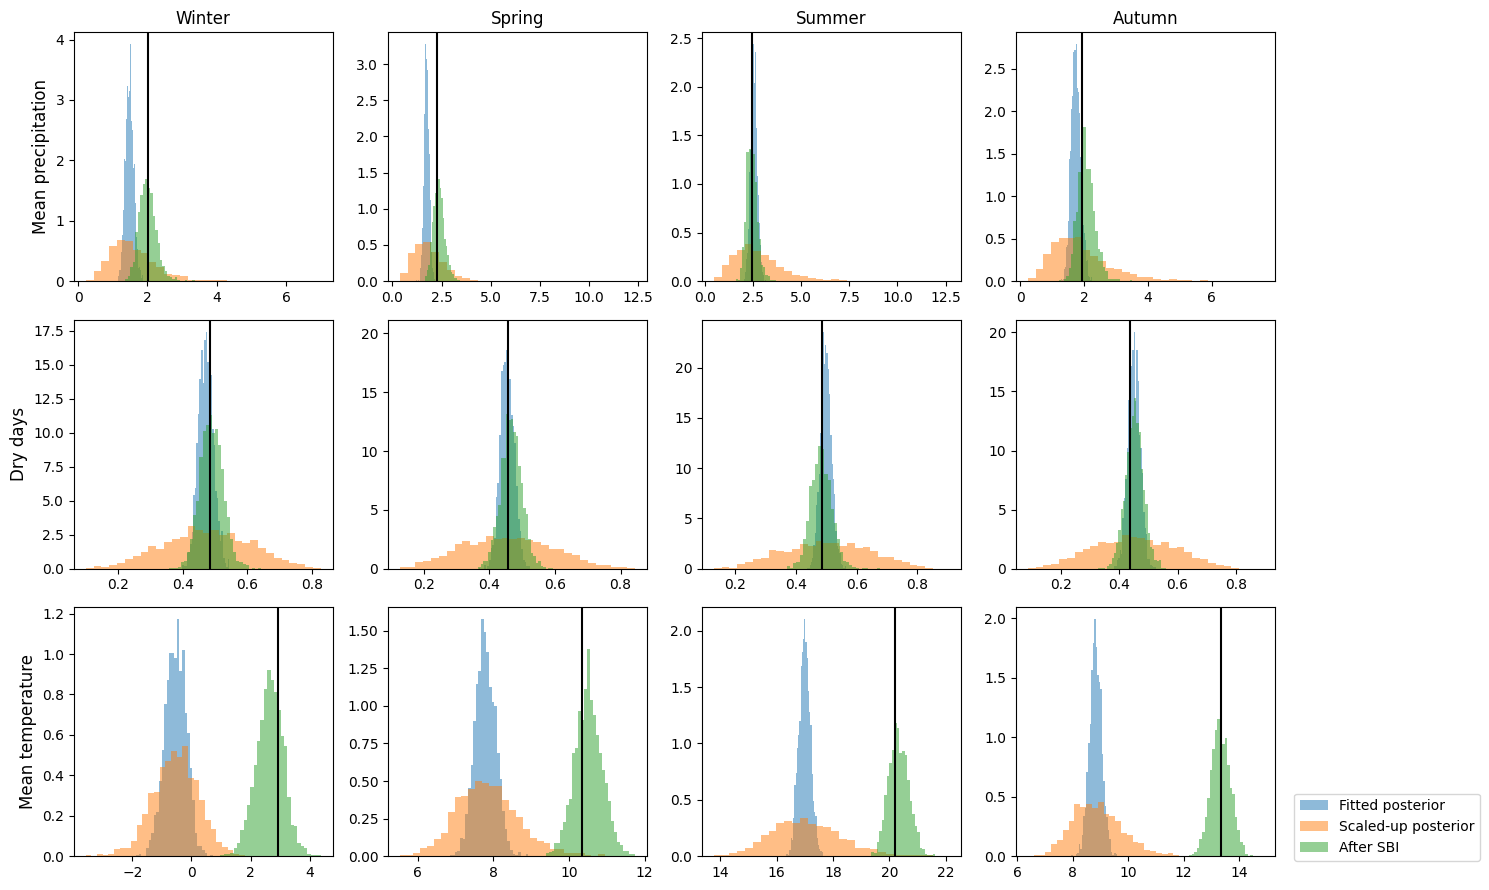

In [225]:
titles = ["Pmean: Winter", "Pmean: Spring", "Pmean: Summer", "Pmean: Autumn", "Tavg:  mean", "Precipitation: mean", "Heavy rain occurrence", "Icy days", "Tropical nights", "Trange -- mean"]
left_xlims = [2, None, None, None, None, 4]
right_xlims = [20, 6, 0.06, None, 0.30, None]

fig, axs = plt.subplots(3, 4, figsize = (15, 9), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation", size = "large")
axs[1, 0].set_ylabel("Dry days", size = "large")
axs[2, 0].set_ylabel("Mean temperature", size = "large")

axs = axs.ravel()
axs[0].set_title("Winter")
axs[1].set_title("Spring")
axs[2].set_title("Summer")
axs[3].set_title("Autumn")

for i in range(obs_stats_target.shape[0]):
    axs[i].hist(samples_summary_stats["fitted_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Fitted posterior")
    axs[i].hist(samples_summary_stats["sbi_proposal"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Scaled-up posterior")
    axs[i].hist(samples_summary_stats["sbi_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "After SBI")
    #axs[i].legend(loc = "upper right")
    #axs[i].set_title(titles[i])
    axs[i].axvline(obs_stats_target[i,:].flatten(), c= "black")
    #axs[i].set_xlim(left = left_xlims[i], right = right_xlims[i])
axs[-1].legend(bbox_to_anchor = (1.05, 0.28))
#plt.savefig("plots/case_study_3a.png", dpi = 300)

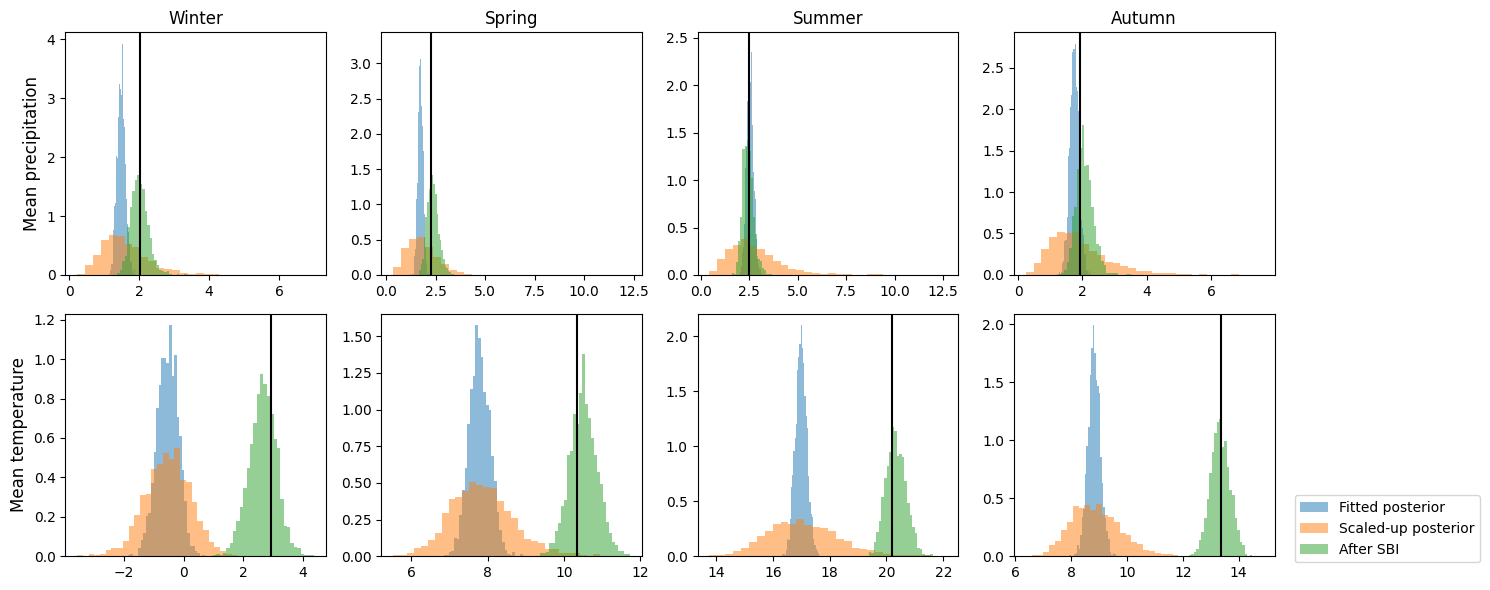

In [227]:
# Plot
idxs = [0, 1, 2, 3, 8, 9, 10, 11]
samples_summary_stats_reduced_plot = dict()
samples_summary_stats_reduced_plot["fitted_posterior"] = samples_summary_stats["fitted_posterior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_proposal"] = samples_summary_stats["sbi_proposal"][:, idxs]
samples_summary_stats_reduced_plot["sbi_posterior"] = samples_summary_stats["sbi_posterior"][:, idxs]
obs_stats_target_reduced_plot = obs_stats_target[idxs, :]

fig, axs = plt.subplots(2, 4, figsize = (15, 6), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation", size = "large")
axs[1, 0].set_ylabel("Mean temperature", size = "large")

axs = axs.ravel()
axs[0].set_title("Winter")
axs[1].set_title("Spring")
axs[2].set_title("Summer")
axs[3].set_title("Autumn")

for i in range(obs_stats_target_reduced_plot.shape[0]):
    axs[i].hist(samples_summary_stats_reduced_plot["fitted_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Fitted posterior")
    axs[i].hist(samples_summary_stats_reduced_plot["sbi_proposal"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Scaled-up posterior")
    axs[i].hist(samples_summary_stats_reduced_plot["sbi_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "After SBI")
    #axs[i].legend(loc = "upper right")
    #axs[i].set_title(titles[i])
    axs[i].axvline(obs_stats_target_reduced_plot[i,:].flatten(), c= "black")
    #axs[i].set_xlim(left = left_xlims[i], right = right_xlims[i])
axs[-1].legend(bbox_to_anchor = (1.05, 0.28))
plt.savefig("plots/case_study_3a.png", dpi = 300)

In [209]:
obs_hist = t2j(samples_obs["mean_fitted_posterior"])
obs_fut = t2j(samples_obs["sbi_posterior_point_estimate"])

pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

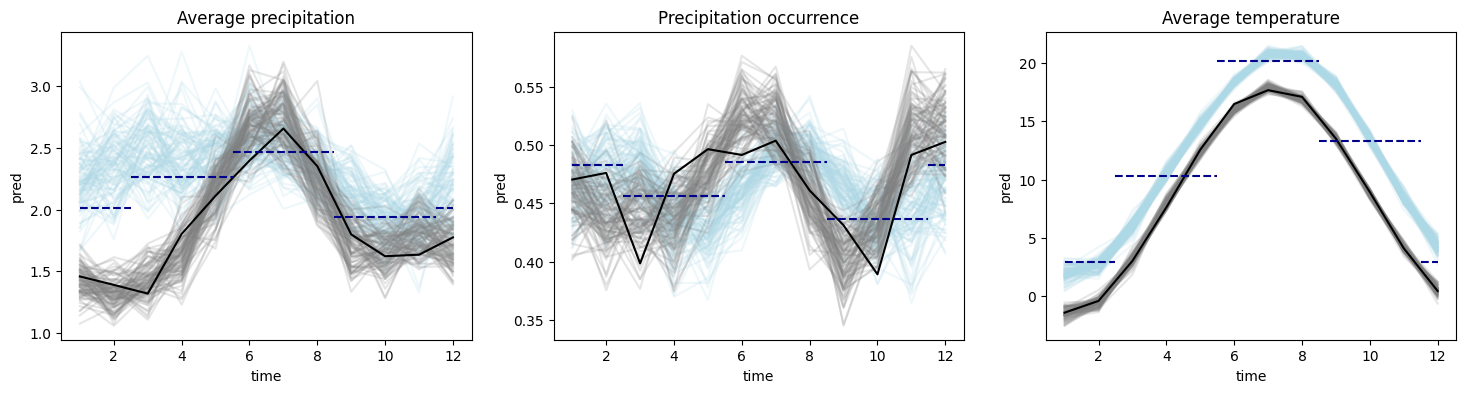

In [211]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation")

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1])
add_seasonal_targets(obs_stats_target[4:9], axs[1])
axs[1].set_title("Precipitation occurrence")

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[8:], axs[2])
axs[2].set_title("Average temperature")


plt.savefig("plots/case_study_3a_ensemble.png", dpi = 300)

### Overview part b)

In [185]:
samples_summary_stats = torch.load("sbi_results/case_study_3_samples_summary_stats.pt")
samples_obs = torch.load("sbi_results/case_study_3_samples_obs.pt")

In [187]:
obs_stats_target = case_study_3(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn


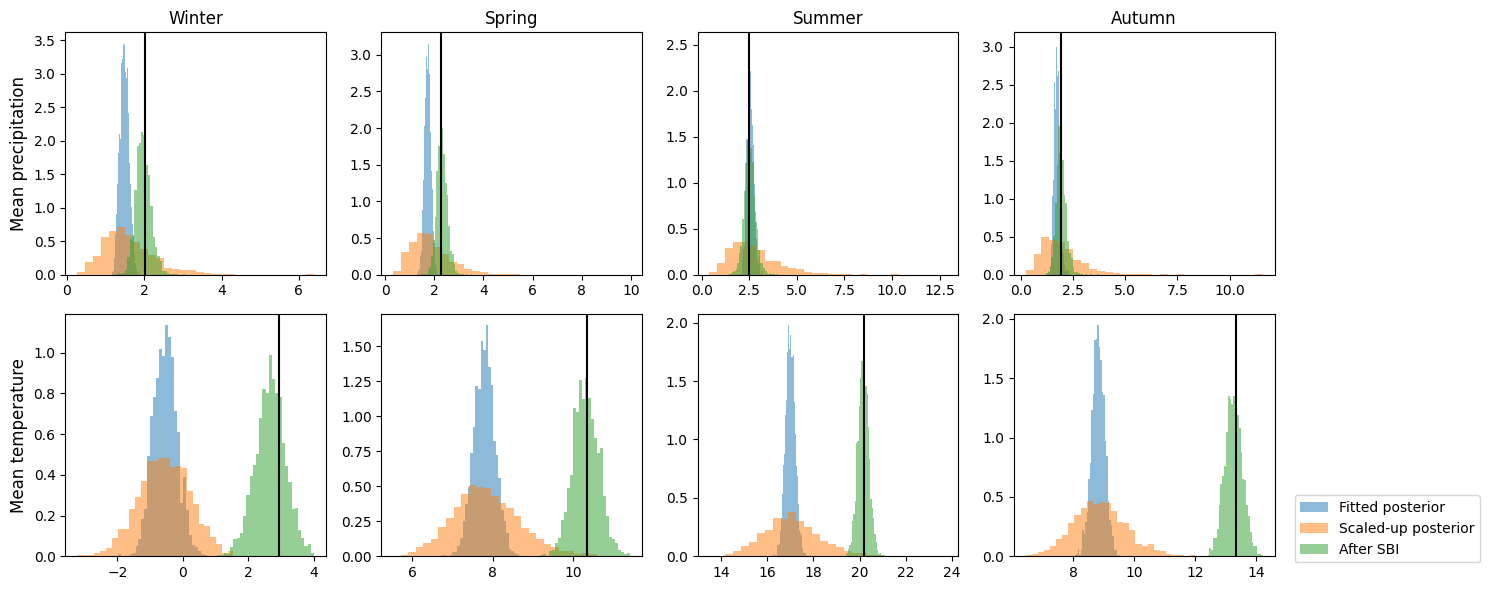

In [966]:
# Plot
titles = ["Pmean: Winter", "Pmean: Spring", "Pmean: Summer", "Pmean: Autumn", "Tavg:  mean", "Precipitation: mean", "Heavy rain occurrence", "Icy days", "Tropical nights", "Trange -- mean"]
left_xlims = [2, None, None, None, None, 4]
right_xlims = [20, 6, 0.06, None, 0.30, None]

fig, axs = plt.subplots(2, 4, figsize = (15, 6), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation", size = "large")
axs[1, 0].set_ylabel("Mean temperature", size = "large")

axs = axs.ravel()
axs[0].set_title("Winter")
axs[1].set_title("Spring")
axs[2].set_title("Summer")
axs[3].set_title("Autumn")

for i in range(obs_stats_target.shape[0]):
    axs[i].hist(samples_summary_stats["fitted_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Fitted posterior")
    axs[i].hist(samples_summary_stats["sbi_proposal"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Scaled-up posterior")
    axs[i].hist(samples_summary_stats["sbi_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "After SBI")
    #axs[i].legend(loc = "upper right")
    #axs[i].set_title(titles[i])
    axs[i].axvline(obs_stats_target[i,:].flatten(), c= "black")
    #axs[i].set_xlim(left = left_xlims[i], right = right_xlims[i])
axs[-1].legend(bbox_to_anchor = (1.05, 0.28))
plt.savefig("plots/case_study_3b.png", dpi = 300)

In [189]:
obs_hist = t2j(samples_obs["mean_fitted_posterior"])
obs_fut = t2j(samples_obs["sbi_posterior_point_estimate"])

pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

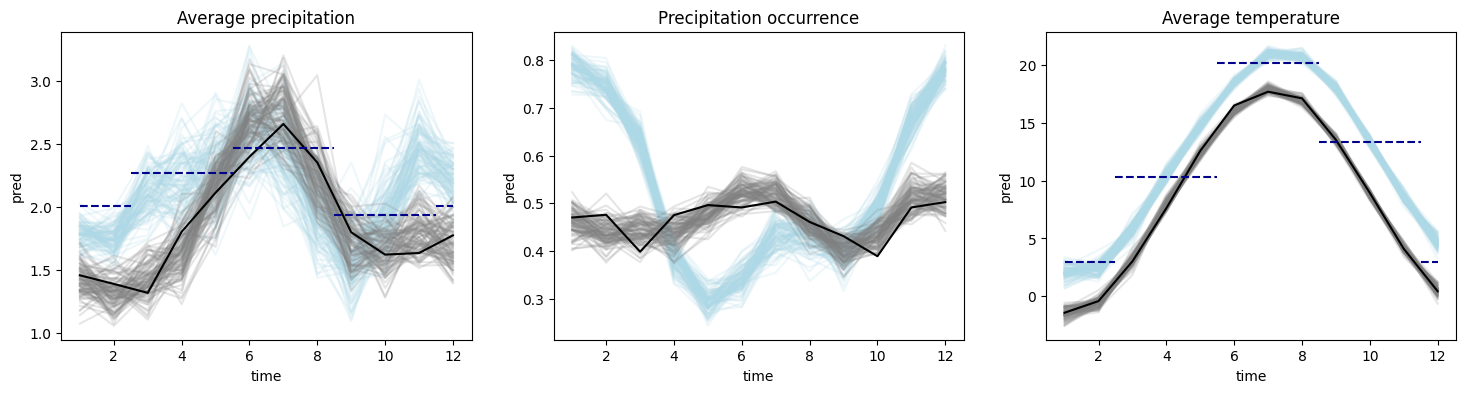

In [191]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation")

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1])
#add_seasonal_targets(obs_stats_target[4:9], axs[1])
axs[1].set_title("Precipitation occurrence")

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature")
plt.savefig("plots/case_study_3b_ensemble.png")

### Overview part c)

In [229]:
samples_summary_stats = torch.load("sbi_results/case_study_6_samples_summary_stats.pt")
samples_obs = torch.load("sbi_results/case_study_6_samples_obs.pt")

In [231]:
obs_stats_target = case_study_6(jnp.expand_dims(wgen.timestamps[0,:,:], 0), obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats_target = obs_stats_target.at[0].mul(1.3) # pmean winter
obs_stats_target = obs_stats_target.at[1].mul(1.3) # pmean spring
obs_stats_target = obs_stats_target.at[2].mul(1.) # pmean summer
obs_stats_target = obs_stats_target.at[3].mul(1.15) # pmean autumn

obs_stats_target = obs_stats_target.at[4].add(3.4) # Tavg winter
obs_stats_target = obs_stats_target.at[5].add(2.6) # Tavg spring
obs_stats_target = obs_stats_target.at[6].add(3.1) # Tavg summer
obs_stats_target = obs_stats_target.at[7].add(4.5) # Tavg autumn


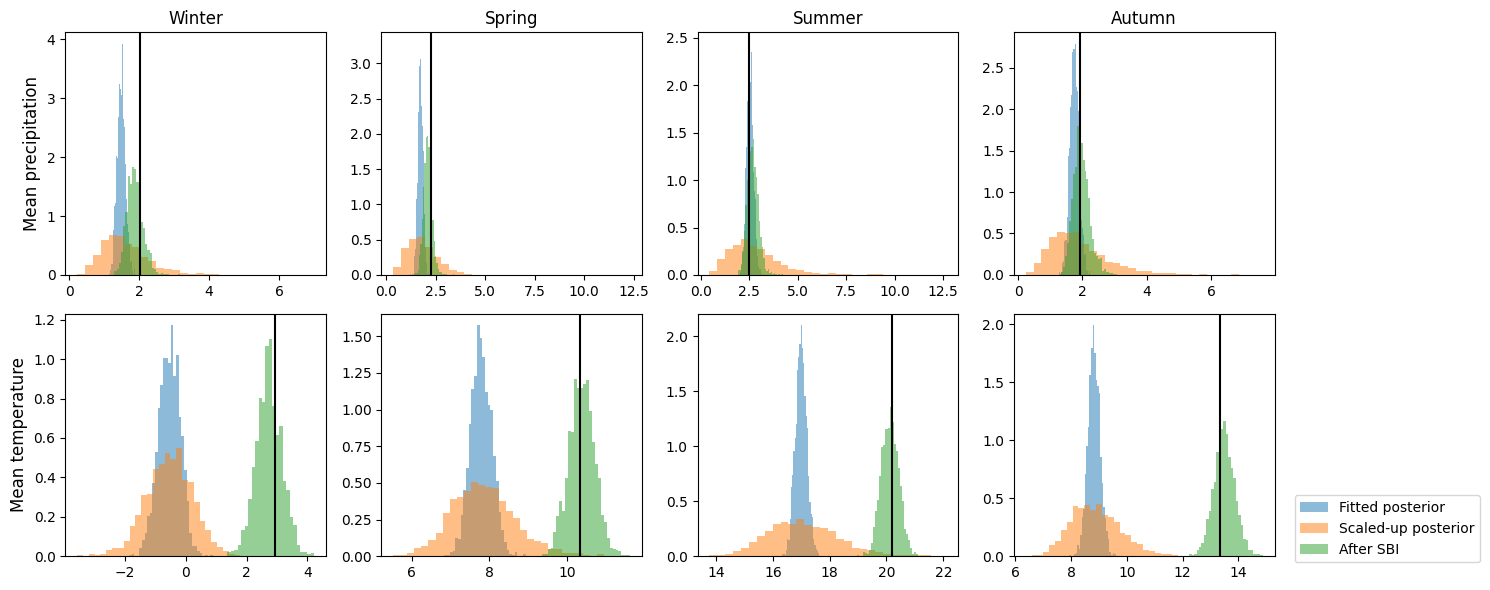

In [235]:
# Plot
idxs = [0, 1, 2, 3, 4, 5, 6, 7]
samples_summary_stats_reduced_plot = dict()
samples_summary_stats_reduced_plot["fitted_posterior"] = samples_summary_stats["fitted_posterior"][:, idxs]
samples_summary_stats_reduced_plot["sbi_proposal"] = samples_summary_stats["sbi_proposal"][:, idxs]
samples_summary_stats_reduced_plot["sbi_posterior"] = samples_summary_stats["sbi_posterior"][:, idxs]
obs_stats_target_reduced_plot = obs_stats_target[idxs, :]

fig, axs = plt.subplots(2, 4, figsize = (15, 6), layout = "tight")
axs[0, 0].set_ylabel("Mean precipitation", size = "large")
axs[1, 0].set_ylabel("Mean temperature", size = "large")

axs = axs.ravel()
axs[0].set_title("Winter")
axs[1].set_title("Spring")
axs[2].set_title("Summer")
axs[3].set_title("Autumn")

for i in range(obs_stats_target_reduced_plot.shape[0]):
    axs[i].hist(samples_summary_stats_reduced_plot["fitted_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Fitted posterior")
    axs[i].hist(samples_summary_stats_reduced_plot["sbi_proposal"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "Scaled-up posterior")
    axs[i].hist(samples_summary_stats_reduced_plot["sbi_posterior"][:, i].numpy(), bins = 30, density = True, alpha = 0.5, label = "After SBI")
    #axs[i].legend(loc = "upper right")
    #axs[i].set_title(titles[i])
    axs[i].axvline(obs_stats_target_reduced_plot[i,:].flatten(), c= "black")
    #axs[i].set_xlim(left = left_xlims[i], right = right_xlims[i])
axs[-1].legend(bbox_to_anchor = (1.05, 0.28))
plt.savefig("plots/case_study_3c.png", dpi = 300)

In [240]:
obs_hist = t2j(samples_obs["mean_fitted_posterior"])
obs_fut = t2j(samples_obs["sbi_posterior_point_estimate"])

pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

In [272]:
def add_monthly_targets(targets, ax):
    for i in range(2, 12):
        ax.hlines(y = targets[i-1], xmin = i-0.5, xmax = i+0.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[0], xmin = 1, xmax = 1.5, color = "darkblue", linestyle = "dashed")
    ax.hlines(y = targets[11], xmin = 11.5, xmax = 12, color = "darkblue", linestyle = "dashed")


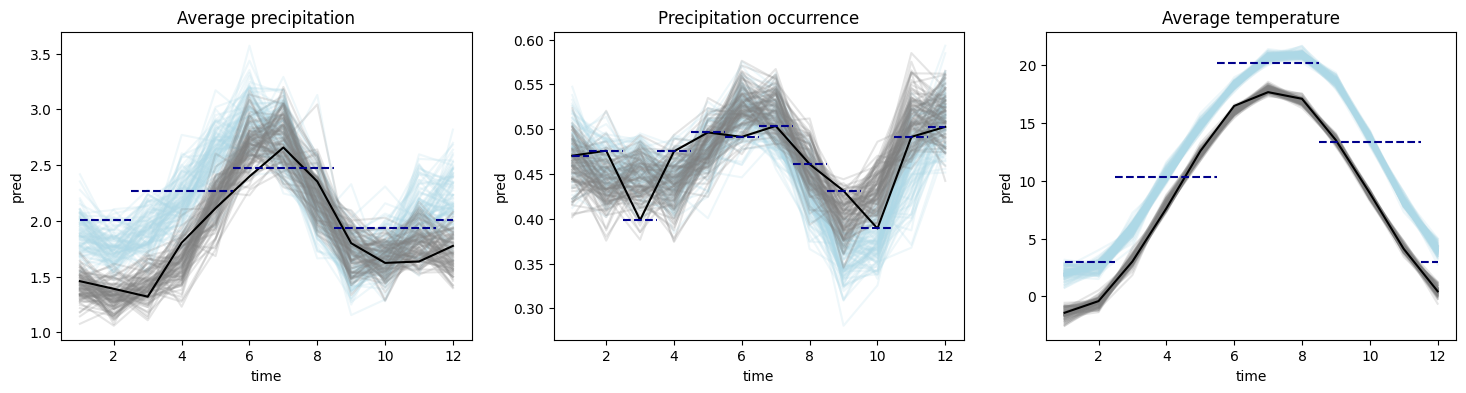

In [274]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation")

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1])
add_monthly_targets(obs_stats_target[8:], axs[1])
axs[1].set_title("Precipitation occurrence")

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
add_seasonal_targets(obs_stats_target[4:], axs[2])
axs[2].set_title("Average temperature")
plt.savefig("plots/case_study_3c_ensemble.png")

<Axes: xlabel='time', ylabel='value'>

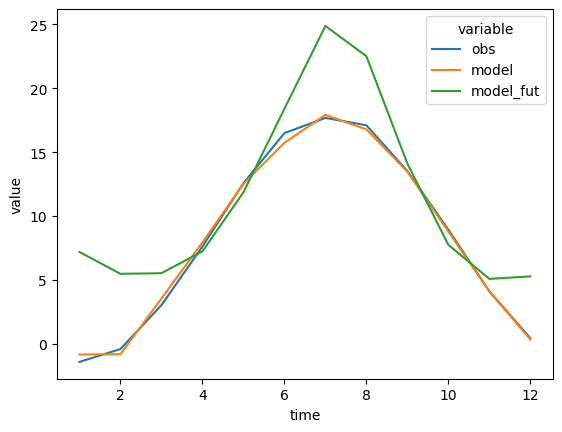

In [818]:
df_obs = pd.DataFrame({"obs": obs["Tavg"].squeeze(), "model": tavg_hist[0, :], "model_fut": tavg_fut[0, :], "time": basin_data_train.index})
df_obs = df_obs.groupby(df_obs.time.dt.month)[["obs", "model", "model_fut"]].mean().reset_index()
df_obs = df_obs.melt(id_vars = "time")
sns.lineplot(df_obs, x="time", y="value", hue = "variable")


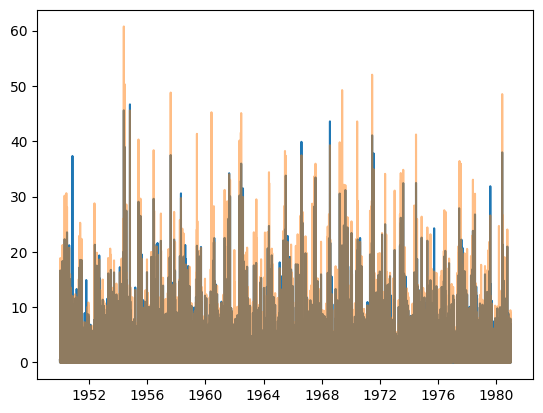

In [790]:
plt.plot(basin_data_train.index, pr_hist[0, :], label = "Base")
plt.plot(basin_data_train.index, pr_fut[0, :], alpha = 0.5, label = "Adjusted")


Text(0.5, 1.0, 'Precipitation')

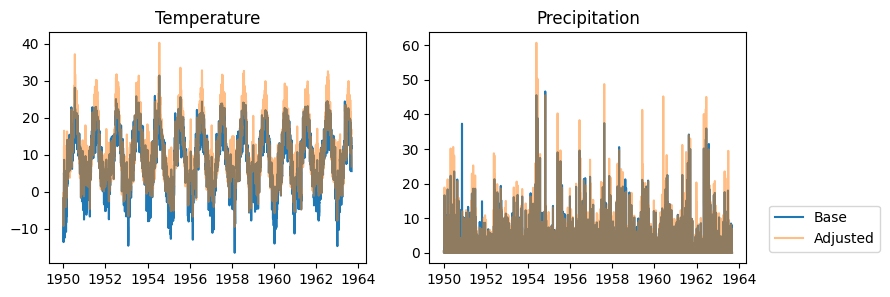

In [792]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 3))

ax1.plot(basin_data_train.index[:5000], tavg_hist[0, :5000], label = "Base")
ax1.plot(basin_data_train.index[:5000], tavg_fut[0, :5000], alpha = 0.5, label = "Adjusted")
ax1.set_title("Temperature")

ax2.plot(basin_data_train.index[:5000], pr_hist[0, :5000], label = "Base")
ax2.plot(basin_data_train.index[:5000], pr_fut[0, :5000], alpha = 0.5, label = "Adjusted")
ax2.legend(bbox_to_anchor = (1.05, 0.28))
ax2.set_title("Precipitation")

## Evaluate 7

In [87]:
samples_summary_stats = torch.load("sbi_results/case_study_7_samples_summary_stats.pt")
samples_obs = torch.load("sbi_results/case_study_7_samples_obs.pt")

In [89]:
obs_hist = t2j(samples_obs["mean_fitted_posterior"])
obs_fut = t2j(samples_obs["sbi_posterior_point_estimate"])

pr_hist, tmin_hist, tavg_hist, tmax_hist = obs_hist[:, :, 0], obs_hist[:, :, 1], obs_hist[:, :, 2], obs_hist[:, :, 3]
pr_fut, tmin_fut, tavg_fut, tmax_fut = obs_fut[:, :, 0], obs_fut[:, :, 1], obs_fut[:, :, 2], obs_fut[:, :, 3]

Text(0.5, 1.0, 'Average temperature')

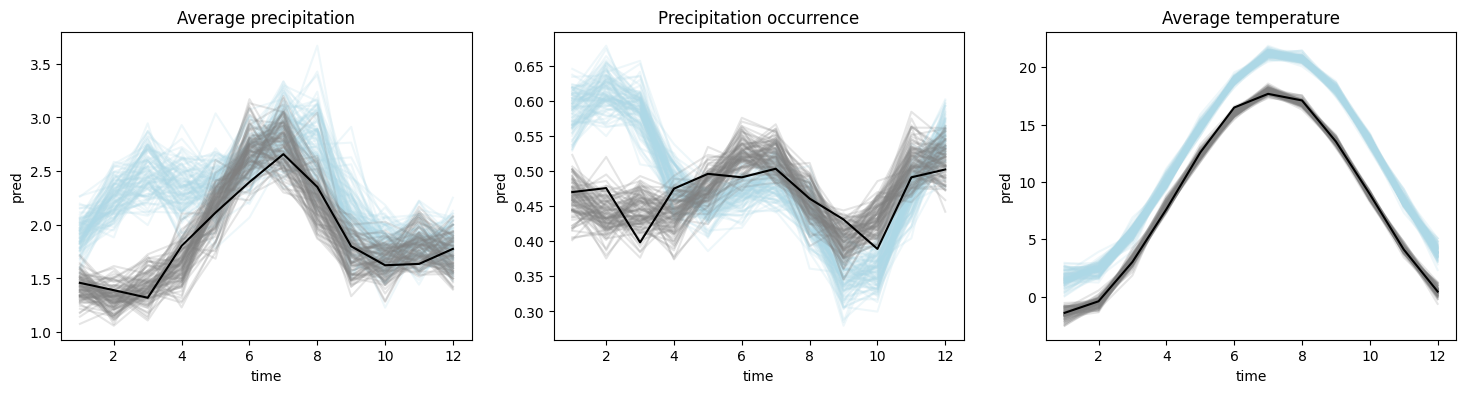

In [91]:
fig, axs = plt.subplots(1,3, figsize = (18,4))
make_line_plots(pr_fut, pr_hist, obs["prec"], basin_data_train.index, ax = axs[0])
#add_seasonal_targets(obs_stats_target[:4], axs[0])
axs[0].set_title("Average precipitation")

make_line_plots(pr_fut > 0, pr_hist > 0, obs["prec"] > 0, basin_data_train.index, ax = axs[1])
#add_seasonal_targets(obs_stats_target[4:9], axs[1])
axs[1].set_title("Precipitation occurrence")

make_line_plots(tavg_fut, tavg_hist, obs["Tavg"], basin_data_train.index, ax = axs[2])
#add_seasonal_targets(obs_stats_target[8:], axs[2])
axs[2].set_title("Average temperature")


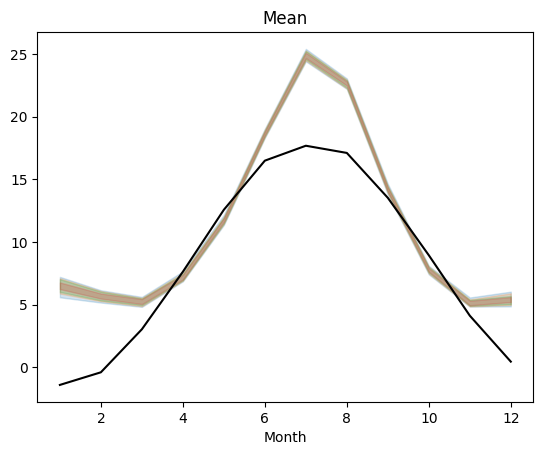

In [475]:
get_mean_plot(obs["Tavg"], tavg_fut, basin_data_train.index)


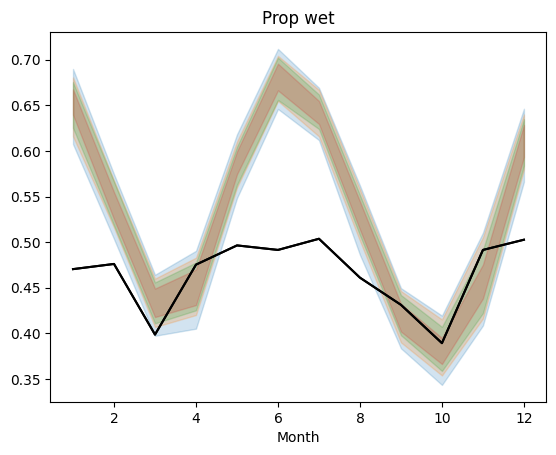

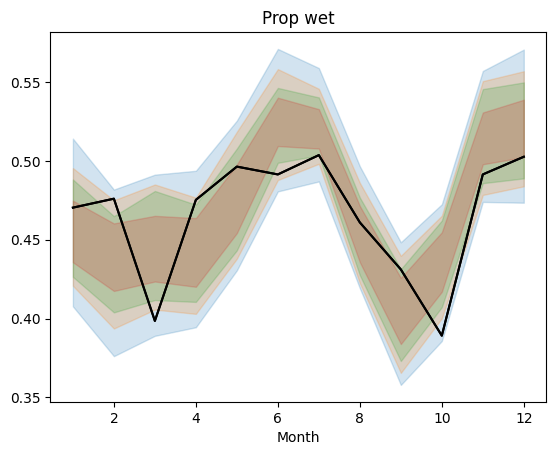

In [477]:
get_prop_wet_plot(obs["prec"], pr_fut, basin_data_train.index)
plt.show()
get_prop_wet_plot(obs["prec"], svi_preds["prec"], basin_data_train.index)


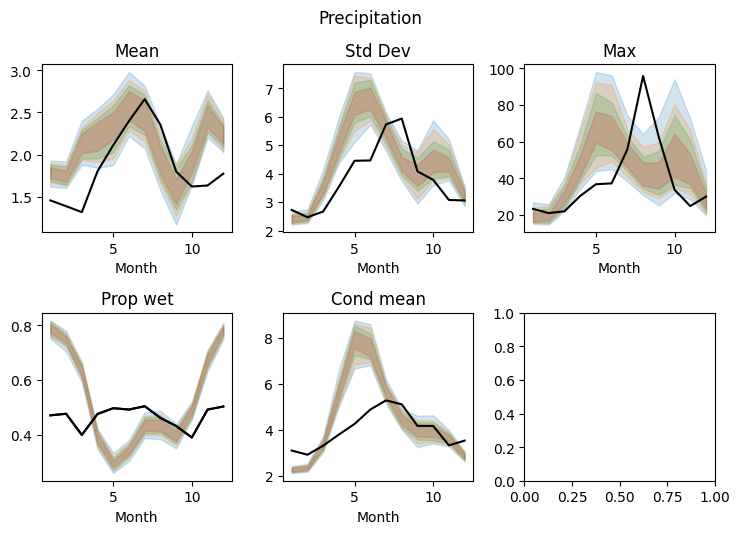

In [1047]:
fig = plt.figure(layout="tight", figsize=(7.5, 7.5))
fig.suptitle("Precipitation")

gs = GridSpec(3, 3, figure=fig)

# Row 1
ax_row_1 = [fig.add_subplot(gs[0, i]) for i in range(3)]
get_mean_plot(obs["prec"], pr_fut, basin_data_train.index, ax=ax_row_1[0])
get_std_plot(obs["prec"], pr_fut, basin_data_train.index, ax=ax_row_1[1])
get_max_plot(obs["prec"], pr_fut, basin_data_train.index, ax=ax_row_1[2])

# Row 2
ax_row_2 = [fig.add_subplot(gs[1, i]) for i in range(3)]
get_prop_wet_plot(obs["prec"], pr_fut, basin_data_train.index, ax=ax_row_2[0])
get_cond_mean_plot(obs["prec"], pr_fut, basin_data_train.index, ax=ax_row_2[1])


Overview plots:

In [ ]:
theta_adj = samples.median(0)[0].unsqueeze(0)
rain_samples_adj = simulator_get_rain(torch.concat(100*[theta_adj], axis = 0))

In [487]:
future_obs = {"prec": rain_samples_adj[:, :, 0], "Tmin": rain_samples_adj[:, :, 1], "Tavg": rain_samples_adj[:, :, 2], "Tmax": rain_samples_adj[:, :, 3], "Trange": rain_samples_adj[:, :, 3] - rain_samples_adj[:, :, 1]}
future_obs["Tskew"] = (future_obs["Tavg"] - future_obs["Tmin"])/future_obs["Trange"]
future_obs = {k: np.expand_dims(e, -1) for k, e in future_obs.items()}

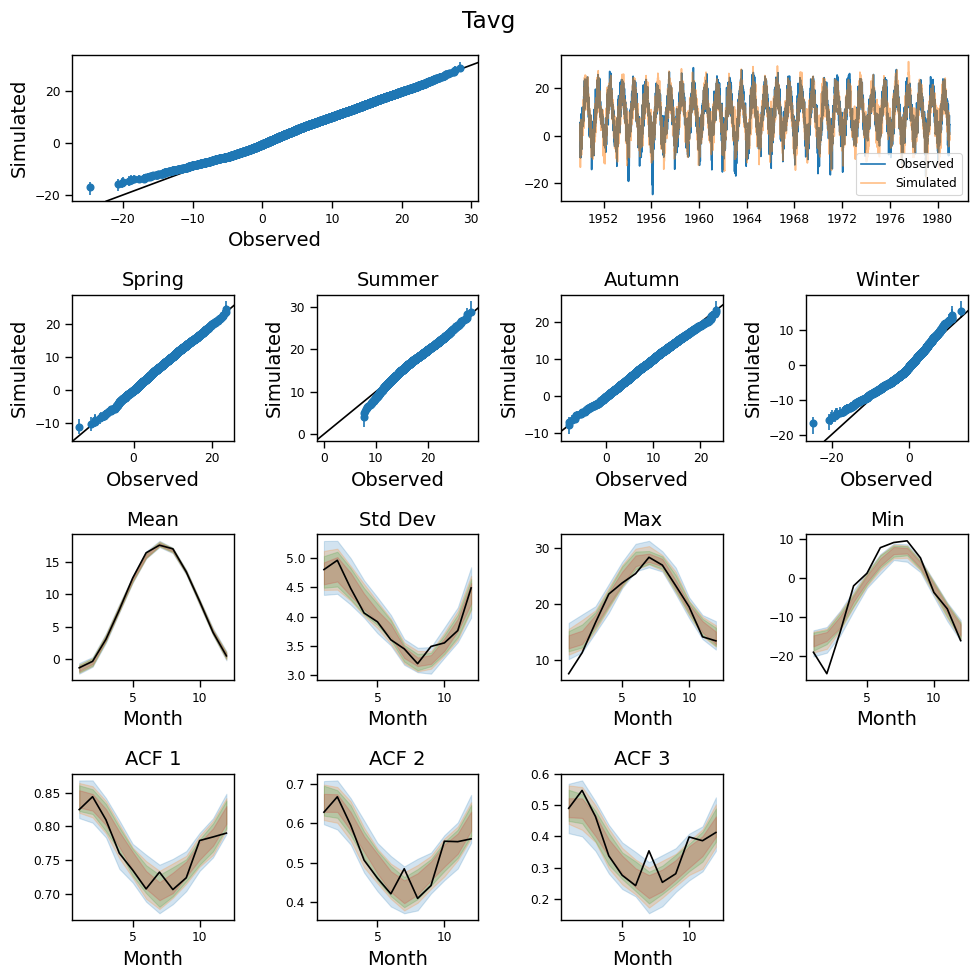

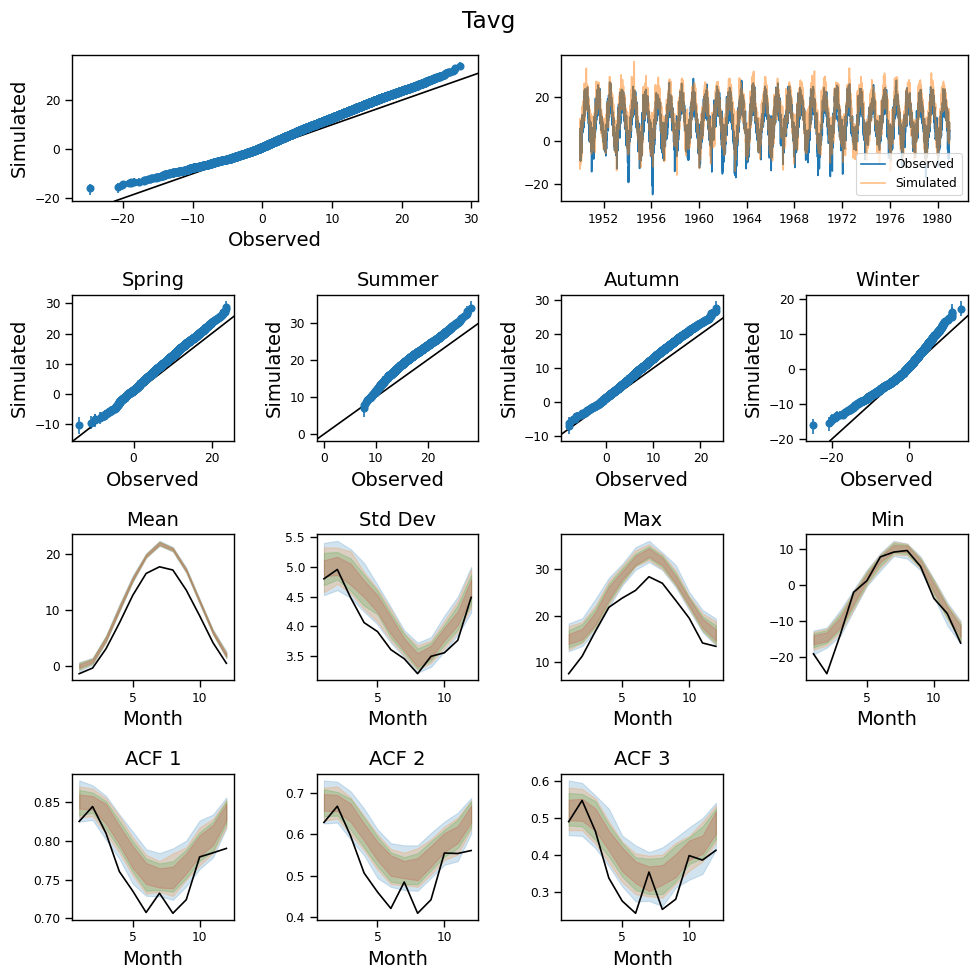

In [489]:
Tavg_overview(obs, svi_preds, basin_data_train)
Tavg_overview(obs, future_obs, basin_data_train)

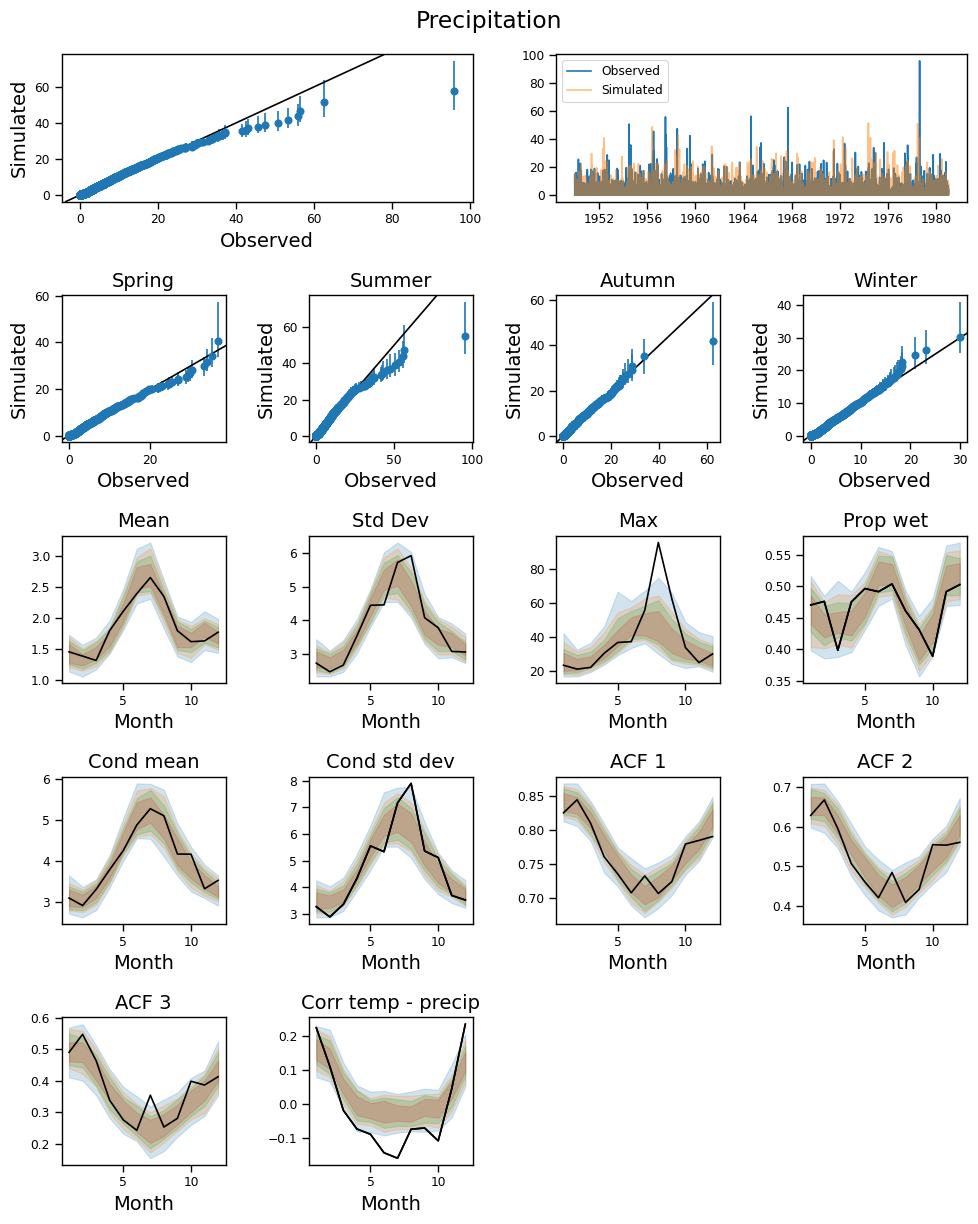

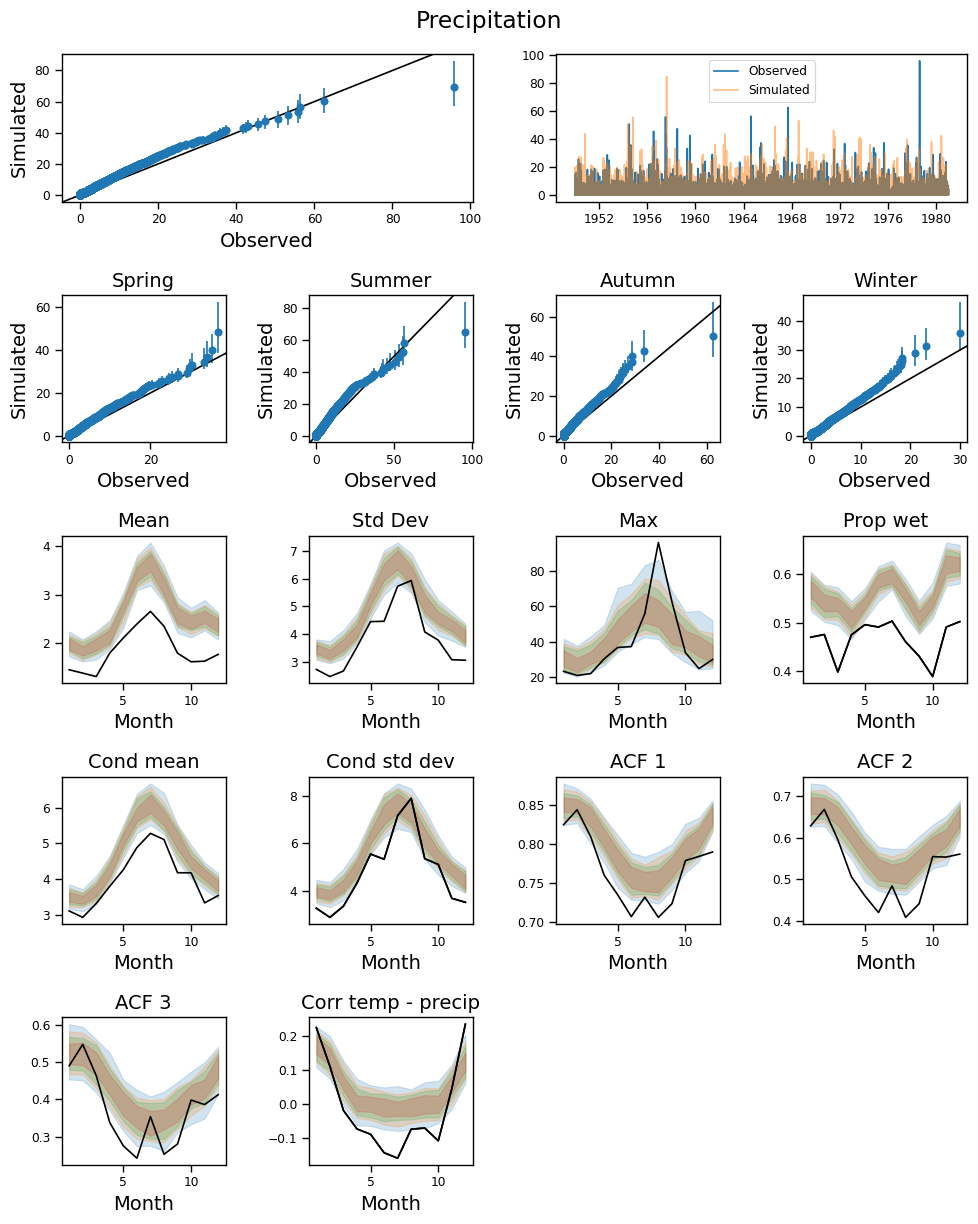

In [491]:
prec_overview(obs, svi_preds, basin_data_train)
prec_overview(obs, future_obs, basin_data_train)

In [197]:
print(f"Cond mean hist {rain_hist[rain_hist > 0].mean()}, cond mean fut: {rain_fut[rain_fut > 0].mean()}")

Cond mean hist 4.085076808929443, cond mean fut: 3.912468194961548


In [80]:
import seaborn as sns

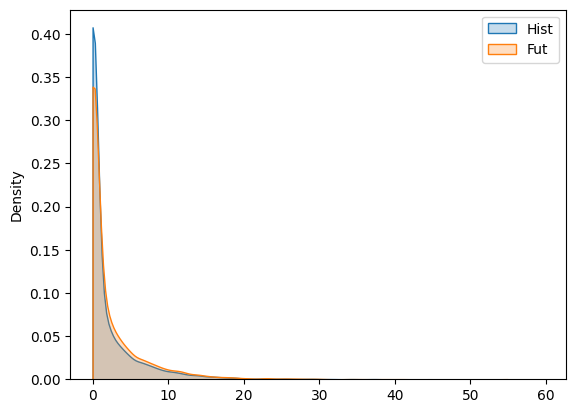

In [341]:
sns.kdeplot(rain_hist, cut = 0, fill = True, label = "Hist")
sns.kdeplot(rain_fut, cut = 0, fill = True, label = "Fut")
plt.legend()

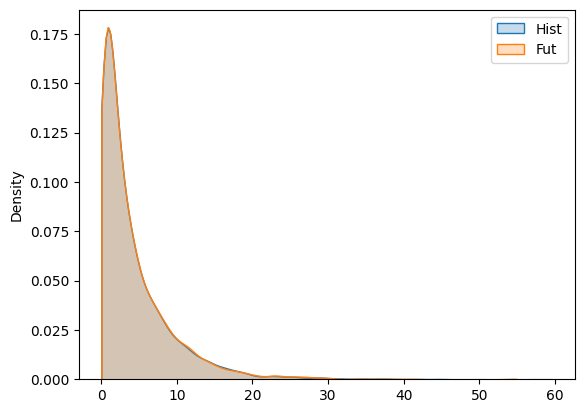

In [343]:
sns.kdeplot(rain_hist[rain_hist > 0], cut = 0, fill = True, label = "Hist")
sns.kdeplot(rain_fut[rain_fut > 0], cut = 0, fill = True, label = "Fut")
plt.legend()

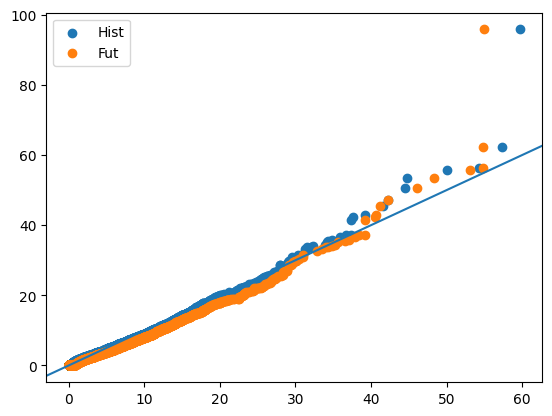

In [345]:
plt.scatter(np.sort(rain_hist), np.sort(rain_obs), label = "Hist")
plt.scatter(np.sort(rain_fut), np.sort(rain_obs), label = "Fut")
plt.axline((0,0), slope = 1)
plt.legend()

## Other

In [378]:
def precip_summary_stats(pr, cdd_thresh=0.0, axis=0):
    pmean = jnp.mean(pr, axis=axis)
    p95 = jnp.nanquantile(jnp.where(pr > 0, pr, jnp.nan), 0.95, axis=axis)
    rp95 = jnp.nanmean(jnp.where(pr > p95, pr, jnp.nan), axis=axis)
    fwd = jnp.mean(pr > 0, axis=axis)
    cdd = wx.utils.cumulative_dry_days(pr, threshold=cdd_thresh, axis=axis)
    return jnp.stack([pmean, rp95, fwd, cdd])

def tair_summary_stats(Tair_mean, Tair_min, Tair_max):
    Tavg = jnp.mean(Tair_mean, axis=0)
    Trange = jnp.mean(Tair_max - Tair_min, axis=0)
    Tskew = jnp.mean((Tair_mean - Tair_min) / (Tair_max - Tair_min), axis=0)
    ftd = jnp.mean(jnp.where(Tair_mean > 0, 1, 0), axis=0)
    # ffd = jnp.mean(jnp.where(Tair_mean <= 0, 1, 0), axis=0)
    return jnp.stack([Tavg, Trange, Tskew, ftd])

def wgen_summary_stats(ts, precip, Tmin, Tavg, Tmax):
    precip_stats = precip_summary_stats(precip)
    Tair_stats = tair_summary_stats(Tavg, Tmin, Tmax)
    return jnp.concat([precip_stats, Tair_stats], axis=0)
    # return precip_stats

summary_stat_names = ["prec_mean", "rp95", "norm wet days", "mean dry spell length", "Tair_mean", "Tair_range", "Tair_skew", "norm thaw days"]

In [379]:
wgen_sim, wgen_prior = wgen.simulator(observable=wgen_summary_stats, rng_seed=1234)

In [380]:
sim_stats = wgen_sim(wgen_prior.sample(jax.random.PRNGKey(0), (10,)))
sim_stats.shape

(10, 8)

In [381]:
obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = wgen_summary_stats(wgen.timestamps[0,:,:], obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[ 1.8636943 ],
       [20.212057  ],
       [ 0.4654244 ],
       [ 3.2772062 ],
       [ 8.347303  ],
       [ 7.7874007 ],
       [ 0.47035772],
       [ 0.84827346]], dtype=float32)

We can use the "true" prior of the model by wrapping it in a `torch` distribution as such:

    wx.distributions.NumPyro2TorchDistribution(wgen_prior)

However, the true prior for the GLM-type models is very uninformative and will generate many physically implausible or simply invalid simulations.

The two options here are therefore:

1. Design a better prior
2. Use the SVI calibrated posterior to construct a "better" prior for SBI

The more prinicpled option is (1), but it's also hard and time consuming. So we go with (2) instead :)


In [383]:
wgen_sbi = jax2torch(wgen_sim)
# wgen_sbi_prior = process_prior(wx.distributions.NumPyro2TorchDistribution(wgen_prior))


In [384]:
svi_posterior = guide.get_posterior(svi_result.params)
svi_posterior_torch = torch.distributions.MultivariateNormal(j2t(svi_posterior.mean), j2t(svi_posterior.covariance_matrix))
scale_factor = 2
svi_proposal = torch.distributions.MultivariateNormal(j2t(svi_posterior.mean), j2t(scale_factor**2*jnp.eye(len(svi_posterior.mean))*jnp.diag(svi_posterior.covariance_matrix)))
# svi_proposal = torch.distributions.MultivariateNormal(j2t(svi_posterior.mean), j2t(scale_factor**2*jnp.eye(len(svi_posterior.mean))*svi_posterior.covariance_matrix))

# sample from propsoal prior and run simulations
sbi_prior_samples = svi_proposal.sample((100,))
sbi_prior_obs = wgen_sbi(sbi_prior_samples)

In [385]:

# sample from SVI posterior
svi_posterior_samples = svi_posterior_torch.sample((200,))
svi_posterior_sims = wgen_sbi(svi_posterior_samples)

In [386]:
# sample from variance-inflated proposal
svi_prposoal_samples = svi_proposal.sample((200,))
svi_proposal_sims = wgen_sbi(svi_prposoal_samples)

In [387]:
posterior_sims = pd.DataFrame(svi_posterior_sims.numpy(), columns=summary_stat_names)
proposal_sims = pd.DataFrame(svi_proposal_sims.numpy(), columns=summary_stat_names)

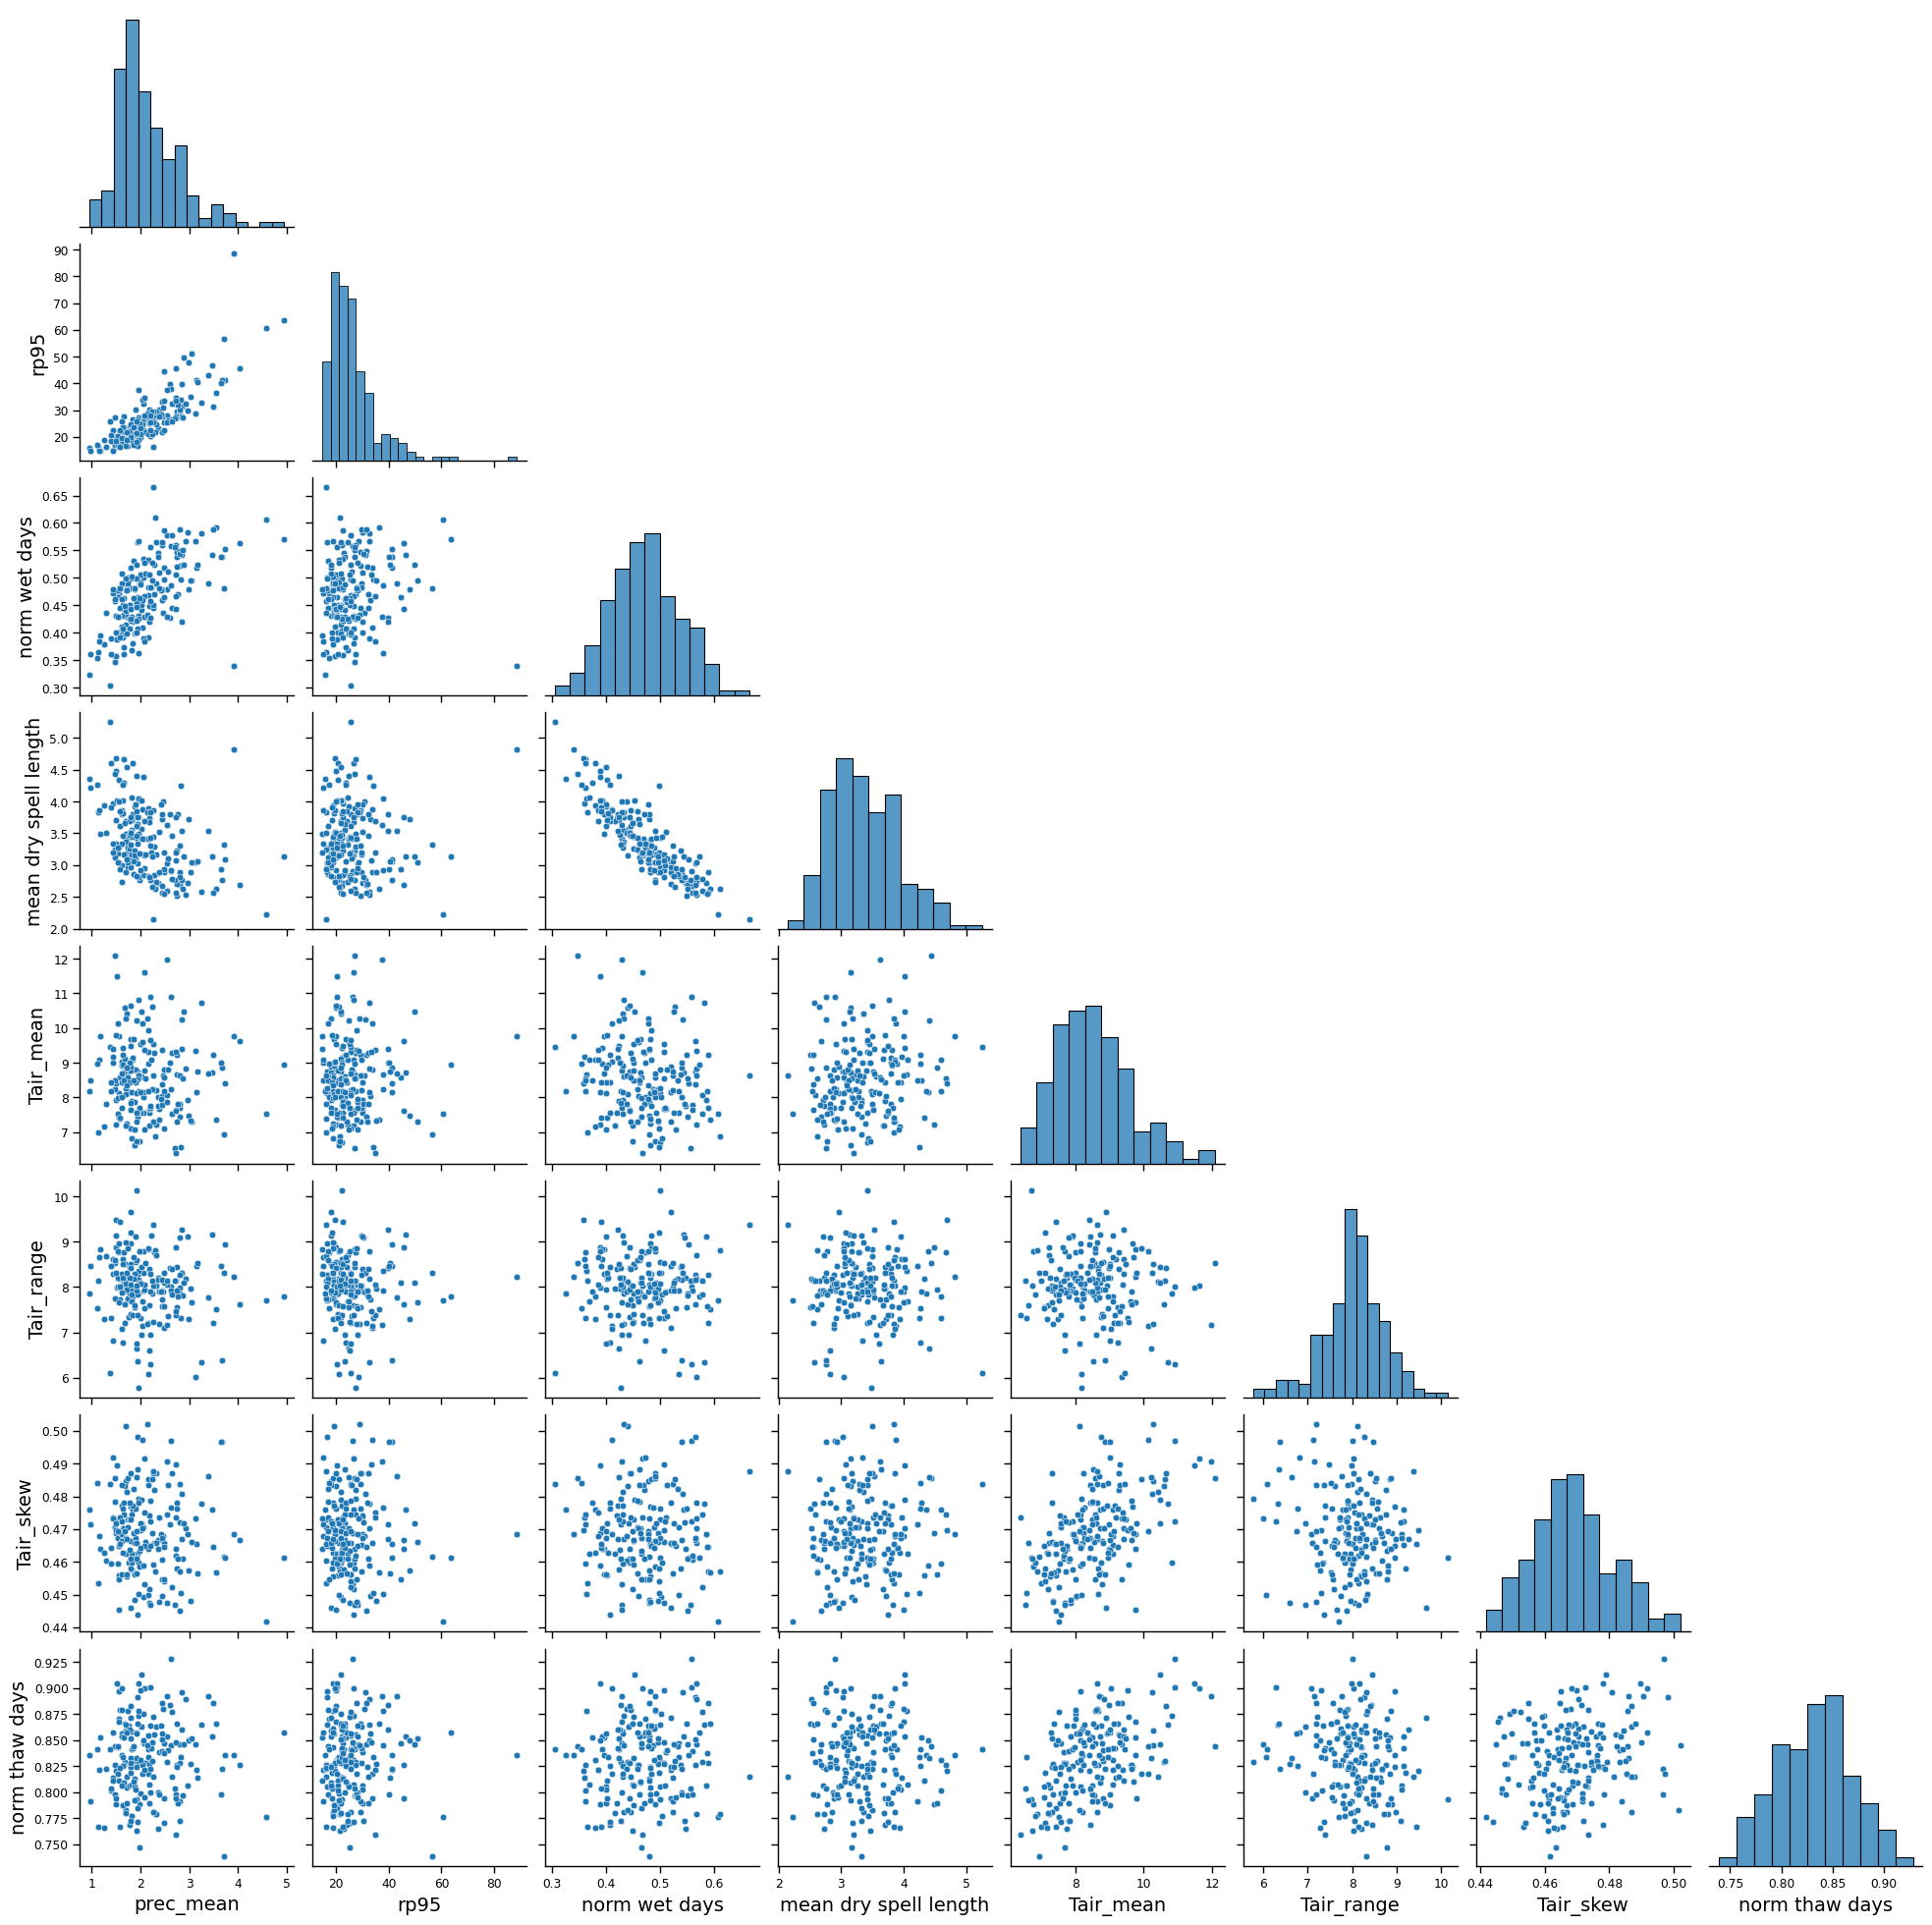

In [389]:
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14})
sns.pairplot(proposal_sims.dropna(), corner=True)
#plt.savefig("../plots/wgen_summary_stats_corner_plot.png")

In [46]:
# compute empirical mean and covariance, dropping rows with nan values
svi_posterior_sims_mean = torch.mean(svi_posterior_sims[torch.isfinite(svi_posterior_sims).all(dim=1),:], dim=0)
svi_proposal_sims_mean = torch.mean(svi_proposal_sims[torch.isfinite(svi_proposal_sims).all(dim=1),:], dim=0)
svi_posterior_sims_cov = torch.cov(svi_posterior_sims[torch.isfinite(svi_posterior_sims).all(dim=1),:].T)
svi_proposal_sims_cov = torch.cov(svi_proposal_sims[torch.isfinite(svi_proposal_sims).all(dim=1),:].T)

<Axes: >

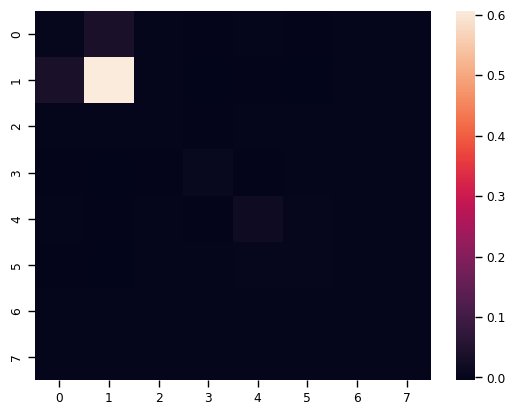

In [47]:
sns.heatmap(svi_posterior_sims_cov.numpy())

<Axes: >

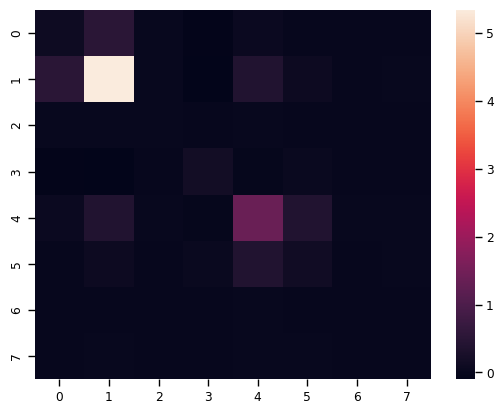

In [48]:
sns.heatmap(svi_proposal_sims_cov.numpy())

In [49]:
proposal_sims_dist = torch.distributions.MultivariateNormal(svi_proposal_sims_mean, svi_proposal_sims_cov)
obs_stats2 = t2j(proposal_sims_dist.sample((1,)).T)
obs_stats2 - obs_stats

Array([[-2.0868897e-01],
       [-2.3722725e+00],
       [ 1.8947244e-02],
       [-1.4467025e-01],
       [-1.0982389e+00],
       [-7.6457119e-01],
       [-5.2743554e-03],
       [ 2.3602247e-03]], dtype=float32)

In [ ]:
num_simulations = 2000
num_rounds = 1 # for some reason, single round inference seems to work much better than multi-round. might need to report this to the sbi developers?
proposal = svi_proposal
sbi_alg = SNPE(proposal)
# sbi_alg = SNLE(proposal)

In [ ]:
for i in range(num_rounds):
    print(f"Starting SBI round {i+1}/{num_rounds}")
    theta, x = simulate_for_sbi(wgen_sbi, proposal=proposal, num_simulations=num_simulations, simulation_batch_size=200)
    sbi_alg.append_simulations(theta, x, proposal, exclude_invalid_x=True)
    density_estimator = sbi_alg.train()
    sbi_posterior = sbi_alg.build_posterior(density_estimator).set_default_x(j2t(obs_stats.squeeze()))
    proposal = sbi_posterior
    print("")

In [ ]:
# sample from SBI posterior
sbi_samples = sbi_posterior.sample((200,))
sbi_posterior_sims = wgen_sbi(sbi_samples)

In [ ]:
# sample from recalibrated SBI posterior
obs_target = obs_stats2
sbi_samples2 = sbi_posterior.sample((200,), x=j2t(obs_target[:,0]))
sbi_posterior_sims2 = wgen_sbi(sbi_samples2)

In [ ]:
ncols = 4
nrows = 2
fig, axs = plt.subplots(nrows,ncols,figsize=(16,9))
for i in range(obs_stats.shape[0]):
    c = i % ncols
    r = i // ncols
    _,_,h1 = axs[r,c].hist(svi_posterior_sims.numpy()[:,i], bins=20, density=True, color='blue', alpha=0.8, label="SVI posterior")
    _,_,h2 = axs[r,c].hist(svi_proposal_sims.numpy()[:,i], bins=20, density=True, color='skyblue', alpha=0.7, label="SBI prior")
    _,_,h3 = axs[r,c].hist(sbi_posterior_sims.numpy()[:,i], bins=20, density=True, color='orange', alpha=0.6, label="SBI posterior")
    _,_,h4 = axs[r,c].hist(sbi_posterior_sims2.numpy()[:,i], bins=20, density=True, color='red', alpha=0.3, label="SBI posterior (recalibrated)")
    axs[r,c].axvline([obs_stats[i,:]], c='black', linestyle="--")
    axs[r,c].axvline([obs_target[i,:]], c='red', linestyle="--")
    axs[r,c].set_yticks([])
    axs[r,c].set_title(summary_stat_names[i])
for i in range(obs_stats.shape[0], ncols*nrows):
    c = i % ncols
    r = i // ncols
    fig.delaxes(axs[r,c])
labels = ["Initial posterior", "SBI proposal", "SBI posterior (obs.)", "SBI posterior (target)"]
fig.legend(handles=[h1,h2,h3,h4], labels=labels, ncol=4, loc="lower center", bbox_to_anchor=(0.5,-0.02))
plt.tight_layout()
plt.savefig("../plots/basin_6340800_sbi_posterior_all_recalibrated.png")
plt.show()

In [55]:
sbi_posterior_sims2_shift = t2j(sbi_posterior_sims2.mean(axis=0))
sbi_posterior_sims2_scale = t2j(sbi_posterior_sims2.std(axis=0))
sbi_posterior_sims2_standardized = (t2j(sbi_posterior_sims2) - sbi_posterior_sims2_shift) / sbi_posterior_sims2_scale
posterior_obs_resid = sbi_posterior_sims2_standardized - (obs_target.T - sbi_posterior_sims2_shift) / sbi_posterior_sims2_scale
posterior_obs_resid.shape

(200, 8)

(array([ 2.,  7., 24., 39., 60., 33., 20., 12.,  2.,  1.]),
 array([-2.96089768, -2.32558632, -1.69027519, -1.05496395, -0.4196527 ,
         0.21565843,  0.85096979,  1.48628116,  2.12159228,  2.75690341,
         3.39221454]),
 <BarContainer object of 10 artists>)

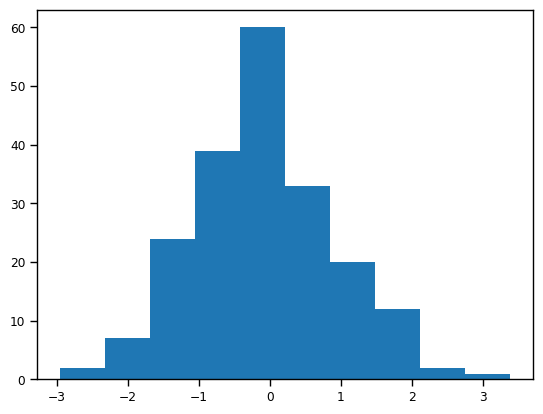

In [56]:
plt.hist(posterior_obs_resid[:,0])

In [57]:
summary_stats_df = basin_data_train[["prec","Tair_min","Tair_mean","Tair_max"]].groupby(basin_data_train.index.year).apply(lambda df: pd.DataFrame(wgen_summary_stats(df.index.values, df.prec.values, df.Tair_min.values, df.Tair_mean.values, df.Tair_max.values).reshape((1,-1)), columns=summary_stat_names)).reset_index().drop("level_1", axis=1)
summary_stats_df.describe()

time  prec_mean       rp95  norm wet days  \
count    41.000000  41.000000  41.000000      41.000000   
mean   1970.000000   1.841034  19.146120       0.464165   
std      11.979149   0.353711   4.528127       0.048617   
min    1950.000000   1.057300  13.098458       0.372603   
25%    1960.000000   1.523839  15.737223       0.427397   
50%    1970.000000   1.854292  18.018492       0.476712   
75%    1980.000000   2.098828  21.663124       0.498630   
max    1990.000000   2.655576  28.655827       0.546448   

       mean dry spell length  Tair_mean  Tair_range  Tair_skew  norm thaw days  
count              41.000000  41.000000   41.000000  41.000000       41.000000  
mean                3.295445   8.464806    7.665947   0.483585        0.852496  
std                 0.514934   0.769984    0.580928   0.026299        0.049317  
min                 2.553846   6.581241    6.549250   0.447778        0.753425  
25%                 2.885246   7.802209    7.438528   0.464979        0.816940  
50%                 3.216667   8.450788    7.685133   0.475402        0.852055  
75%                 3.649123   9.033152    8.031537   0.493390        0.887671  
max                 4.571429  10.052711    9.160261   0.537237        0.972603

In [58]:
obs_stats3 = obs_stats.at[1].add(5.0).at[2].add(-0.1).at[3].add(0.5)
obs_stats3 - obs_stats

Array([[ 0.        ],
       [ 5.        ],
       [-0.09999999],
       [ 0.5       ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]], dtype=float32)

In [59]:
# sample from recalibrated SBI posterior
obs_target = obs_stats3
sbi_samples3 = sbi_posterior.sample((200,), x=j2t(obs_target[:,0]))
sbi_samples3_mean = torch.quantile(sbi_samples3, q=0.5, axis=0, keepdims=True)*torch.ones((200,1))
sbi_posterior_sims3 = wgen_sbi(sbi_samples3_mean)

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

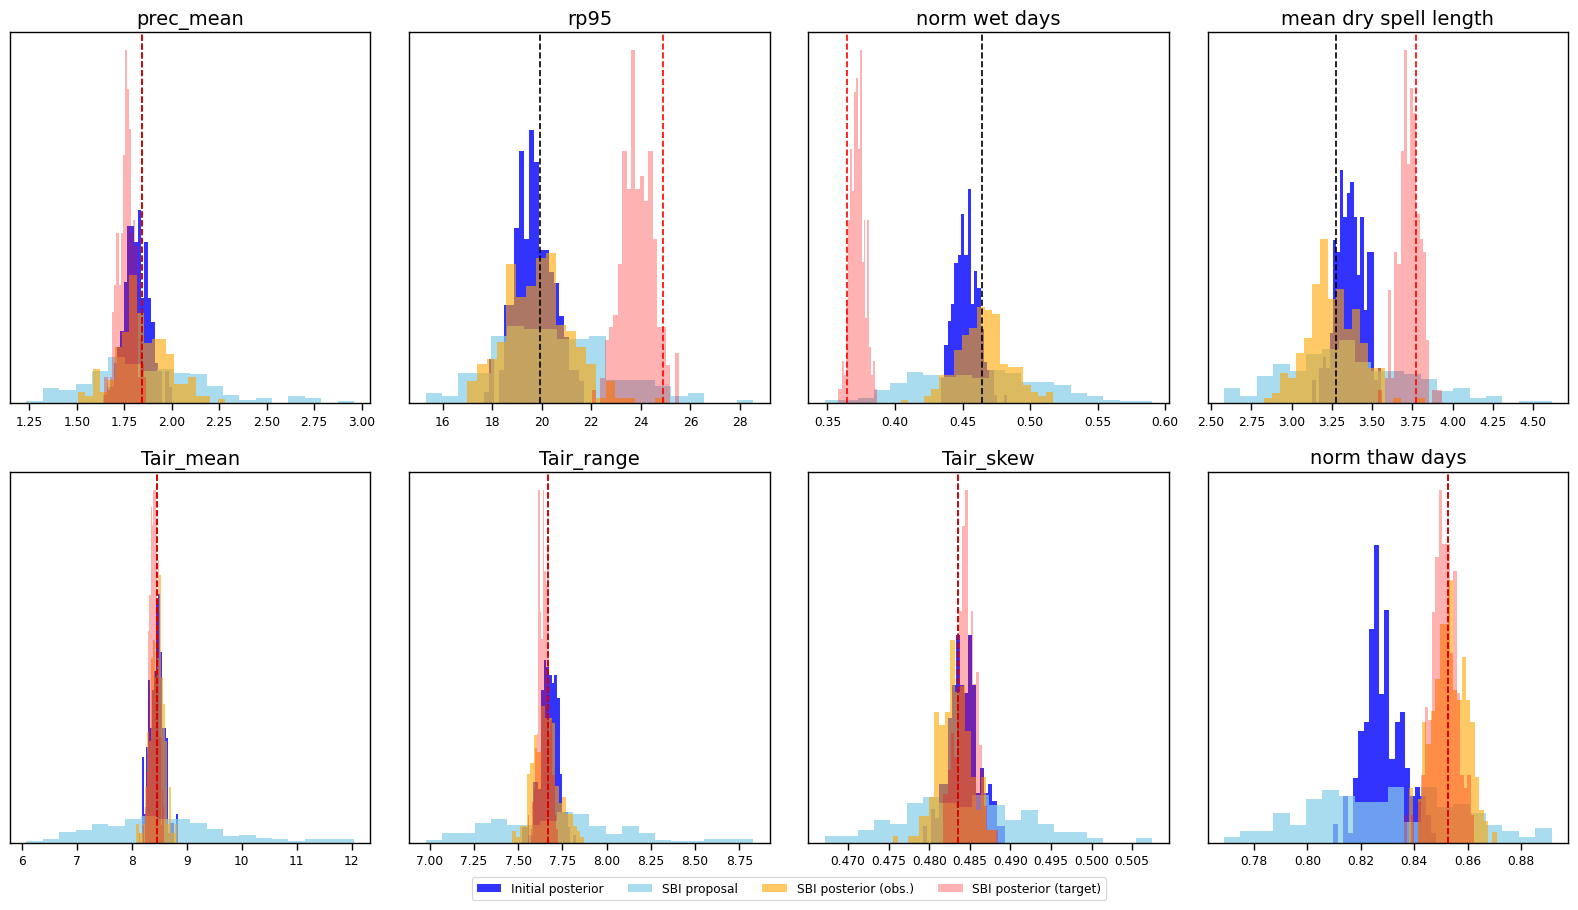

In [60]:
ncols = 4
nrows = 2
fig, axs = plt.subplots(nrows,ncols,figsize=(16,9))
for i in range(obs_stats.shape[0]):
    c = i % ncols
    r = i // ncols
    _,_,h1 = axs[r,c].hist(svi_posterior_sims.numpy()[:,i], bins=20, density=True, color='blue', alpha=0.8)
    _,_,h2 = axs[r,c].hist(svi_proposal_sims.numpy()[:,i], bins=20, density=True, color='skyblue', alpha=0.7)
    _,_,h3 = axs[r,c].hist(sbi_posterior_sims.numpy()[:,i], bins=20, density=True, color='orange', alpha=0.6)
    _,_,h4 = axs[r,c].hist(sbi_posterior_sims3.numpy()[:,i], bins=20, density=True, color='red', alpha=0.3)
    axs[r,c].axvline([obs_stats[i,:]], c='black', linestyle="--")
    axs[r,c].axvline([obs_target[i,:]], c='red', linestyle="--")
    axs[r,c].set_yticks([])
    axs[r,c].set_title(summary_stat_names[i])
for i in range(obs_stats.shape[0], ncols*nrows):
    c = i % ncols
    r = i // ncols
    fig.delaxes(axs[r,c])
labels = ["Initial posterior", "SBI proposal", "SBI posterior (obs.)", "SBI posterior (target)"]
fig.legend(handles=[h1,h2,h3,h4], labels=labels, ncol=4, loc="lower center", bbox_to_anchor=(0.5,-0.02))
plt.tight_layout()
plt.savefig("../plots/basin_6340800_sbi_posterior_rp95_wd_cdd_recalibrated.png")
plt.show()

In [61]:
sbi_posterior_samples_mean = sbi_samples.mean(axis=0, keepdims=True)
sbi_posterior_sims_mean = wgen_sbi(sbi_posterior_samples_mean)
sbi_posterior_sims_mean

tensor([[ 1.8457, 19.1253,  0.4719,  3.1900,  8.3043,  7.6414,  0.4813,  0.8474]])

In [62]:
sbi_params1 = wgen_prior.constrain(t2j(sbi_samples), as_dict=True)
sbi_params2 = wgen_prior.constrain(t2j(sbi_samples2), as_dict=True)
sbi_params3 = wgen_prior.constrain(t2j(sbi_samples3), as_dict=True)

In [63]:
sbi_predictive1 = Predictive(wgen.simulate, posterior_samples=sbi_params1, parallel=True)
sbi_preds1 = sbi_predictive1(prng)

In [64]:
sbi_predictive2 = Predictive(wgen.simulate, posterior_samples=sbi_params2, parallel=True)
sbi_preds2 = sbi_predictive2(prng)

In [65]:
sbi_predictive3 = Predictive(wgen.simulate, posterior_samples=sbi_params3, parallel=True)
sbi_preds3 = sbi_predictive3(prng)

In [66]:
sbi_preds1["Tavg"].shape

(200, 14975, 1)

In [67]:
wgen.obs['Tavg'].shape

(1, 14975)

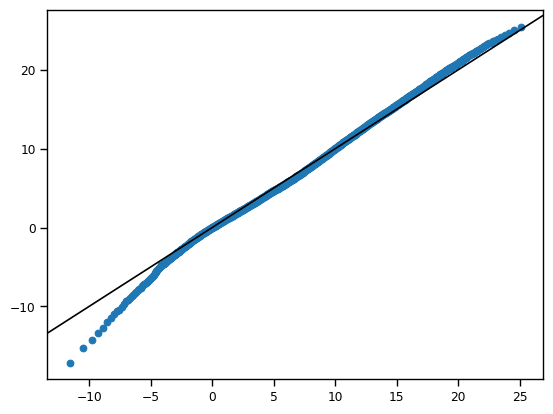

In [68]:
Tavg_preds1 = sbi_preds1["Tavg"].flatten().sort()
Tavg_obs1 = wgen.obs["Tavg"].squeeze().sort()
plt.scatter(np.quantile(Tavg_preds1, np.arange(0.001,0.999,0.001)), np.quantile(Tavg_obs1, np.arange(0.001,0.999,0.001)))
plt.axline((0,0),slope=1,color="black")

In [69]:
import xarray as xr

def to_xarray(data, preds):
    timestamps = data.index
    Tavg_sims = xr.DataArray(preds["Tavg"].squeeze(), dims=("sample","time"), coords={"time": timestamps.values}, name="Tavg_sim")
    Tmin_sims = xr.DataArray(preds["Tmin"].squeeze(), dims=("sample","time"), coords={"time": timestamps.values}, name="Tmin_sim")
    Tmax_sims = xr.DataArray(preds["Tmax"].squeeze(), dims=("sample","time"), coords={"time": timestamps.values}, name="Tmax_sim")
    prec_sims = xr.DataArray(preds["prec"].squeeze(), dims=("sample","time"), coords={"time": timestamps.values}, name="prec_sim")
    obs = data.to_xarray().astype(np.float32)
    return xr.merge([Tavg_sims, Tmin_sims, Tmax_sims, prec_sims, obs])

In [70]:
sbi_sims1_arr = to_xarray(basin_data_train[["Tair_mean","Tair_min","Tair_max","prec"]].iloc[wgen.first_valid_idx:,:], sbi_preds1)
sbi_sims2_arr = to_xarray(basin_data_train[["Tair_mean","Tair_min","Tair_max","prec"]].iloc[wgen.first_valid_idx:,:], sbi_preds2)
sbi_sims3_arr = to_xarray(basin_data_train[["Tair_mean","Tair_min","Tair_max","prec"]].iloc[wgen.first_valid_idx:,:], sbi_preds3)

In [72]:
sbi_sims1_arr.to_netcdf("../data/products/wgen_glm_v3_basin=6340800_sbi_obs_stats.nc")
sbi_sims2_arr.to_netcdf("../data/products/wgen_glm_v3_basin=6340800_sbi_rand_stats.nc")
sbi_sims3_arr.to_netcdf("../data/products/wgen_glm_v3_basin=6340800_sbi_tuned_stats.nc")

In [73]:
sbi_sims1_arr

<xarray.Dataset> Size: 48MB
Dimensions:    (time: 14975, sample: 200)
Coordinates:
  * time       (time) datetime64[ns] 120kB 1950-01-01 1950-01-02 ... 1990-12-31
Dimensions without coordinates: sample
Data variables:
    Tavg_sim   (sample, time) float32 12MB 2.318 3.241 2.972 ... 0.9073 -0.04229
    Tmin_sim   (sample, time) float32 12MB -4.668 1.906 ... -0.1766 -1.746
    Tmax_sim   (sample, time) float32 12MB 9.926 5.33 5.359 ... 2.711 3.549
    prec_sim   (sample, time) float32 12MB 0.0 0.0 5.898 4.239 ... 0.0 0.0 0.0
    Tair_mean  (time) float32 60kB -4.592 -0.241 1.185 ... 4.872 5.884 4.019
    Tair_min   (time) float32 60kB -5.684 -5.416 -0.2187 ... 0.4121 3.41 1.914
    Tair_max   (time) float32 60kB -2.228 0.9776 2.022 ... 6.171 9.602 6.355
    prec       (time) float32 60kB 0.0 14.84 3.41 2.306 ... 0.0 4.842 0.0 2.197